<div style="width:100%;text-align: top;"> <img align=middle src="https://mmo.aiircdn.com/141/5ed59862e602f.png" alt="Heat beating" style="height:400px;margin-top:1rem;"> </div>

## BUILDING ENERGY CONSUMPTION & GHG EMISSIONS ANALYSIS

Climate change is a global challenge and carbon pollution knows no boundaries.<br>

In 2011, Seattle adopted the goal to become carbon neutral by 2050. The overall approach to carbon reductions in the buildings is to provide information, financial and other incentives, and technical assistance, while establishing strong standards for efficiency and emissions. <br>

As part of the City of Seattle, our team will focus on our primary target: Green House Gas Emissions from non residential buildings.<br>

We will first try to predict the Total Energy Use from Seattle buildings that do not have yet any measurements to build on GHG Emissions.  <br>

To achieve this from the data we have, we are going to run few algorithms that can predict the Energy consumption and then establish a relationship with GHG Emissions.

__IMPORT OF ALL MODULES NEEDED TO PERFORM OUR ANALYSIS__

In [1141]:
#! usr/bin/env python 3
# coding: utf-8

# Importing librairies

import numpy as np                # numerical data processing
import pandas as pd               # numerical tables & time series
import scipy as sp                # numerical integration, interpolation, optimization, linear algebra, and statistics
import scipy.stats as st          # statistical functions
import seaborn as sns             # statistical data visualization
import matplotlib.pyplot as plt   # static, animated, and interactive visualizations in Python
import xgboost as xgb
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from IPython.display import HTML
#from toggle_cell import toggle_code as hide_content


__IMPORTING OUR - AFTER CLEANING - DATA SOURCE__

In [1142]:
# Transforming our input files.csv from the cleaning phase to dataframe

df_data = pd.read_csv("data_cleaned.csv")
df_data = df_data.drop(['Unnamed: 0'], axis=1)
df_data.head(2)
#hide_content()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,...,Longitude,Address,City,State,ZipCode,AgeofBuilding,MeanBuildingGFA,MeanFloorGFA,BuildingGFApct,ParkingGFApct
0,1,2015,NonResidential,Hotel,Mayflower Park Hotel,Downtown,1.0,12.0,88434,Hotel,...,-122.337997,405 Olive Way,Seattle,WA,98101.0,88,88434.0,7369.5,1.0,0.0
1,1,2016,NonResidential,Hotel,Mayflower Park Hotel,Downtown,1.0,12.0,88434,Hotel,...,-122.337990,405 Olive Way,Seattle,WA,98101.0,89,88434.0,7369.5,1.0,0.0


###  1) PREPARATION OF DATA FOR MACHINE LEARNING ALGORITHMS

In [1143]:
df_data.describe()

,OSEBuildingID,DataYear,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e),Latitude,Longitude,ZipCode,AgeofBuilding,MeanBuildingGFA,MeanFloorGFA,BuildingGFApct,ParkingGFApct
count,3173.000000,3173.000000,3173.000000,3173.000000,3.173000e+03,2104.000000,3.173000e+03,3173.000000,3173.000000,3173.000000,3160.000000,3173.000000,3.173000e+03,3.173000e+03,3173.000000,3173.000000
mean,15948.832335,2015.486291,1.101796,4.207375,1.142230e+05,63.877852,8.013581e+06,178.159215,47.616272,-122.333387,98116.499367,54.148125,1.094015e+05,3.607042e+04,0.936291,0.063709
std,13328.615929,0.499891,1.145764,6.673042,1.962081e+05,28.701172,2.065655e+07,651.543616,0.047430,0.023876,17.150711,32.776010,1.865503e+05,6.144875e+04,0.140253,0.140253
min,1.000000,2015.000000,1.000000,1.000000,1.128500e+04,1.000000,1.144100e+04,0.080000,47.499331,-122.411820,98006.000000,1.000000,4.300000e+03,2.216970e+02,0.104977,0.000000
25%,585.000000,2015.000000,1.000000,1.000000,2.918600e+04,45.000000,1.231546e+06,19.950000,47.587180,-122.343286,98104.000000,27.000000,2.880000e+04,1.310667e+04,1.000000,0.000000
50%,21125.000000,2015.000000,1.000000,2.000000,4.878900e+04,71.000000,2.602214e+06,49.280000,47.612457,-122.333220,98109.000000,50.000000,4.796300e+04,2.258500e+04,1.000000,0.000000
75%,24538.000000,2016.000000,1.000000,4.000000,1.051000e+05,88.000000,7.080118e+06,141.320000,47.649003,-122.322564,98122.000000,86.000000,1.027610e+05,3.770000e+04,1.000000,0.000000
max,50226.000000,2016.000000,39.000000,99.000000,2.200000e+06,100.000000,4.483853e+08,16870.980000,47.733870,-122.258795,98199.000000,116.000000,2.200000e+06,1.100000e+06,1.000000,0.895023


Amongst the 26 remaining columns, we first are going to drop the two least populated ones as they won't provide further information for our project. 

In [1144]:
non_reg = ['YearsENERGYSTARCertified', 'Outlier']
df_data.drop(non_reg, axis=1, inplace=True)

Description of the buildings are important but the Property Name, adress (related to ZipCode), City & State (always the same one as far as we focus on the city of Seattle) are not relevant to us as long as we kept Latitude and Longitude data. Geographical data could be relevant for our targets. BuildingID can be skipped as we'll make a OHE on the DataYear after concatening both files.

In [1145]:
loc_features = ['OSEBuildingID', 'PropertyName', 'Address', 'City', 'State', 'ZipCode']
df_data_loc = df_data[loc_features]
df_data.drop(loc_features, axis=1, inplace = True)

# After concatening both files, we differientiate the same buildings by passing the category "DataYear" as an object
# to consider it as a category and to encode it later

df_data['DataYear'] = df_data['DataYear'].astype(str)

We create a data frame where we don't take ENERGYSTARScore into account for a first phase.

In [1146]:
df_data_non_ener = df_data.drop(['ENERGYSTARScore'], axis=1)
df_data_non_ener.shape

(3173, 17)

Final information from which we'll run our algorithms. All regression models will take these information as input data.
If predictions aren't good enough to a standard point of view, it might mean:
* The cleaning phase was not good enough - we got rid of important information (i.e. without knowing it)
* The featuring engineering we created in the last cleaning phase was not optimized
* Real data are impossible to predict precisely for any reason

In [1147]:
df_data_non_ener.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173 entries, 0 to 3172
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DataYear                      3173 non-null   object 
 1   BuildingType                  3173 non-null   object 
 2   PrimaryPropertyType           3173 non-null   object 
 3   Neighborhood                  3173 non-null   object 
 4   NumberofBuildings             3173 non-null   float64
 5   NumberofFloors                3173 non-null   float64
 6   PropertyGFATotal              3173 non-null   int64  
 7   LargestPropertyUseType        3104 non-null   object 
 8   SiteEnergyUse(kBtu)           3173 non-null   float64
 9   GHGEmissions(MetricTonsCO2e)  3173 non-null   float64
 10  Latitude                      3173 non-null   float64
 11  Longitude                     3173 non-null   float64
 12  AgeofBuilding                 3173 non-null   int64  
 13  Mea

The base of our analysis: 5 categorical columns = object & 12 numerical columns = int or float)

In [1148]:
numerical_features = df_data_non_ener.select_dtypes(include=['int64','float64'])
categorical_features = df_data_non_ener.select_dtypes(exclude=['int64','float64']) 

In [1149]:
target_features = ['SiteEnergyUse(kBtu)','GHGEmissions(MetricTonsCO2e)']

The target features we want to predict will obviously not be part of the data from which we build our models

In [1150]:
numerical_features.drop(target_features, axis=1, inplace = True)

##### JUST TRANSFORMING LOG COLUMN  FOR R2 - To be deleted later

In [1151]:
# Create a log column on the last position and delete the normal one
df_data_non_ener['LogSEU'] = np.log1p(df_data_non_ener['SiteEnergyUse(kBtu)'])
df_data_non_ener['LogGHG'] = np.log1p(df_data_non_ener['GHGEmissions(MetricTonsCO2e)'])
df_data_non_ener.head(3)

,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,SiteEnergyUse(kBtu),GHGEmissions(MetricTonsCO2e),Latitude,Longitude,AgeofBuilding,MeanBuildingGFA,MeanFloorGFA,BuildingGFApct,ParkingGFApct,LogSEU,LogGHG
0,2015,NonResidential,Hotel,Downtown,1.0,12.0,88434,Hotel,6981428.0,249.43,47.612190,-122.337997,88,88434.0,7369.500000,1.000000,0.000000,15.758764,5.523179
1,2016,NonResidential,Hotel,Downtown,1.0,12.0,88434,Hotel,7226362.5,249.98,47.612200,-122.337990,89,88434.0,7369.500000,1.000000,0.000000,15.793246,5.525373
2,2015,NonResidential,Hotel,Downtown,1.0,11.0,103566,Hotel,8354235.0,263.51,47.613106,-122.333358,19,103566.0,9415.090909,0.854547,0.145453,15.938279,5.577879


### 2) MACHINE LEARNING ALGORITHMS

We are going to perform few regression models and compare them to each other in order to be able to predict our best match for our targets: Energy consumption (SiteEnergyUse) and for the GHG Emissions. The following regressions will be tested:

* Dummy
* Linear 
* Lasso 
* Ridge 
* ElasticNet 
* SVM 
* KNN 
* RandomForest 
* XGBoost

On top of that, when displaying our target features, we noticed that both Site Energy Use and GHG Emissions are severely skewed. 
The log transformation can be used to make highly skewed distributions less skewed. This can be valuable both for making patterns in the data more interpretable and for helping to meet the assumptions of inferential statistics. This is not always the case and we are going to assess the impact of such a transformation on our results.


__Overview of linear and log transformed targets__

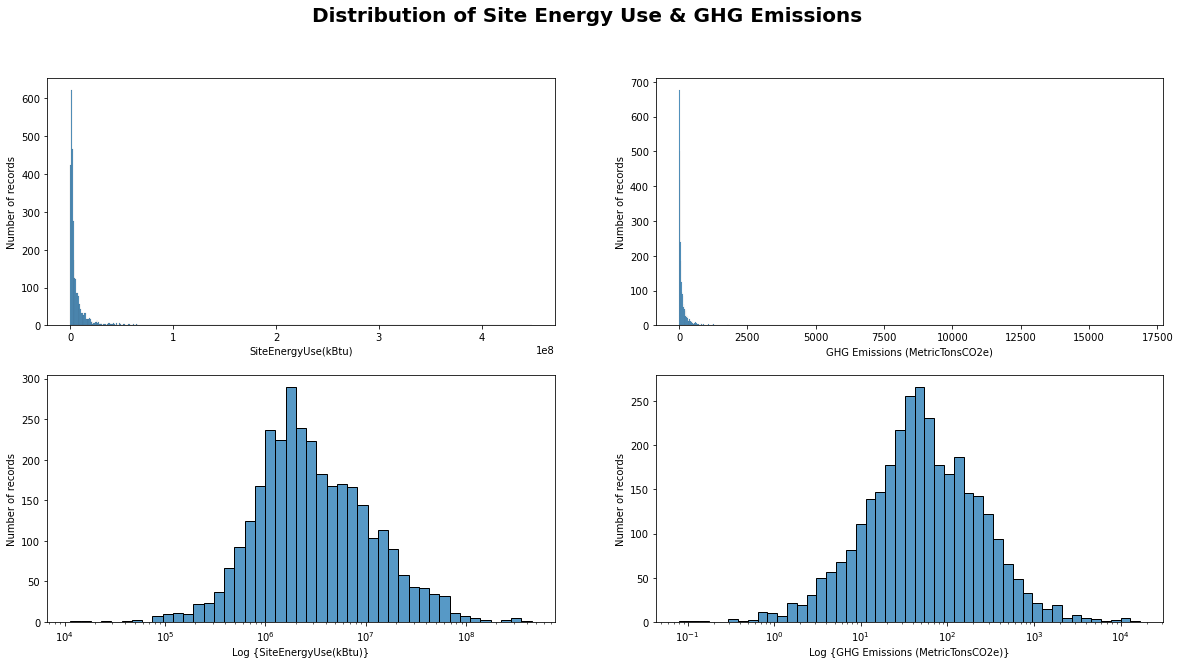

In [1152]:
fig, axes = plt.subplots(2, 2, figsize=(20,10))
fig.suptitle("Distribution of Site Energy Use & GHG Emissions", fontsize=18, weight = 'bold', size = 20)

sns.histplot(data=df_data_non_ener, x='SiteEnergyUse(kBtu)', ax=axes[0,0] ) 
axes[0,0].set_xlabel("SiteEnergyUse(kBtu)")
axes[0,0].set_ylabel("Number of records")

sns.histplot(data=df_data_non_ener, x='SiteEnergyUse(kBtu)', ax=axes[1,0] , log_scale=True) 
axes[1,0].set_xlabel("Log {SiteEnergyUse(kBtu)}")
axes[1,0].set_ylabel("Number of records")

sns.histplot(data=df_data_non_ener, x='GHGEmissions(MetricTonsCO2e)', ax=axes[0,1] ) 
axes[0,1].set_xlabel("GHG Emissions (MetricTonsCO2e)")
axes[0,1].set_ylabel("Number of records")

sns.histplot(data=df_data_non_ener, x='GHGEmissions(MetricTonsCO2e)', ax=axes[1,1] , log_scale=True) 
axes[1,1].set_xlabel("Log {GHG Emissions (MetricTonsCO2e)}")
axes[1,1].set_ylabel("Number of records")

plt.show()

Step 1: __DATA SELECTION__

In [1153]:
X = df_data_non_ener.drop(['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'LogSEU', 'LogGHG'], axis=1)
y = df_data_non_ener[['SiteEnergyUse(kBtu)','GHGEmissions(MetricTonsCO2e)', 'LogSEU', 'LogGHG']]


Step 2: __STANDARDIZATION & CATEGORICAL ENCODING__<br>

StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance. Unit variance means dividing all the values by the standard deviation. StandardScaler results in a distribution with a standard deviation equal to 1. <br>

Few Standardization are available in the Scikit-learn library. RobustScaler was tested (not shown here for clarity) on our cleaned data file to compare with StandardScaler but no significant outcome resulted.<br>

In addition to that, categorical data must be converted to numbers. A One Hot Encoding (OHE) is a representation of categorical variables as binary vectors.
It requires that the categorical values be mapped to integer values.
Then, each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1. <br> 
As we determined that our chosen categorical variables were not ordinal, we decided to go for OHE rather than Label encoding. No further sensitivity analysis were made for this project to compare impact from both encoding.

In [1154]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

scaler = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

cat_data = list(categorical_features.columns)
num_data = list(numerical_features.columns)
preprocessor = ColumnTransformer(transformers=
                                 [('num', scaler, num_data ),
                                  ('cat', categorical_transformer, cat_data)])

Step 3: __TRAIN-TEST SPLIT EVALUATION__<br>

The procedure involves taking a dataset and dividing it into two subsets. The first subset is used to fit the model and is referred to as the training dataset. The second subset is not used to train the model; instead, the input element of the dataset is provided to the model, then predictions are made and compared to the expected values. This second dataset is referred to as the test dataset.<br>
The objective is to estimate the performance of the machine learning model on new data: data not used to train the model.
We'll keep 80% of the data set for training and 20% for test. Sensitivity analysis was not performed neither on the split size nor on the random state in this project.

In [1155]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Step 4: __BASELINE CREATION__<br>

The Dummy Regressor is a kind of Regressor that gives prediction based on simple strategies without paying any attention to the input Data. The sklearn library provides Dummy Regressor which is used to set up a baseline for comparing different regressions. Training the dummy model is similar to training any regular regression model, except for the strategies. The main role of strategy is to predict target values without any influence of the training data.<br> We are here using the strategy "mean" which is the default strategy used by the Dummy Regressor. It always predicts the mean of the training target values.

In [1156]:
from sklearn.dummy import DummyRegressor

#Baseline for Site Energy Use
start_time0a = time.time()
dummy_reg = DummyRegressor(strategy="mean")
dummy_SEU = dummy_reg.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])
dummy_train_SEU = dummy_SEU.predict(X_train)
dummy_pred_SEU = dummy_SEU.predict(X_test)
tm0a = time.time() - start_time0a

In [1157]:
# Baseline for GHG Emissions
start_time0b = time.time()

dummy_GHG = dummy_reg.fit(X_train, Y_train['GHGEmissions(MetricTonsCO2e)'])
dummy_train_GHG = dummy_GHG.predict(X_train)
dummy_pred_GHG = dummy_GHG.predict(X_test)
tm0b = time.time() - start_time0b

To evaluate our regression model, we compute few meaningful parameters to estimate how far our predictions are from the actual data:

MAE (Mean Absolute Error) is the sum of absolute differences between our target and predicted variables. MAE is a common and simple metric that has the advantage of being in the same unit as our target, which means it can be compared to target values and easily interpreted.<br>

MSE (Mean Square Error) measures the average squared difference between the estimated values and the actual value.<br>

RMSE (Root Mean Square Error) is the standard deviation of the residuals.<br>

R² is the coefficient of determination and evaluates the scatter of the data points around the fitted regression line.



__Defining a function to see results better__

In [1158]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def algo_model(y_actual, y_forecast):
    """Return metrics for model evaluation in regression"""
    
    start_time = time.time()
    y_actual, y_forecast = np.array(y_actual), np.array(y_forecast)
    
    mse = mean_squared_error(y_actual, y_forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_actual, y_forecast)
    tm = time.time() - start_time
    
    functions = {"Functions":["Root Mean Squared Error (RMSE)",
                              "Mean Absolute Error (MAE)", "Coefficient of determination (R²)", "Running Time(s)"],
                              "Results":[rmse, mae, r2_score(y_actual, y_forecast), tm]}
    
    df_functions = pd.DataFrame(functions) 

    return df_functions

__A Baseline is set__

In [1159]:
dummy_metrics = algo_model(Y_test['SiteEnergyUse(kBtu)'], dummy_pred_SEU).rename(columns={'Results':'Baseline'})
dummy_metrics.index = np.arange(1, len(dummy_metrics)+1)
dummy_metrics


,Functions,Baseline
1,Root Mean Squared Error (RMSE),1.872051e+07
2,Mean Absolute Error (MAE),8.592903e+06
3,Coefficient of determination (R²),-1.552097e-05
4,Running Time(s),9.996891e-04


In [1160]:
# Site SEU metrics
MAE_train0a = mean_absolute_error(Y_train['SiteEnergyUse(kBtu)'], dummy_train_SEU)
r2_train0a = r2_score(Y_train['SiteEnergyUse(kBtu)'], dummy_train_SEU)
RMSE_train0a = np.sqrt(mean_squared_error(Y_train['SiteEnergyUse(kBtu)'], dummy_train_SEU))

MAE_test0a = mean_absolute_error(Y_test['SiteEnergyUse(kBtu)'], dummy_pred_SEU)
r2_test0a = r2_score(Y_test['SiteEnergyUse(kBtu)'], dummy_pred_SEU)
RMSE_test0a = np.sqrt(mean_squared_error(Y_test['SiteEnergyUse(kBtu)'], dummy_pred_SEU))

# GHG Emissions
MAE_train_00 = mean_absolute_error(Y_train['GHGEmissions(MetricTonsCO2e)'], dummy_train_GHG)
r2_train_00 = r2_score(Y_train['GHGEmissions(MetricTonsCO2e)'], dummy_train_GHG)
RMSE_train_00 = np.sqrt(mean_squared_error(Y_train['GHGEmissions(MetricTonsCO2e)'], dummy_train_GHG))

MAE_test_00 = mean_absolute_error(Y_test['GHGEmissions(MetricTonsCO2e)'], dummy_pred_GHG)
r2_test_00 = r2_score(Y_test['GHGEmissions(MetricTonsCO2e)'], dummy_pred_GHG)
RMSE_test_00 = np.sqrt(mean_squared_error(Y_test['GHGEmissions(MetricTonsCO2e)'], dummy_pred_GHG))

### 2-1) LINEAR REGRESSION MODELS - LINEAR & LOG SCALE

While running the multiple regressions - listed above - on train et test data respectively, we'll plot the targeted values v the predicted ones just to have a graphic visualization of our fits and we'll display the metrics we have chosen. At the end, we'll create a dataframe and discuss the associated results.

#### SITE ENERGY USE - LINEAR REGRESSION ON TRAINING DATA

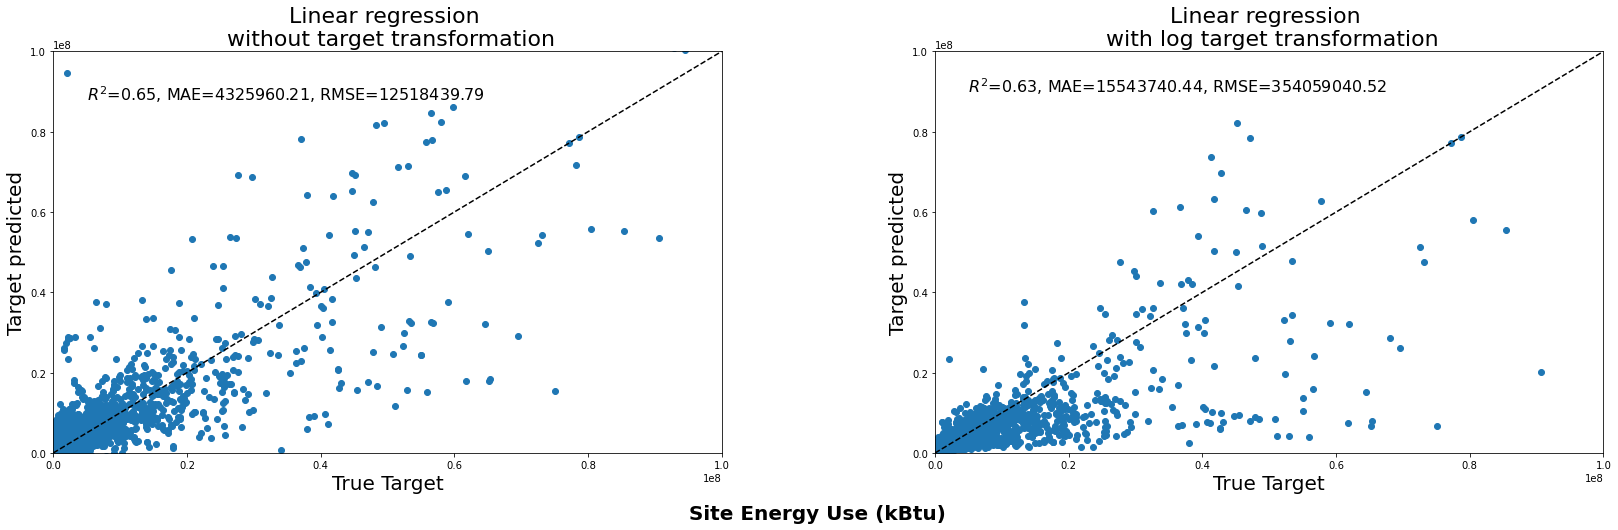

In [1161]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=False)

# Use linear model & linear scale
start_time1 = time.time()

pipe_lin = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', LinearRegression())])

X = df_data_non_ener[num_data + cat_data]

pipe_lin.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])

Y_pred = pipe_lin.predict(X_train)
tm1 = time.time() - start_time1

# Plot results
ax0.scatter(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('Linear regression \n without target transformation', size = 22)

r2_train1 = r2_score(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
MAE_train1 = mean_absolute_error(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
RMSE_train1 = np.sqrt(mean_squared_error(Y_train['SiteEnergyUse(kBtu)'], Y_pred))
ax0.text(5e6, 8.8e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train1, MAE_train1, RMSE_train1), fontsize = 16)
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# Transform targets and use same linear model

start_time_1 = time.time()
pipe_lin.fit(X_train, Y_train['LogSEU'])

Y_log_pred = pipe_lin.predict(X_train)
Y_pred = np.expm1(Y_log_pred)
tm_1 = time.time() - start_time_1

# Plot results
ax1.scatter(np.expm1(Y_train['LogSEU']), Y_pred)

ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('Linear regression \n with log target transformation', size = 22)

r2_train_1 = r2_score(Y_train['LogSEU'], Y_log_pred)
MAE_train_1 = mean_absolute_error(Y_train['LogSEU'], np.expm1(Y_log_pred))
RMSE_train_1 = np.sqrt(mean_squared_error(Y_train['LogSEU'], np.expm1(Y_log_pred)))
ax1.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train_1, MAE_train_1, RMSE_train_1), size = 16)
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])

f.suptitle("Site Energy Use (kBtu) ", x = 1.15, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])


#### SITE ENERGY USE - LINEAR REGRESSION ON TESTING DATA

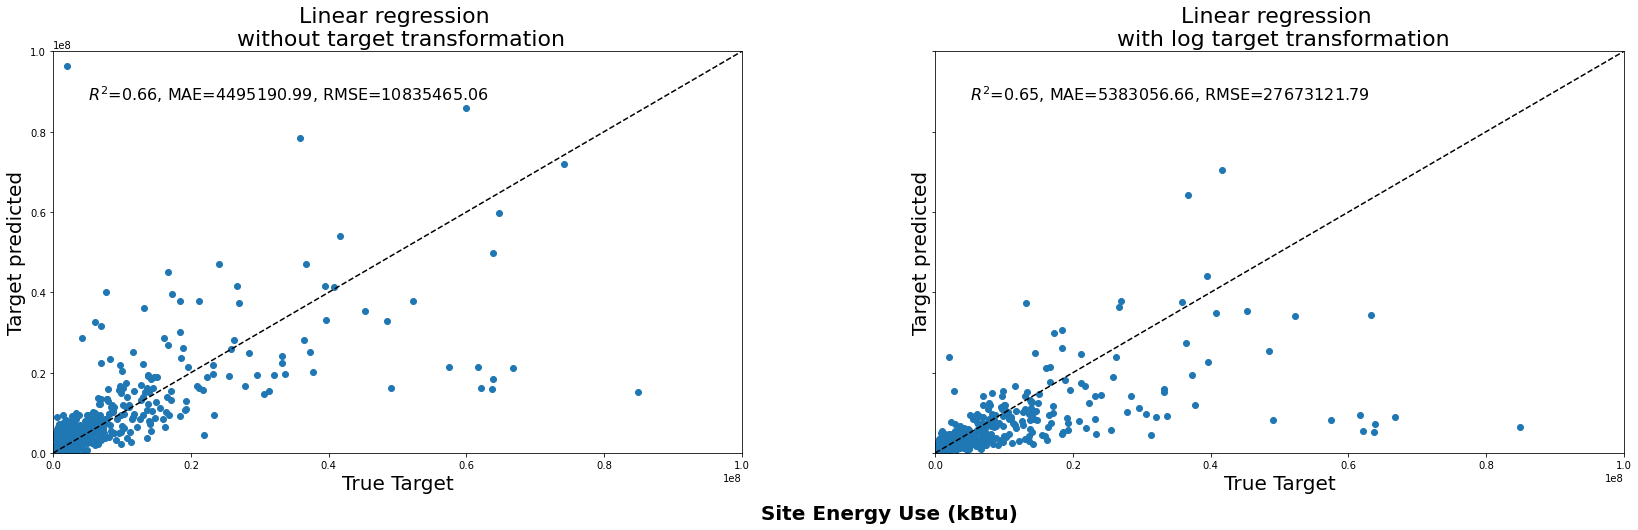

In [1162]:
from sklearn.pipeline import Pipeline

f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use linear model & linear scale
start_time11 = time.time()

pipe_lin = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', LinearRegression())])

X = df_data_non_ener[num_data + cat_data]

pipe_lin.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])

Y_pred = pipe_lin.predict(X_test)
tm11 = time.time() - start_time11

# Plot results
ax0.scatter(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('Linear regression \n without target transformation', size = 22)
r2_test11 = r2_score(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
MAE_test11 = mean_absolute_error(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
RMSE_test11 = np.sqrt(mean_squared_error(Y_test['SiteEnergyUse(kBtu)'], Y_pred))
ax0.text(5e6, 8.8e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test11, MAE_test11, RMSE_test11), size = 16)
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# Transform targets and use same linear model

start_time_11 = time.time()
pipe_lin.fit(X_train, Y_train['LogSEU'])

Y_pred = pipe_lin.predict(X_test)
tm_11 = time.time() - start_time_11

# Plot results
ax1.scatter(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred))
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('Linear regression \n with log target transformation', size = 22)
r2_test_11 = r2_score(Y_test['LogSEU'], Y_pred)
MAE_test_11 = mean_absolute_error(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred))
RMSE_test_11 = np.sqrt(mean_squared_error(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred)))
ax1.text(5e6, 8.8e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test_11, MAE_test_11, RMSE_test_11), size = 16)
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])

f.suptitle("Site Energy Use (kBtu) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])


#### GHG EMISSIONS - LINEAR REGRESSION ON TRAINING DATA

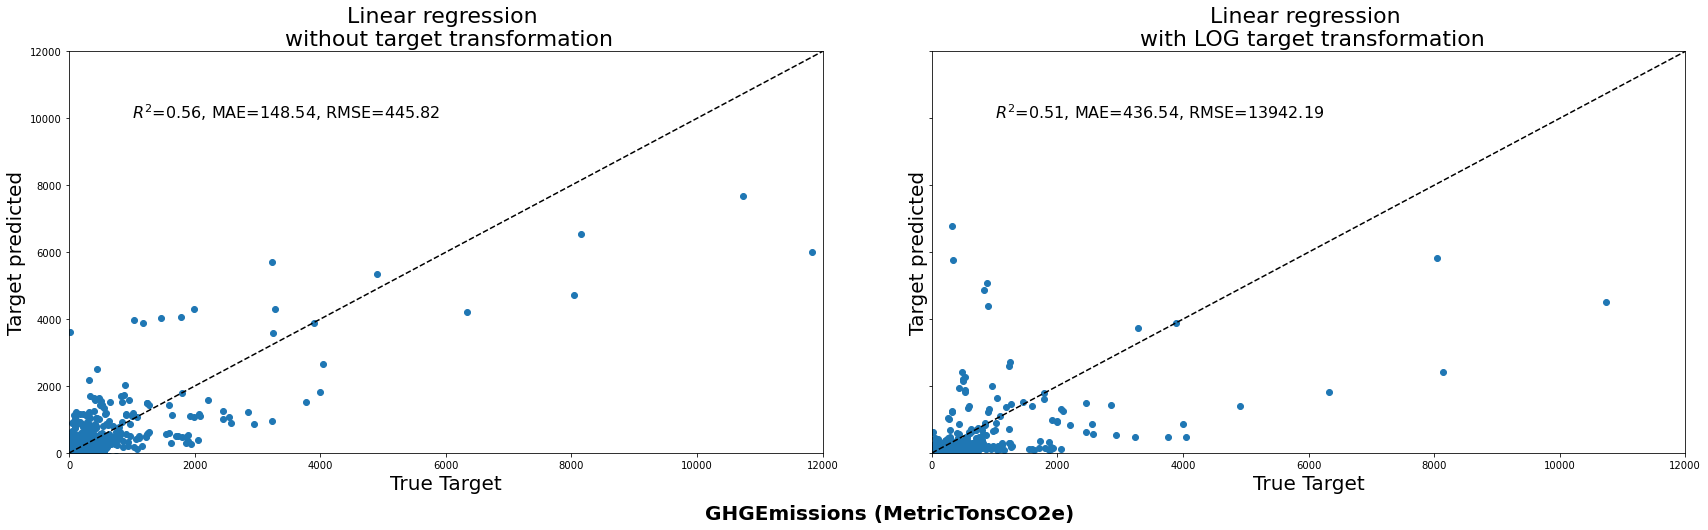

In [1163]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use linear model
start_time1b = time.time()

pipe_lin.fit(X_train, Y_train['GHGEmissions(MetricTonsCO2e)'])

Y_pred = pipe_lin.predict(X_train)
tm1b = time.time() - start_time1b

# Plot results
ax0.scatter(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
ax0.plot([0, 12e3], [0, 12e3], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('Linear regression \n without target transformation', size = 22)
r2_train1b = r2_score(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
MAE_train1b = mean_absolute_error(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
RMSE_train1b = np.sqrt(mean_squared_error(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred))
ax0.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train1b, MAE_train1b, RMSE_train1b), size = 16)
ax0.set_xlim([0, 12e3])
ax0.set_ylim([0, 12e3])

# #######################################################################################
# Transform targets and use same linear model
start_time_1b = time.time()

pipe_lin.fit(X_train, Y_train['LogGHG'])
Y_pred = pipe_lin.predict(X_train)
tm_1b = time.time() - start_time_1b

ax1.scatter(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred))
ax1.plot([0, 12e3], [0, 12e3], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('Linear regression \n with LOG target transformation', size = 22)
r2_train_1b = r2_score(Y_train['LogGHG'], Y_pred)
MAE_train_1b = mean_absolute_error(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred))
RMSE_train_1b = np.sqrt(mean_squared_error(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred)))
ax1.text(1e3, 1e4, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train_1b, MAE_train_1b, RMSE_train_1b), size = 16)
ax1.set_xlim([0, 12e3])
ax1.set_ylim([0, 12e3])

f.suptitle("GHGEmissions (MetricTonsCO2e) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])


#### GHG EMISSIONS - LINEAR REGRESSION ON TESTING DATA

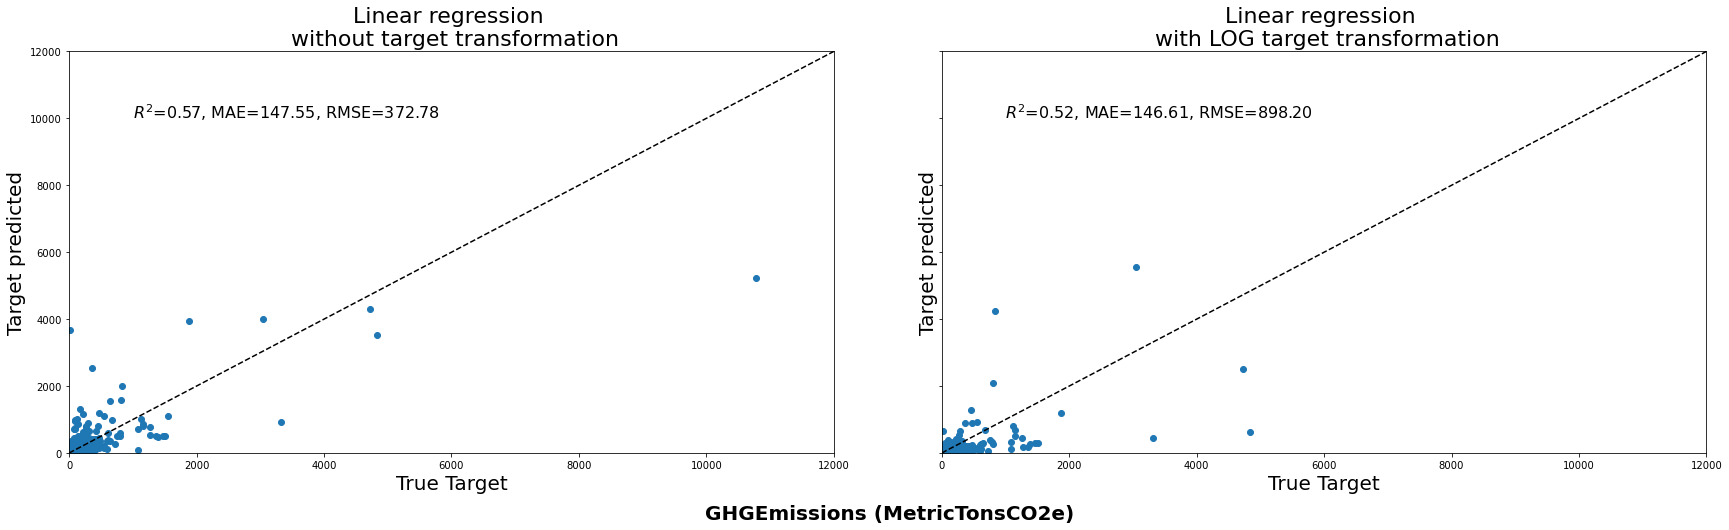

In [1164]:

f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use linear model
start_time11b = time.time()

pipe_lin.fit(X_train, Y_train['GHGEmissions(MetricTonsCO2e)'])

Y_pred = pipe_lin.predict(X_test)
tm11b = time.time() - start_time11b

# Plot results
ax0.scatter(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
ax0.plot([0, 12e3], [0, 12e3], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('Linear regression \n without target transformation', size = 22)
r2_test11b = r2_score(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
MAE_test11b = mean_absolute_error(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
RMSE_test11b = np.sqrt(mean_squared_error(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred))
ax0.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test11b, MAE_test11b, RMSE_test11b), size = 16)
ax0.set_xlim([0, 12e3])
ax0.set_ylim([0, 12e3])

# ######################################################################################
# Transform targets and use same linear model
start_time_11b = time.time()

pipe_lin.fit(X_train, Y_train['LogGHG'])
Y_pred = pipe_lin.predict(X_test)
tm_11b = time.time() - start_time_11b

ax1.scatter(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred))
ax1.plot([0, 12e3], [0, 12e3], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('Linear regression \n with LOG target transformation', size = 22)
r2_test_11b = r2_score(Y_test['LogGHG'], Y_pred)
MAE_test_11b = mean_absolute_error(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred))
RMSE_test_11b = np.sqrt(mean_squared_error(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred)))
ax1.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test_11b, MAE_test_11b, RMSE_test_11b), size = 16)
ax1.set_xlim([0, 12e3])
ax1.set_ylim([0, 12e3])

f.suptitle("GHGEmissions (MetricTonsCO2e) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])


### 2-2) LASSO REGRESSION - LINEAR & LOG SCALE COMPARISON<br>

Lasso regression, or the Least Absolute Shrinkage and Selection Operator, is also a modification of linear regression. In Lasso, the loss function is modified to minimize the complexity of the model by limiting the sum of the absolute values of the model coefficients (also called the l1-norm).
GridSearchCV is a library function that is a member of sklearn's model_selection package. It helps to loop through predefined hyperparameters and fit our estimator (model) on our training set. So, in the end, we can select the best parameters from the listed hyperparameters.

#### SITE ENERGY USE - LASSO REGRESSION ON TRAINING DATA

Best parameters lin scale: {'regressor__alpha': 10.0, 'regressor__max_iter': 10}
Best parameters log scale: {'regressor__alpha': 0.0001, 'regressor__max_iter': 1000}


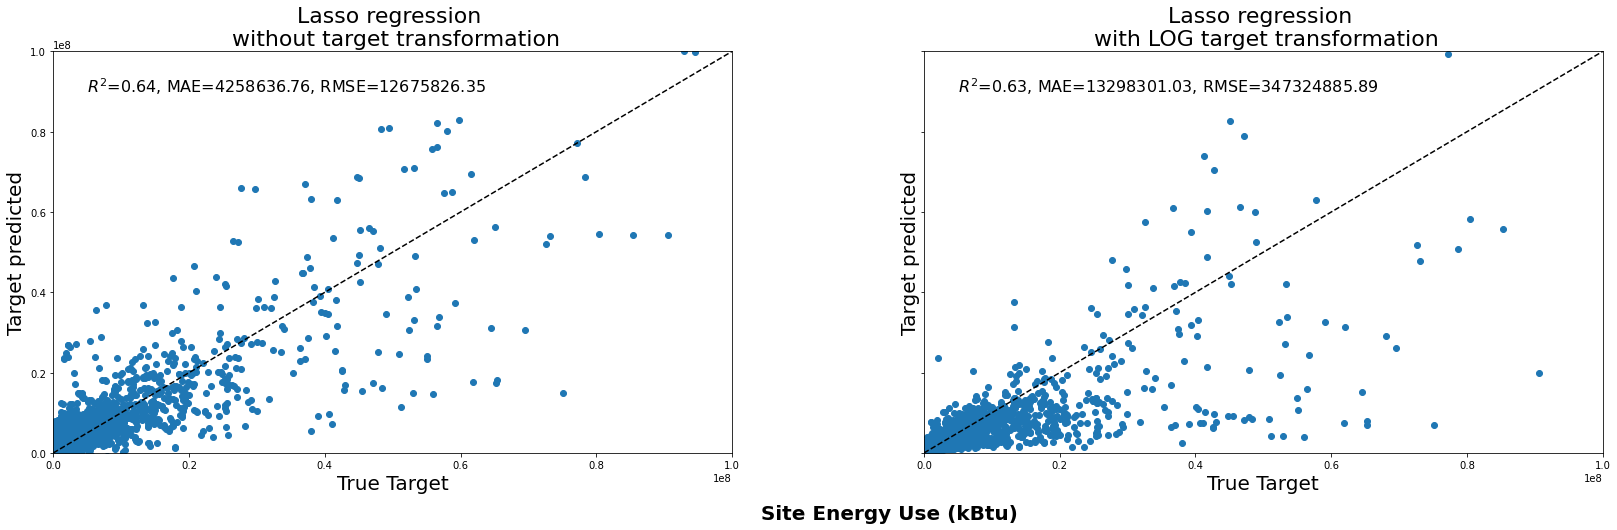

In [1165]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use Lasso model
start_time2 = time.time()
pipe_lasso = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', Lasso())])

# Hyperparameters to tune
params_lasso = {"regressor__alpha": np.logspace(-4, 1, num=6), # Constant that multiplies the L1 term (default=1)
               "regressor__max_iter": [10, 50, 100, 1000]} # maximum number of iterations.

lasso_grid_cv = GridSearchCV(pipe_lasso, 
                       param_grid=params_lasso, # Dictionary with parameters names
                       cv=5, # Determines the cross-validation splitting strategy
                       scoring=('r2','neg_mean_absolute_error'), # Strategy to evaluate the performance of the cross-validated model on the train set
                       return_train_score = True, # If False, the cv_results_ attribute will not include training scores
                       refit='neg_mean_absolute_error', #Refit an estimator using the best found parameters on the whole dataset
                       n_jobs = -1) # Number of jobs to run in parallel


lasso_SEU = lasso_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])

Y_pred = lasso_SEU.predict(X_train)
tm2 = time.time() - start_time2

# Plot results
ax0.scatter(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('Lasso regression \n without target transformation', size = 22)
r2_train2 = r2_score(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
MAE_train2 = mean_absolute_error(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
RMSE_train2 = np.sqrt(mean_squared_error(Y_train['SiteEnergyUse(kBtu)'], Y_pred))
ax0.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train2, MAE_train2, RMSE_train2), size = 16)
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# ##########################################################################################
# Transform targets and use same Lasso model
start_time_2 = time.time()

lasso_grid_cvlog = GridSearchCV(pipe_lasso, 
                       param_grid=params_lasso, 
                       cv=5, 
                       scoring=('r2','neg_mean_absolute_error'), 
                       return_train_score = True, 
                       refit='neg_mean_absolute_error', 
                       n_jobs = -1) 

lasso_SEU_log = lasso_grid_cvlog.fit(X_train, Y_train['LogSEU'])
Y_pred = lasso_SEU_log.predict(X_train)
tm_2 = time.time() - start_time_2
ax1.scatter(np.expm1(Y_train['LogSEU']), np.expm1(Y_pred))
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('Lasso regression \n with LOG target transformation', size = 22)
r2_train_2 = r2_score(Y_train['LogSEU'], Y_pred)
MAE_train_2 = mean_absolute_error(np.expm1(Y_train['LogSEU']),np.expm1(Y_pred))
RMSE_train_2 = np.sqrt(mean_squared_error(np.expm1(Y_train['LogSEU']), np.expm1(Y_pred)))
ax1.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train_2, MAE_train_2, RMSE_train_2), size = 16)
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])


f.suptitle("Site Energy Use (kBtu) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', lasso_SEU.best_params_)
print('Best parameters log scale:', lasso_SEU_log.best_params_)


#### SITE ENERGY USE - LASSO REGRESSION ON TESTING DATA

Best parameters lin scale: {'regressor__alpha': 10.0, 'regressor__max_iter': 10}
Best parameters log scale: {'regressor__alpha': 0.0001, 'regressor__max_iter': 1000}


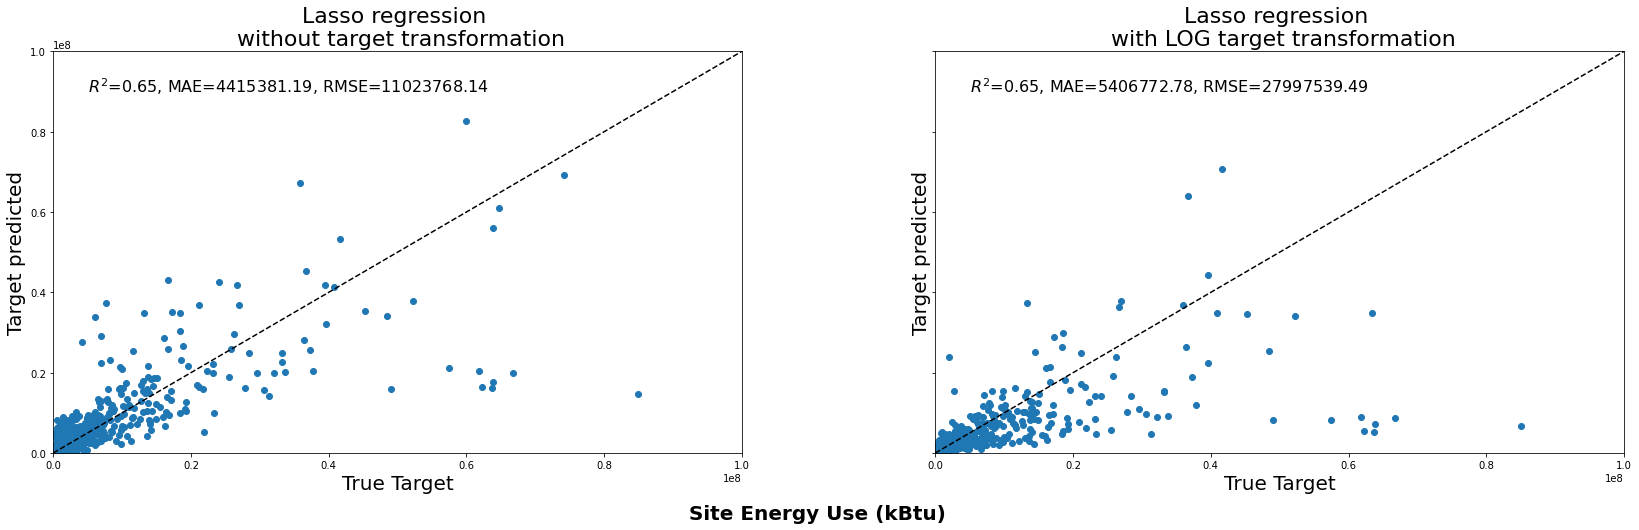

In [1166]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use Lasso model
start_time22 = time.time()
pipe_lasso = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', Lasso())])

# Hyperparameters to tune
params_lasso = {"regressor__alpha": np.logspace(-4, 1, num=6), # Constant that multiplies the L1 term (default=1)
               "regressor__max_iter": [10, 50, 100, 1000]} # maximum number of iterations.

lasso_grid_cv = GridSearchCV(pipe_lasso, 
                       param_grid=params_lasso, # Dictionary with parameters names
                       cv=5, # Determines the cross-validation splitting strategy
                       scoring=('r2','neg_mean_absolute_error'), # Strategy to evaluate the performance of the cross-validated model on the test set
                       return_train_score = True, # If False, the cv_results_ attribute will not include training scores
                       refit='neg_mean_absolute_error', #Refit an estimator using the best found parameters on the whole dataset
                       n_jobs = -1) # Number of jobs to run in parallel

lasso_SEU = lasso_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])

Y_pred = lasso_SEU.predict(X_test)
tm22 = time.time() - start_time22

# Plot results
ax0.scatter(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('Lasso regression \n without target transformation', size = 22)
r2_test22 = r2_score(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
MAE_test22 = mean_absolute_error(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
RMSE_test22 = np.sqrt(mean_squared_error(Y_test['SiteEnergyUse(kBtu)'], Y_pred))
ax0.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test22, MAE_test22, RMSE_test22), size = 16)
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# #########################################################################################
# Transform targets and use same Lasso model
start_time_22 = time.time()

lasso_grid_cvlog = GridSearchCV(pipe_lasso, 
                       param_grid=params_lasso, # Dictionary with parameters names
                       cv=5, # Determines the cross-validation splitting strategy
                       scoring=('r2','neg_mean_absolute_error'), # Strategy to evaluate the performance of the cross-validated model on the train set
                       return_train_score = True, # If False, the cv_results_ attribute will not include training scores
                       refit='neg_mean_absolute_error', #Refit an estimator using the best found parameters on the whole dataset
                       n_jobs = -1) # Number of jobs to run in parallel

lasso_SEU_log = lasso_grid_cvlog.fit(X_train, Y_train['LogSEU'])
Y_pred = lasso_SEU_log.predict(X_test)
tm_22 = time.time() - start_time_22
ax1.scatter(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred))
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('Lasso regression \n with LOG target transformation', size = 22)
r2_test_22 = r2_score(Y_test['LogSEU'], Y_pred)
MAE_test_22 = mean_absolute_error(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred))
RMSE_test_22 = np.sqrt(mean_squared_error(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred)))
ax1.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test_22, MAE_test_22, RMSE_test_22), size = 16)
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])

f.suptitle("Site Energy Use (kBtu) ", x = 1.15, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', lasso_SEU.best_params_)
print('Best parameters log scale:', lasso_SEU_log.best_params_)


#### GHG EMISSIONS - LASSO REGRESSION ON TRAINING DATA

Best parameters lin scale: {'regressor__alpha': 1.0, 'regressor__max_iter': 10}
Best parameters log scale: {'regressor__alpha': 0.0001, 'regressor__max_iter': 1000}


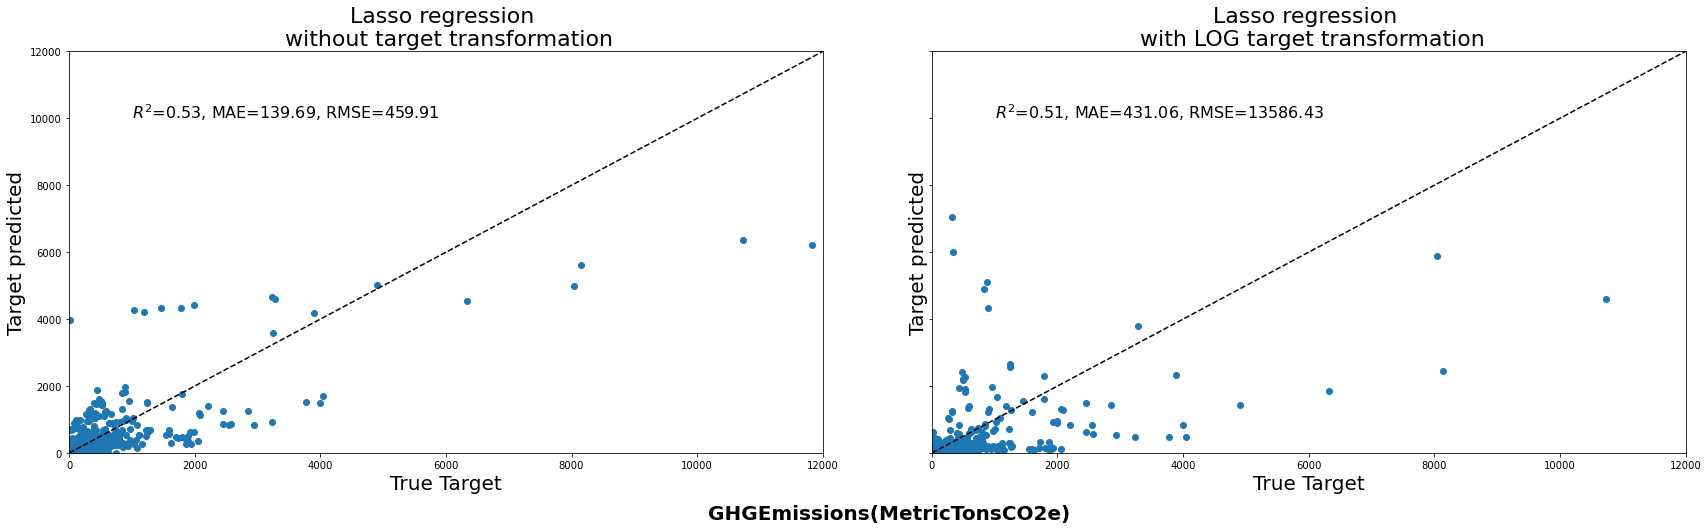

In [1167]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use Lasso model
start_time2b = time.time()

lasso_GHG = lasso_grid_cv.fit(X_train, Y_train['GHGEmissions(MetricTonsCO2e)'])

Y_pred = lasso_GHG.predict(X_train)
tm2b = time.time() - start_time2b

# Plot results
ax0.scatter(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
ax0.plot([0, 12e3], [0, 12e3], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('Lasso regression \n without target transformation', size = 22)
r2_train2b = r2_score(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
MAE_train2b = mean_absolute_error(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
RMSE_train2b = np.sqrt(mean_squared_error(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred))
ax0.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train2b, MAE_train2b, RMSE_train2b), size = 16)
ax0.set_xlim([0, 12e3])
ax0.set_ylim([0, 12e3])

# ###################################################################################
# Transform targets and use same Lasso model
start_time_2b = time.time()

lasso_GHG_log = lasso_grid_cvlog.fit(X_train, Y_train['LogGHG'])
Y_pred = lasso_GHG_log.predict(X_train)
tm_2b = time.time() - start_time_2b
ax1.scatter(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred))
ax1.plot([0, 12e3], [0, 12e3], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('Lasso regression \n with LOG target transformation', size = 22)
r2_train_2b = r2_score(Y_train['LogGHG'], Y_pred)
MAE_train_2b = mean_absolute_error(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred))
RMSE_train_2b = np.sqrt(mean_squared_error(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred)))
ax1.text(1e3, 1e4, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train_2b, MAE_train_2b, RMSE_train_2b), size = 16)
ax1.set_xlim([0, 12e3])
ax1.set_ylim([0, 12e3])


f.suptitle("GHGEmissions(MetricTonsCO2e) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', lasso_GHG.best_params_)
print('Best parameters log scale:', lasso_GHG_log.best_params_)
#print('Best parameters log scale : {}'.format(lasso_GHG_log.named_steps['grid_lasso'].best_params_))

#### GHG EMISSIONS - LASSO REGRESSION ON TEST DATA

Best parameters lin scale: {'regressor__alpha': 1.0, 'regressor__max_iter': 10}
Best parameters log scale: {'regressor__alpha': 0.0001, 'regressor__max_iter': 1000}


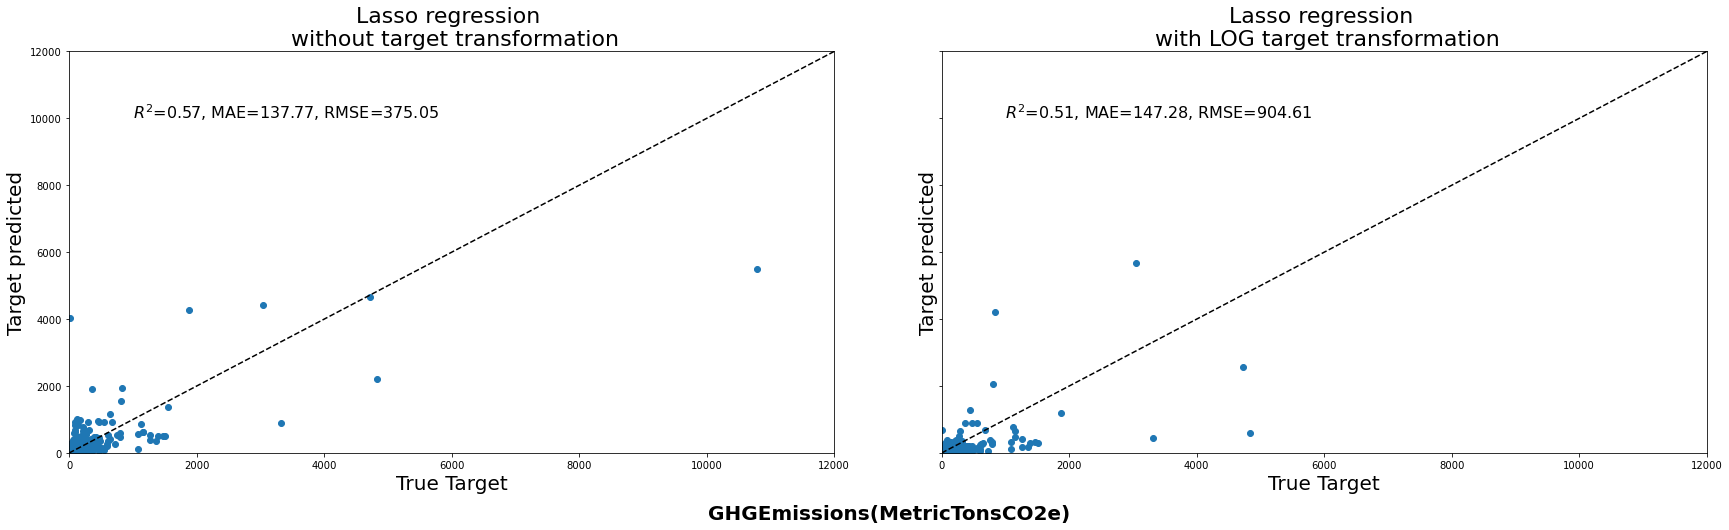

In [1168]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use Lasso model
start_time22b = time.time()

lasso_GHG = lasso_grid_cv.fit(X_train, Y_train['GHGEmissions(MetricTonsCO2e)'])

Y_pred = lasso_GHG.predict(X_test)
tm22b = time.time() - start_time22b

# Plot results
ax0.scatter(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
ax0.plot([0, 12e3], [0, 12e3], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('Lasso regression \n without target transformation', size = 22)
r2_test22b = r2_score(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
MAE_test22b = mean_absolute_error(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
RMSE_test22b = np.sqrt(mean_squared_error(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred))
ax0.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test22b, MAE_test22b, RMSE_test22b), size = 16)
ax0.set_xlim([0, 12e3])
ax0.set_ylim([0, 12e3])

# ####################################################################################
# Transform targets and use same Lasso model
start_time_22b = time.time()

lasso_GHG_log = lasso_grid_cvlog.fit(X_train, Y_train['LogGHG'])
Y_pred = lasso_GHG_log.predict(X_test)
tm_22b = time.time() - start_time_22b
ax1.scatter(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred))
ax1.plot([0, 12e3], [0, 12e3], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('Lasso regression \n with LOG target transformation', size = 22)
r2_test_22b = r2_score(Y_test['LogGHG'], Y_pred)
MAE_test_22b = mean_absolute_error(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred))
RMSE_test_22b = np.sqrt(mean_squared_error(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred)))
ax1.text(1e3, 1e4, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test_22b, MAE_test_22b, RMSE_test_22b), size = 16)
ax1.set_xlim([0, 12e3])
ax1.set_ylim([0, 12e3])

f.suptitle("GHGEmissions(MetricTonsCO2e) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', lasso_GHG.best_params_)
print('Best parameters log scale:', lasso_GHG_log.best_params_)


### 2-3) RIDGE REGRESSION

Ridge regression is an extension of linear regression where the loss function is modified to minimize the complexity of the model. This modification is done by adding a penalty parameter that is equivalent to the square of the magnitude of the coefficients.

#### SITE ENERGY USE - RIDGE REGRESSION ON TRAINING DATA

Best parameters lin scale: {'regressor__alpha': 10.0, 'regressor__max_iter': 50}
Best parameters log scale: {'regressor__alpha': 1.0, 'regressor__max_iter': 50}


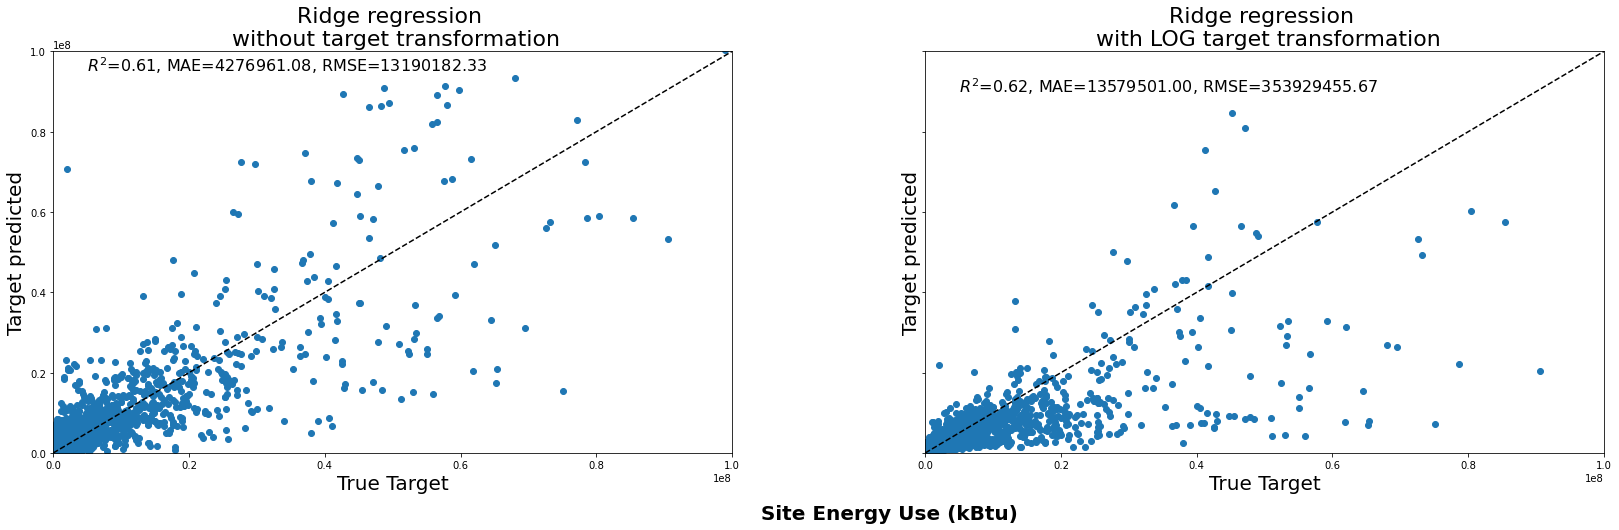

In [1169]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use Ridge model
start_time3 = time.time()
pipe_ridge = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', Ridge())])

params_ridge = {"regressor__alpha": np.logspace(-4, 1, num=6), # Regularization strength; must be a positive float (default=1)
                "regressor__max_iter": [10, 50, 100, 1000]} # Max number of iterations
             

grid_ridge = GridSearchCV(pipe_ridge, param_grid=params_ridge, cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1)

ridge_SEU = grid_ridge.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])

Y_pred = ridge_SEU.predict(X_train)
tm3 = time.time() - start_time3

# Plot results
ax0.scatter(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('Ridge regression \n without target transformation', size = 22)
r2_train3 = r2_score(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
MAE_train3 = mean_absolute_error(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
RMSE_train3 = np.sqrt(mean_squared_error(Y_train['SiteEnergyUse(kBtu)'], Y_pred))
ax0.text(5e6, 9.5e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train3, MAE_train3, RMSE_train3), size = 16)
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# #####################################################################################
# Transform targets and use same Ridge model
start_time_3 = time.time()

grid_ridge_log = GridSearchCV(pipe_ridge, param_grid=params_ridge, cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1)

ridge_SEU_log = grid_ridge_log.fit(X_train, Y_train['LogSEU'])
Y_pred = ridge_SEU_log.predict(X_train)

ax1.scatter(np.expm1(Y_train['LogSEU']), np.expm1(Y_pred))
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('Ridge regression \n with LOG target transformation', size = 22)
r2_train_3 = r2_score(Y_train['LogSEU'], Y_pred)
MAE_train_3 = mean_absolute_error(np.expm1(Y_train['LogSEU']), np.expm1(Y_pred))
RMSE_train_3 = np.sqrt(mean_squared_error(np.expm1(Y_train['LogSEU']), np.expm1(Y_pred)))
ax1.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train_3, MAE_train_3, RMSE_train_3), size = 16)
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])
tm_3 = time.time() - start_time_3

f.suptitle("Site Energy Use (kBtu) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', ridge_SEU.best_params_)
print('Best parameters log scale:', ridge_SEU_log.best_params_)


#### SITE ENERGY USE - RIDGE REGRESSION ON TEST DATA

Best parameters lin scale: {'regressor__alpha': 10.0, 'regressor__max_iter': 50}
Best parameters log scale: {'regressor__alpha': 1.0, 'regressor__max_iter': 50}


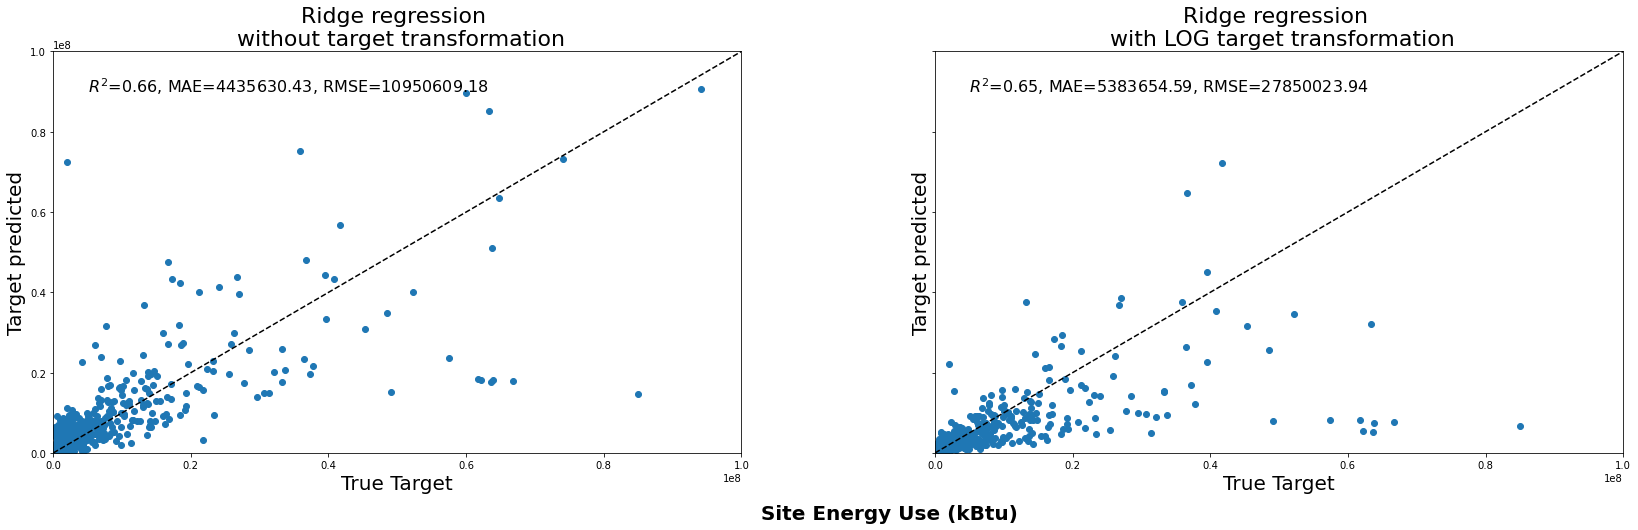

In [1170]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use Ridge model
start_time33 = time.time()
pipe_ridge = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', Ridge())])

params_ridge = {"regressor__alpha": np.logspace(-4, 1, num=6), # Regularization strength; must be a positive float (default=1)
                "regressor__max_iter": [10, 50, 100, 1000]} # Max number of iterations
             

grid_ridge = GridSearchCV(pipe_ridge, param_grid=params_ridge, cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1)

ridge_SEU = grid_ridge.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])

Y_pred = ridge_SEU.predict(X_test)
tm33 = time.time() - start_time33

# Plot results
ax0.scatter(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('Ridge regression \n without target transformation', size = 22)
r2_test33 = r2_score(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
MAE_test33 = mean_absolute_error(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
RMSE_test33 = np.sqrt(mean_squared_error(Y_test['SiteEnergyUse(kBtu)'], Y_pred))
ax0.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test33, MAE_test33, RMSE_test33), size = 16)
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# #####################################################################################
# Transform targets and use same Ridge model
start_time_33 = time.time()

grid_ridge_log = GridSearchCV(pipe_ridge, param_grid=params_ridge, cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1)

ridge_SEU_log = grid_ridge_log.fit(X_train, Y_train['LogSEU'])
Y_pred = ridge_SEU_log.predict(X_test)

ax1.scatter(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred))
ax1.plot([0, 1e8], [0 , 1e8], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('Ridge regression \n with LOG target transformation', size = 22)
r2_test_33 = r2_score(Y_test['LogSEU'], Y_pred)
MAE_test_33 = mean_absolute_error(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred))
RMSE_test_33 = np.sqrt(mean_squared_error(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred)))
ax1.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test_33, MAE_test_33, RMSE_test_33), size = 16)
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])
tm_33 = time.time() - start_time_33

f.suptitle("Site Energy Use (kBtu) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', ridge_SEU.best_params_)
print('Best parameters log scale:', ridge_SEU_log.best_params_)


#### GHG EMISSIONS - RIDGE REGRESSION ON TRAINING DATA

Best parameters lin scale: {'regressor__alpha': 10.0, 'regressor__max_iter': 50}
Best parameters log scale: {'regressor__alpha': 1.0, 'regressor__max_iter': 50}


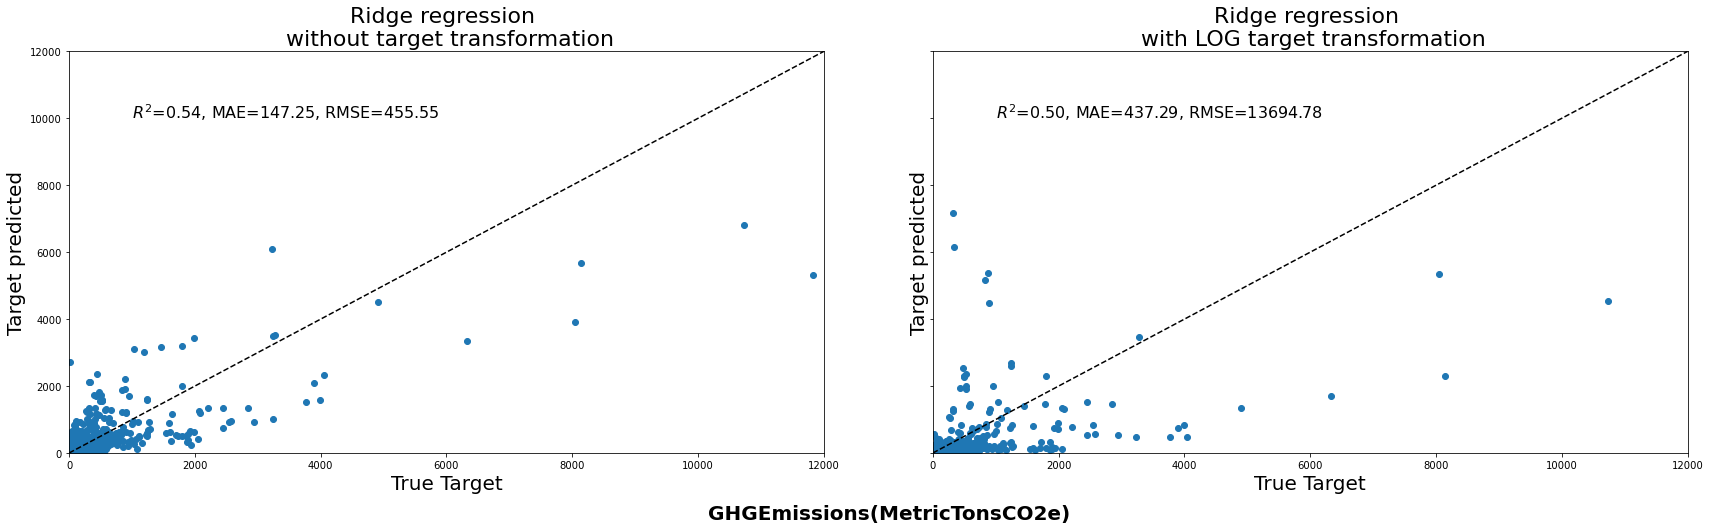

In [1171]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use Ridge model
start_time3b = time.time()

ridge_GHG = grid_ridge.fit(X_train, Y_train['GHGEmissions(MetricTonsCO2e)'])

Y_pred = ridge_GHG.predict(X_train)
tm3b = time.time() - start_time3b

# Plot results
ax0.scatter(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
ax0.plot([0, 12e3], [0, 12e3], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('Ridge regression \n without target transformation', size = 22)
r2_train3b = r2_score(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
MAE_train3b = mean_absolute_error(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
RMSE_train3b = np.sqrt(mean_squared_error(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred))
ax0.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train3b, MAE_train3b, RMSE_train3b), size = 16)
ax0.set_xlim([0, 12e3])
ax0.set_ylim([0, 12e3])

# ####################################################################################
# Transform targets and use same Ridge model
start_time_3b = time.time()

ridge_GHG_log = grid_ridge_log.fit(X_train, Y_train['LogGHG'])
Y_pred = ridge_GHG_log.predict(X_train)

ax1.scatter(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred))
ax1.plot([0, 12e3], [0, 12e3], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('Ridge regression \n with LOG target transformation', size = 22)
r2_train_3b = r2_score(Y_train['LogGHG'], Y_pred)
MAE_train_3b = mean_absolute_error(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred))
RMSE_train_3b = np.sqrt(mean_squared_error(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred)))
ax1.text(1e3, 1e4, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train_3b, MAE_train_3b, RMSE_train_3b), size = 16)
ax1.set_xlim([0, 12e3])
ax1.set_ylim([0, 12e3])

tm_3b = time.time() - start_time_3b

f.suptitle("GHGEmissions(MetricTonsCO2e) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', ridge_GHG.best_params_)
print('Best parameters log scale:', ridge_GHG_log.best_params_)


#### GHG EMISSIONS - RIDGE REGRESSION ON TEST DATA

Best parameters lin scale: {'regressor__alpha': 10.0, 'regressor__max_iter': 50}
Best parameters log scale: {'regressor__alpha': 10.0, 'regressor__max_iter': 50}


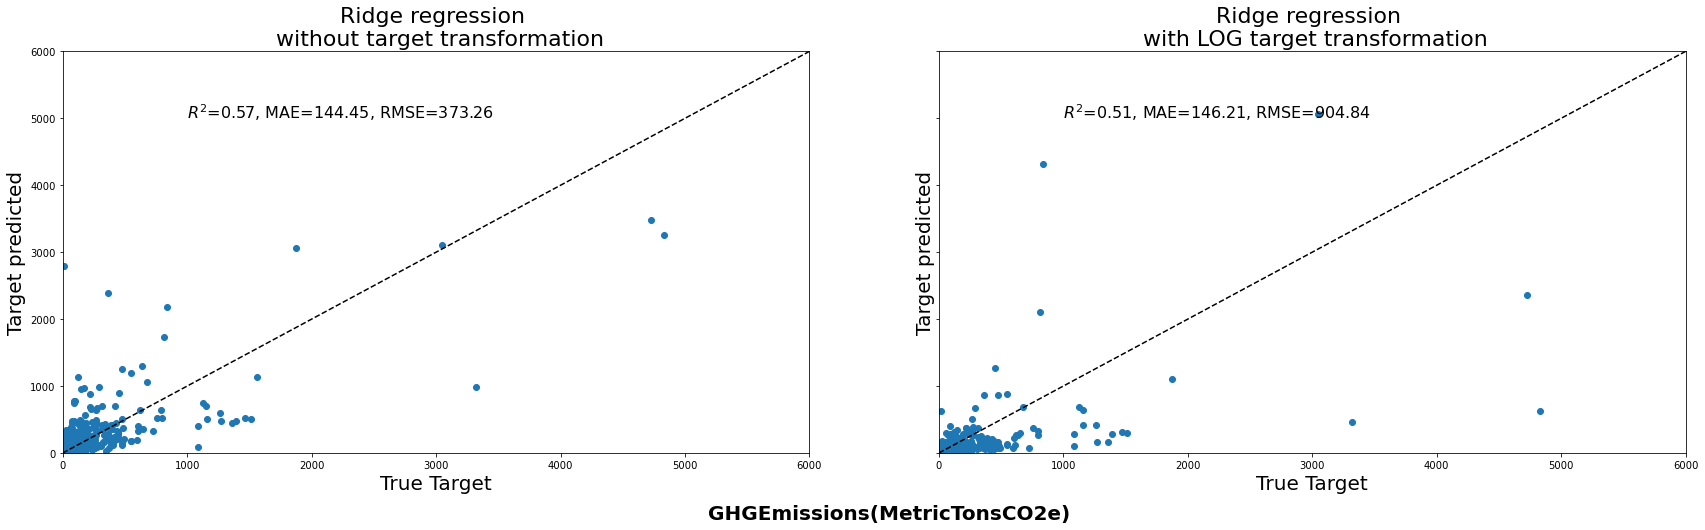

In [1172]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use Ridge model
start_time33b = time.time()

ridge_GHG = grid_ridge.fit(X_train, Y_train['GHGEmissions(MetricTonsCO2e)'])

Y_pred = ridge_GHG.predict(X_test)
tm33b = time.time() - start_time33b

# Plot results
ax0.scatter(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
ax0.plot([0, 6e3], [0, 6e3], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('Ridge regression \n without target transformation', size = 22)
r2_test33b = r2_score(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
MAE_test33b = mean_absolute_error(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
RMSE_test33b = np.sqrt(mean_squared_error(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred))
ax0.text(1000, 5000, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test33b, MAE_test33b, RMSE_test33b), size = 16)
ax0.set_xlim([0, 6e3])
ax0.set_ylim([0, 6e3])

# #####################################################################################
# Transform targets and use same Ridge model
start_time_33b = time.time()

ridge_GHG_log = grid_ridge_log.fit(X_train, Y_train['LogGHG'])
Y_pred = ridge_GHG_log.predict(X_test)

ax1.scatter(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred))
ax1.plot([0, 6e3], [0, 6e3], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('Ridge regression \n with LOG target transformation', size = 22)
r2_test_33b = r2_score(Y_test['LogGHG'], Y_pred)
MAE_test_33b = mean_absolute_error(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred))
RMSE_test_33b = np.sqrt(mean_squared_error(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred)))
ax1.text(1000, 5000, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test_33b, MAE_test_33b, RMSE_test_33b), size = 16)
ax1.set_xlim([0, 6e3])
ax1.set_ylim([0, 6e3])
tm_33b = time.time() - start_time_33b

f.suptitle("GHGEmissions(MetricTonsCO2e) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', ridge_GHG.best_params_)
print('Best parameters log scale:', ridge_GHG.best_params_)


### 2-4) ELASTICNET REGRESSION 

While Lasso eliminates many features and reduce overfitting in our linear model, Ridge reduces the impact of features that are not important in predicting our y values. Elastic Net combines feature elimination from Lasso and feature coefficient reduction from the Ridge model to improve your model's predictions. It works by penalizing the model using both the l2-norm and the l1-norm.

#### SITE ENERGY USE - ELASTICNET REGRESSION ON TRAINING DATA

Best parameters lin scale: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.95, 'regressor__max_iter': 10}
Best parameters log scale: {'regressor__alpha': 0.0001, 'regressor__l1_ratio': 1, 'regressor__max_iter': 1000}


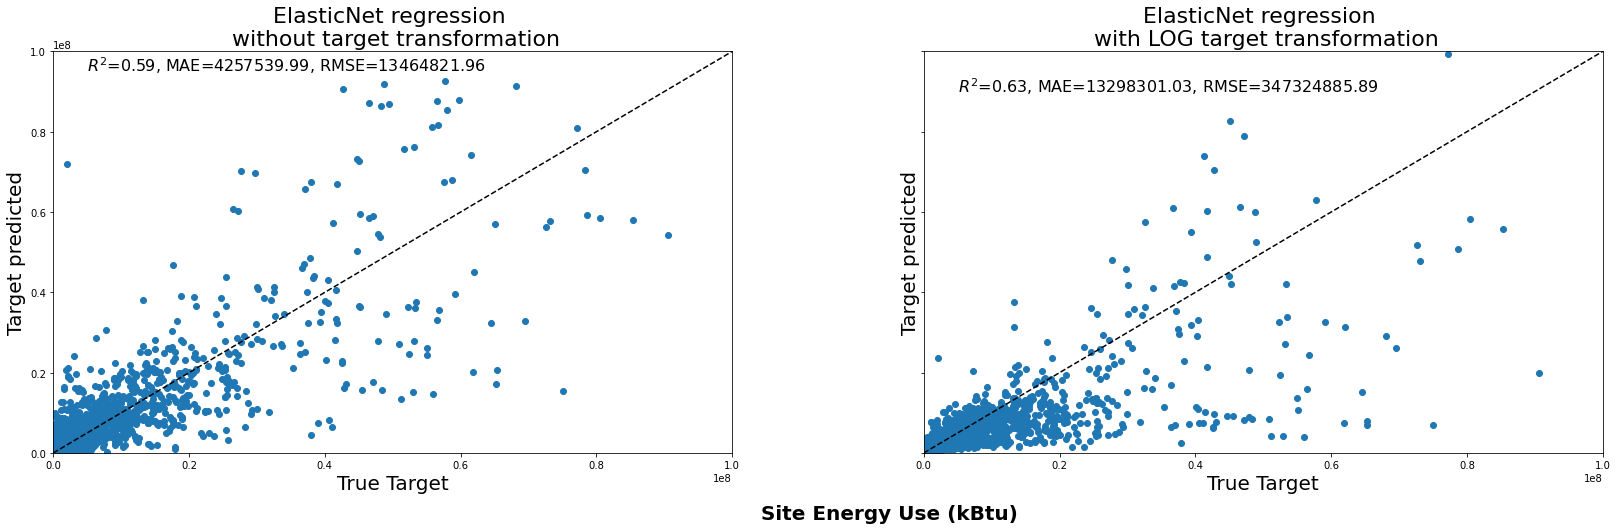

In [1173]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use ElasticNet model
start_time4 = time.time()
pipe_eNet = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', ElasticNet())])

params_eNet = {"regressor__alpha": np.logspace(-4, 0, num=5), # Constant that multiplies the penalty terms. Defaults to 1.0
                                                  # alpha=0 the penalty function reduces to the L1 (ridge) term
                                                  # alpha=1, we get the L2 (lasso) term.
              "regressor__l1_ratio": [.001, .01, .1, .5, .7, .9, .95, .99, 1], # The ElasticNet mixing parameter,
                                                                    # with 0 <= l1_ratio <= 1. 
                                                                    # For l1_ratio = 0 the penalty is an L2 penalty.
                                                                    # For l1_ratio = 1 it is an L1 penalty. 
                                                                    # For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
              "regressor__max_iter": [10, 50, 100, 1000, 10000]} # The maximum number of iterations (default = 1000)
             
grid_cvnet = GridSearchCV(pipe_eNet, 
                          param_grid=params_eNet, 
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)

eNet_SEU = grid_cvnet.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])

Y_pred = eNet_SEU.predict(X_train)
tm4 = time.time() - start_time4

# Plot results
ax0.scatter(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('ElasticNet regression \n without target transformation', size = 22)
r2_train4 = r2_score(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
MAE_train4 = mean_absolute_error(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
RMSE_train4 = np.sqrt(mean_squared_error(Y_train['SiteEnergyUse(kBtu)'], Y_pred))
ax0.text(5e6, 9.5e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train4, MAE_train4, RMSE_train4), size = 16)
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# ###############################################################################
# Transform targets and use same ElasticNet model
start_time_4 = time.time()

grid_cvnet_log = GridSearchCV(pipe_eNet, 
                          param_grid=params_eNet, 
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)


eNet_SEU_log = grid_cvnet_log.fit(X_train, Y_train['LogSEU'])
Y_pred = eNet_SEU_log.predict(X_train)
tm_4 = time.time() - start_time_4

ax1.scatter(np.expm1(Y_train['LogSEU']), np.expm1(Y_pred))
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('ElasticNet regression \n with LOG target transformation', size = 22)
r2_train_4 = r2_score(Y_train['LogSEU'], Y_pred)
MAE_train_4 = mean_absolute_error(np.expm1(Y_train['LogSEU']), np.expm1(Y_pred))
RMSE_train_4 = np.sqrt(mean_squared_error(np.expm1(Y_train['LogSEU']), np.expm1(Y_pred)))
ax1.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train_4 , MAE_train_4, RMSE_train_4 ), size = 16)
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])


f.suptitle("Site Energy Use (kBtu) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', eNet_SEU.best_params_)
print('Best parameters log scale:', eNet_SEU_log.best_params_)

#### SITE ENERGY USE - ELASTICNET REGRESSION ON TEST DATA

Best parameters lin scale: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.95, 'regressor__max_iter': 10}
Best parameters log scale: {'regressor__alpha': 0.0001, 'regressor__l1_ratio': 1, 'regressor__max_iter': 1000}


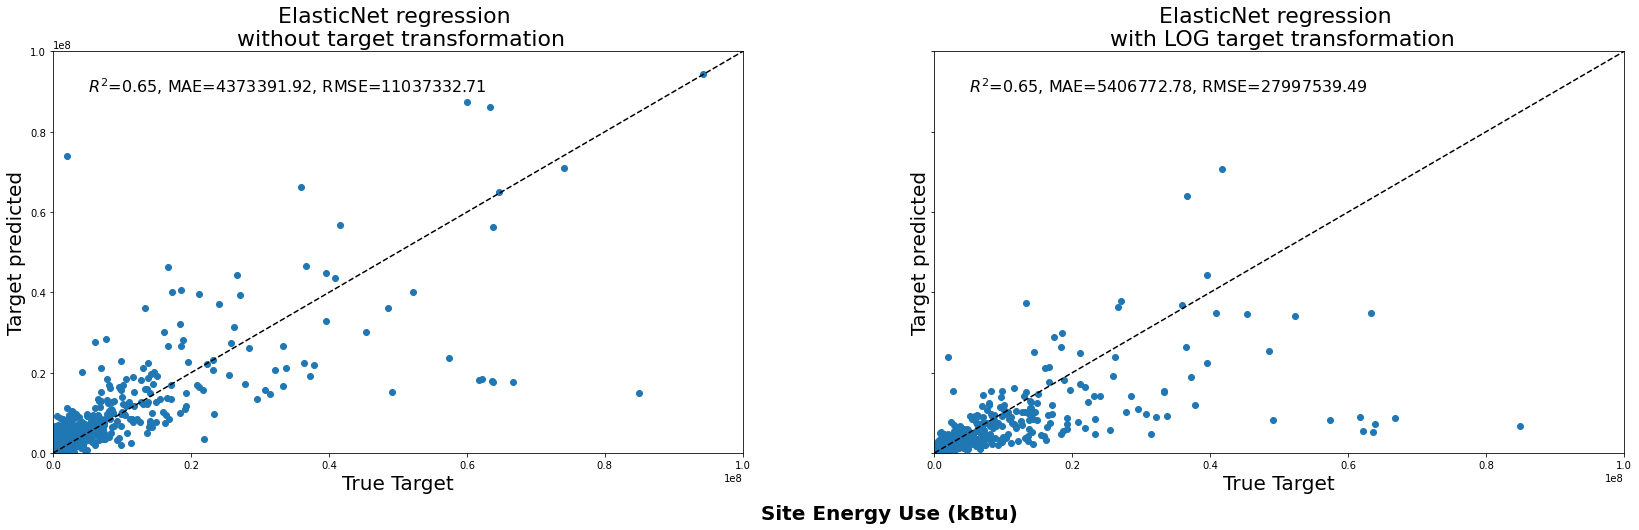

In [1174]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use ElasticNet model
start_time44 = time.time()
pipe_eNet = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', ElasticNet())])

params_eNet = {"regressor__alpha": np.logspace(-4, 0, num=5), # Constant that multiplies the penalty terms. Defaults to 1.0
                                                  # alpha=0 the penalty function reduces to the L1 (ridge) term
                                                  # alpha=1, we get the L2 (lasso) term.
              "regressor__l1_ratio": [.001, .01, .1, .5, .7, .9, .95, .99, 1], # The ElasticNet mixing parameter,
                                                                    # with 0 <= l1_ratio <= 1. 
                                                                    # For l1_ratio = 0 the penalty is an L2 penalty.
                                                                    # For l1_ratio = 1 it is an L1 penalty. 
                                                                    # For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
              "regressor__max_iter": [10, 50, 100, 1000, 10000]} # The maximum number of iterations (default = 1000)
             
grid_cvnet = GridSearchCV(pipe_eNet, 
                          param_grid=params_eNet, 
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)

eNet_SEU = grid_cvnet.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])

Y_pred = eNet_SEU.predict(X_test)
tm44 = time.time() - start_time44

# Plot results
ax0.scatter(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('ElasticNet regression \n without target transformation', size = 22)
r2_test44 = r2_score(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
MAE_test44 = mean_absolute_error(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
RMSE_test44 = np.sqrt(mean_squared_error(Y_test['SiteEnergyUse(kBtu)'], Y_pred))
ax0.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test44, MAE_test44, RMSE_test44), size = 16)
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# ####################################################################################
# Transform targets and use same ElasticNet model
start_time_44 = time.time()

grid_cvnet_log = GridSearchCV(pipe_eNet, 
                          param_grid=params_eNet, 
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)


eNet_SEU_log = grid_cvnet_log.fit(X_train, Y_train['LogSEU'])
Y_pred = eNet_SEU_log.predict(X_test)
tm_44 = time.time() - start_time_44

ax1.scatter(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred))
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('ElasticNet regression \n with LOG target transformation', size = 22)
r2_test_44 = r2_score(Y_test['LogSEU'], Y_pred)
MAE_test_44 = mean_absolute_error(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred))
RMSE_test_44 = np.sqrt(mean_squared_error(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred)))
ax1.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test_44 , MAE_test_44, RMSE_test_44 ), size = 16)
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])


f.suptitle("Site Energy Use (kBtu) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', eNet_SEU.best_params_)
print('Best parameters log scale:', eNet_SEU_log.best_params_)

#### GHG EMISSIONS - ELASTICNET REGRESSION ON TRAINING DATA

Best parameters lin scale: {'regressor__alpha': 1.0, 'regressor__l1_ratio': 1, 'regressor__max_iter': 10}
Best parameters log scale: {'regressor__alpha': 0.0001, 'regressor__l1_ratio': 1, 'regressor__max_iter': 1000}


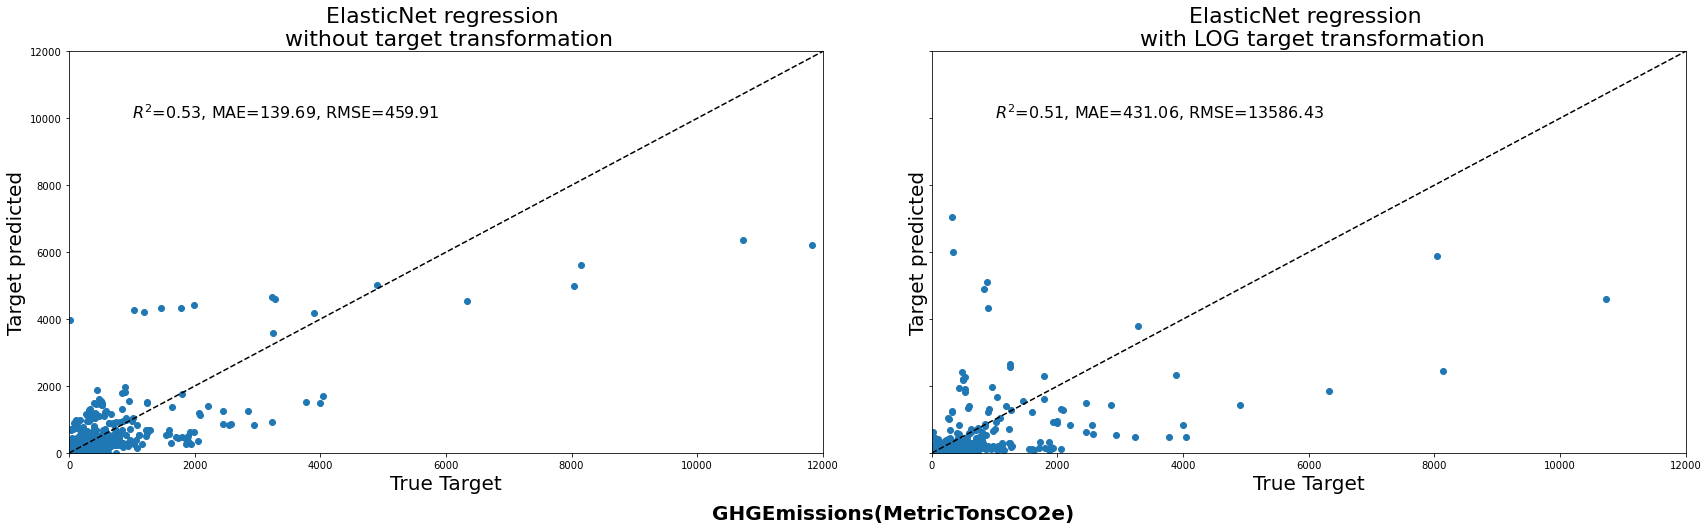

In [1175]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use ElasticNet model
start_time4b = time.time()

eNet_GHG = grid_cvnet.fit(X_train, Y_train['GHGEmissions(MetricTonsCO2e)'])

Y_pred = eNet_GHG.predict(X_train)
tm4b = time.time() - start_time4b

# Plot results
ax0.scatter(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
ax0.plot([0, 12e3], [0, 12e3], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('ElasticNet regression \n without target transformation', size = 22)
r2_train4b = r2_score(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
MAE_train4b = mean_absolute_error(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
RMSE_train4b = np.sqrt(mean_squared_error(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred))
ax0.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train4b, MAE_train4b, RMSE_train4b), size = 16)
ax0.set_xlim([0, 12e3])
ax0.set_ylim([0, 12e3])

# #############################################################################
# Transform targets and use same ElasticNet model
start_time_4b = time.time()

eNet_GHG_log = grid_cvnet_log.fit(X_train, Y_train['LogGHG'])
Y_pred = eNet_GHG_log.predict(X_train)
tm_4b = time.time() - start_time_4b

ax1.scatter(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred))
ax1.plot([0, 12e3], [0, 12e3], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('ElasticNet regression \n with LOG target transformation', size = 22)
r2_train_4b = r2_score(Y_train['LogGHG'], Y_pred)
MAE_train_4b = mean_absolute_error(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred))
RMSE_train_4b = np.sqrt(mean_squared_error(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred)))
ax1.text(1e3, 1e4, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train_4b , MAE_train_4b, RMSE_train_4b ), size = 16)
ax1.set_xlim([0, 12e3])
ax1.set_ylim([0, 12e3])

f.suptitle("GHGEmissions(MetricTonsCO2e)", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', eNet_GHG.best_params_)
print('Best parameters log scale:', eNet_GHG_log.best_params_)


#### GHG EMISSIONS - ELASTICNET REGRESSION ON TEST DATA

Best parameters lin scale: {'regressor__alpha': 1.0, 'regressor__l1_ratio': 1, 'regressor__max_iter': 10}
Best parameters log scale: {'regressor__alpha': 0.0001, 'regressor__l1_ratio': 1, 'regressor__max_iter': 1000}


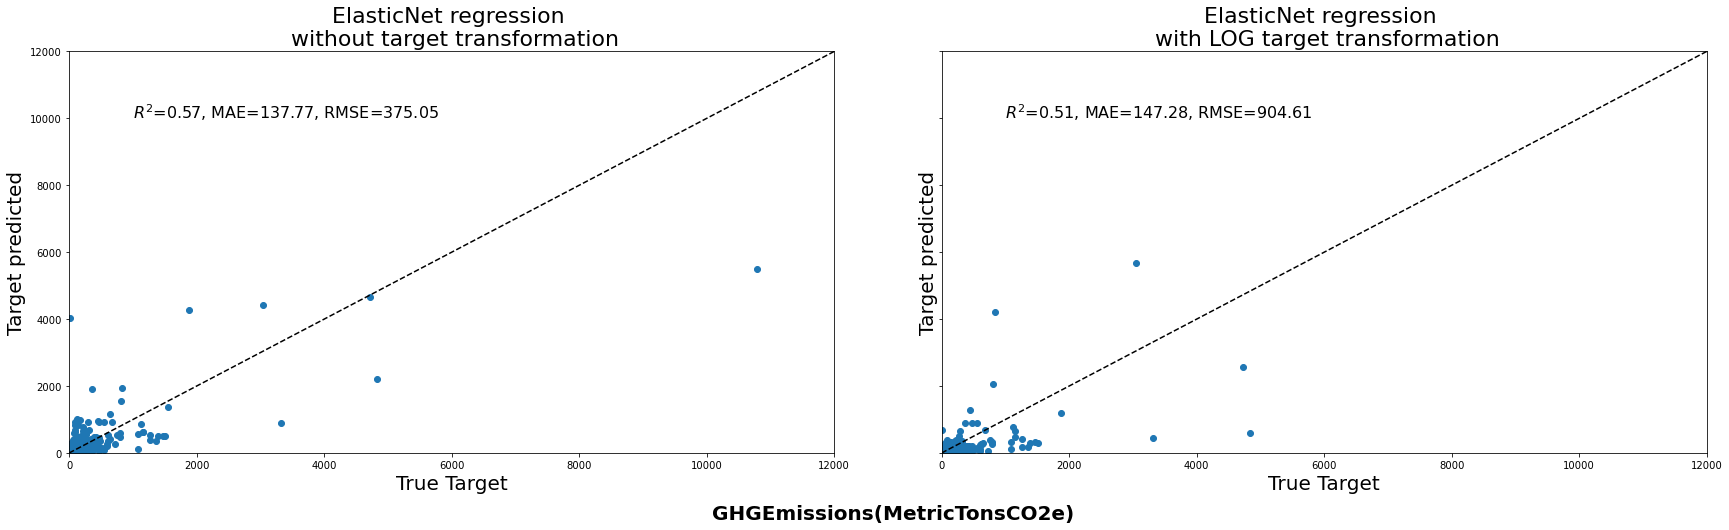

In [1176]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use ElasticNet model
start_time44b = time.time()

eNet_GHG = grid_cvnet.fit(X_train, Y_train['GHGEmissions(MetricTonsCO2e)'])

Y_pred = eNet_GHG.predict(X_test)
tm44b = time.time() - start_time44b

# Plot results
ax0.scatter(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
ax0.plot([0, 12e3], [0, 12e3], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('ElasticNet regression \n without target transformation', size = 22)
r2_test44b = r2_score(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
MAE_test44b = mean_absolute_error(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
RMSE_test44b = np.sqrt(mean_squared_error(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred))
ax0.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test44b, MAE_test44b, RMSE_test44b), size = 16)
ax0.set_xlim([0, 12e3])
ax0.set_ylim([0, 12e3])

# ###############################################################################
# Transform targets and use same ElasticNet model
start_time_44b = time.time()

eNet_GHG_log = grid_cvnet_log.fit(X_train, Y_train['LogGHG'])
Y_pred = eNet_GHG_log.predict(X_test)
tm_44b = time.time() - start_time_44b

ax1.scatter(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred))
ax1.plot([0, 12e3], [0, 12e3], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('ElasticNet regression \n with LOG target transformation', size = 22)
r2_test_44b = r2_score(Y_test['LogGHG'], Y_pred)
MAE_test_44b = mean_absolute_error(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred))
RMSE_test_44b = np.sqrt(mean_squared_error(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred)))
ax1.text(1e3, 1e4, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test_44b , MAE_test_44b, RMSE_test_44b ), size = 16)
ax1.set_xlim([0, 12e3])
ax1.set_ylim([0, 12e3])

f.suptitle("GHGEmissions(MetricTonsCO2e)", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', eNet_GHG.best_params_)
print('Best parameters log scale:', eNet_GHG_log.best_params_)

### 2-5) K-NEAREST NEIGHBORS (KNN) REGRESSION 

KNN regression is a non-parametric method that, in an intuitive manner, approximates the association between independent variables and the continuous outcome by averaging the observations in the same neighbourhood.

#### SITE ENERGY USE - KNN REGRESSION ON TRAINING DATA

Best parameters lin scale: {'regressor__n_neighbors': 3}
Best parameters log scale: {'regressor__n_neighbors': 3}


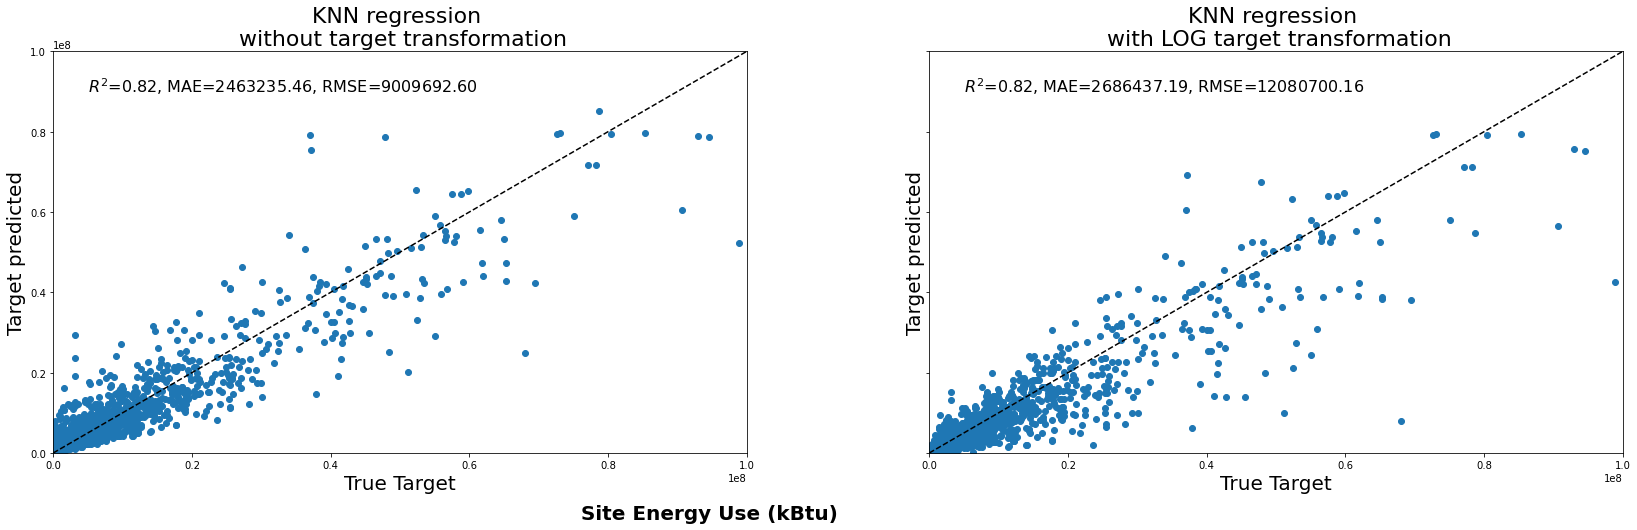

In [1177]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use KNN model
start_time5 = time.time()
pipe_knn = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor', KNeighborsRegressor())])

params_knn = {'regressor__n_neighbors':[3, 5, 7, 9, 11, 13, 15, 55]} # Number of neighbors

knn_grid_cv = GridSearchCV(
                    pipe_knn, # pipe with KNN regressor
                    params_knn,     # hyperparameters to train
                    cv=5,           # nombre of cross validation folds
                    scoring=('r2','neg_mean_absolute_error'),   # scoring to optimize
                    return_train_score = True,
                    refit='neg_mean_absolute_error',
                    n_jobs = -1)

knn_SEU = knn_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])

Y_pred = knn_SEU.predict(X_train)
tm5 = time.time() - start_time5

# Plot results
ax0.scatter(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('KNN regression \n without target transformation', size = 22)
r2_train5 = r2_score(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
MAE_train5 = mean_absolute_error(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
RMSE_train5 = np.sqrt(mean_squared_error(Y_train['SiteEnergyUse(kBtu)'], Y_pred))
ax0.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train5, MAE_train5, RMSE_train5), size = 16)
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# ########################################################################################
# Transform targets in Log and use same KNN model
start_time_5 = time.time()

knn_grid_cvlog = GridSearchCV(
                    pipe_knn, # pipe with KNN regressor
                    params_knn,     # hyperparameters to train
                    cv=5,           # nombre of cross validation folds
                    scoring=('r2','neg_mean_absolute_error'),   # scoring to optimize
                    return_train_score = True,
                    refit='neg_mean_absolute_error',
                    n_jobs = -1)

knn_SEU_log = knn_grid_cvlog.fit(X_train, Y_train['LogSEU'])
Y_pred = knn_SEU_log.predict(X_train)
tm_5 = time.time() - start_time_5

ax1.scatter(np.expm1(Y_train['LogSEU']), np.expm1(Y_pred))
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('KNN regression \n with LOG target transformation', size = 22)
r2_train_5 = r2_score(Y_train['LogSEU'], Y_pred)
MAE_train_5 = mean_absolute_error(np.expm1(Y_train['LogSEU']), np.expm1(Y_pred))
RMSE_train_5 = np.sqrt(mean_squared_error(np.expm1(Y_train['LogSEU']), np.expm1(Y_pred)))
ax1.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train_5, MAE_train_5, RMSE_train_5), size = 16)
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])

f.suptitle("Site Energy Use (kBtu) ", x = 1, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', knn_SEU.best_params_)
print('Best parameters log scale:', knn_SEU_log.best_params_)


#### SITE ENERGY USE - KNN REGRESSION ON TEST DATA

Best parameters lin scale: {'regressor__n_neighbors': 3}
Best parameters log scale: {'regressor__n_neighbors': 3}


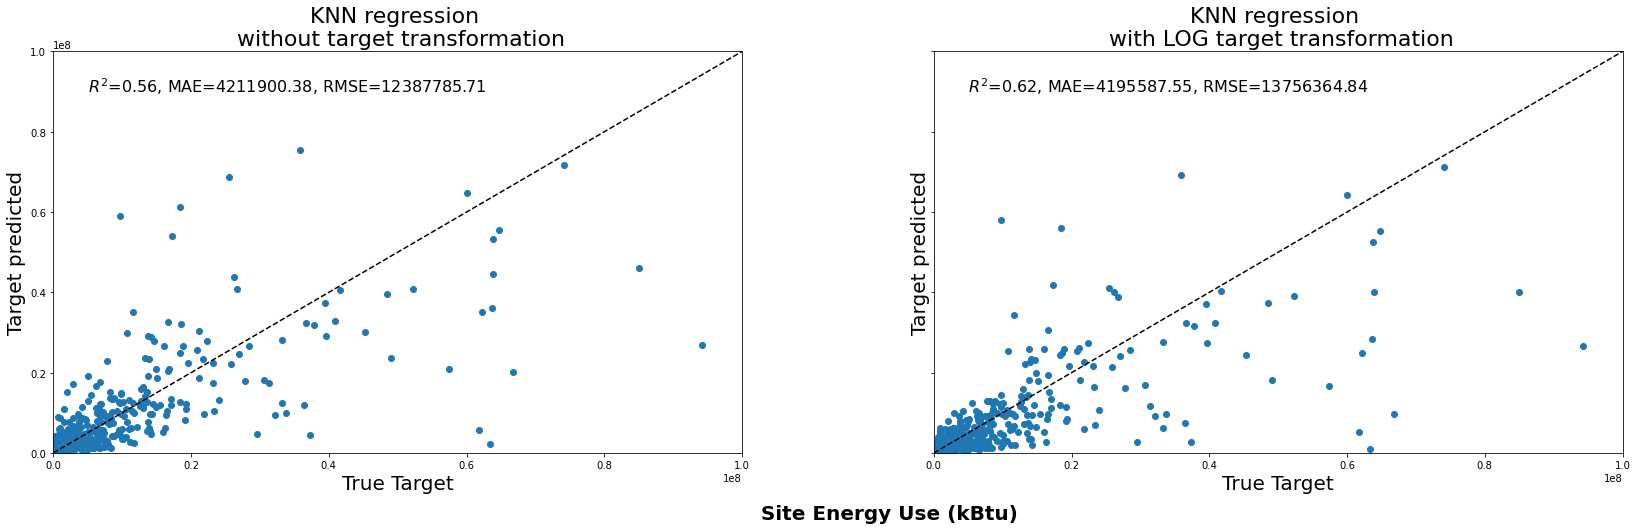

In [1178]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use KNN model
start_time55 = time.time()
pipe_knn = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor', KNeighborsRegressor())])

params_knn = {'regressor__n_neighbors':[3, 5, 7, 9, 11, 13, 15, 55]} # Number of neighbors

knn_grid_cv = GridSearchCV(
                    pipe_knn, # pipe with KNN regressor
                    params_knn,     # hyperparameters to test
                    cv=5,           # nombre of cross validation folds
                    scoring=('r2','neg_mean_absolute_error'),   # scoring to optimize
                    return_train_score = True,
                    refit='neg_mean_absolute_error',
                    n_jobs = -1)

knn_SEU = knn_grid_cv.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])

Y_pred = knn_SEU.predict(X_test)
tm55 = time.time() - start_time55

# Plot results
ax0.scatter(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('KNN regression \n without target transformation', size = 22)
r2_test55 = r2_score(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
MAE_test55 = mean_absolute_error(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
RMSE_test55 = np.sqrt(mean_squared_error(Y_test['SiteEnergyUse(kBtu)'], Y_pred))
ax0.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test55, MAE_test55, RMSE_test55), size = 16)
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# #################################################################################
# Transform targets in Log and use same KNN model
start_time_55 = time.time()

knn_grid_cvlog = GridSearchCV(
                    pipe_knn, # pipe with KNN regressor
                    params_knn,     # hyperparameters to test
                    cv=5,           # nombre of cross validation folds
                    scoring=('r2','neg_mean_absolute_error'),   # scoring to optimize
                    return_train_score = True,
                    refit='neg_mean_absolute_error',
                    n_jobs = -1)

knn_SEU_log = knn_grid_cvlog.fit(X_train, Y_train['LogSEU'])
Y_pred = knn_SEU_log.predict(X_test)
tm_55 = time.time() - start_time_55

ax1.scatter(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred))
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('KNN regression \n with LOG target transformation', size = 22)
r2_test_55 = r2_score(Y_test['LogSEU'], Y_pred)
MAE_test_55 = mean_absolute_error(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred))
RMSE_test_55 = np.sqrt(mean_squared_error(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred)))
ax1.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test_55, MAE_test_55, RMSE_test_55), size = 16)
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])


f.suptitle("Site Energy Use (kBtu) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', knn_SEU.best_params_)
print('Best parameters log scale:', knn_SEU_log.best_params_)


#### GHG EMISSIONS - KNN REGRESSION ON TRAINING DATA

Best parameters lin scale: {'regressor__n_neighbors': 3}
Best parameters log scale: {'regressor__n_neighbors': 3}


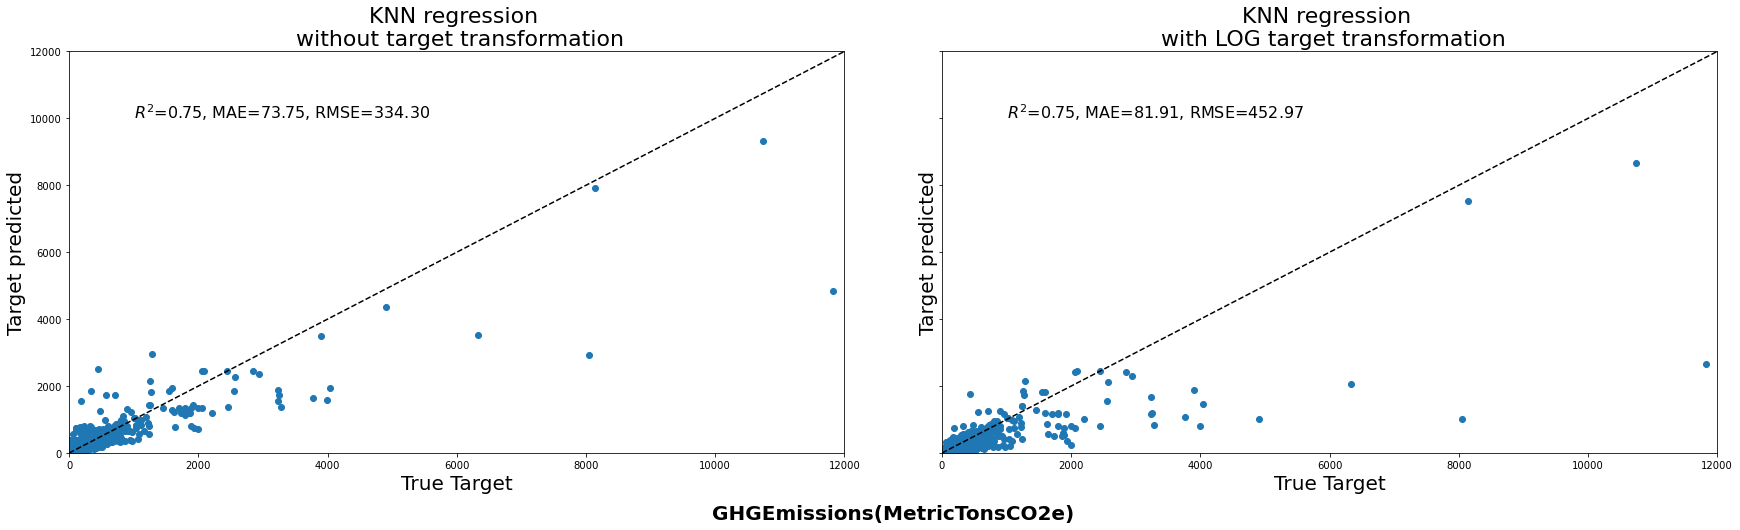

In [1179]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use KNN model
start_time5b = time.time()

knn_GHG = knn_grid_cv.fit(X_train, Y_train['GHGEmissions(MetricTonsCO2e)'])

Y_pred = knn_GHG.predict(X_train)
tm5b = time.time() - start_time5b

# Plot results
ax0.scatter(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
ax0.plot([0, 12e3], [0, 12e3], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('KNN regression \n without target transformation', size = 22)
r2_train5b = r2_score(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
MAE_train5b = mean_absolute_error(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
RMSE_train5b = np.sqrt(mean_squared_error(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred))
ax0.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train5b, MAE_train5b, RMSE_train5b), size = 16)
ax0.set_xlim([0, 12e3])
ax0.set_ylim([0, 12e3])

# ######################################################################################
# Transform targets in Log and use same KNN model
start_time_5b = time.time()

knn_GHG_log = knn_grid_cvlog.fit(X_train, Y_train['LogGHG'])
Y_pred = knn_GHG_log.predict(X_train)
tm_5b = time.time() - start_time_5b

ax1.scatter(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred))
ax1.plot([0, 12e3], [0, 12e3], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('KNN regression \n with LOG target transformation', size = 22)
r2_train_5b = r2_score(Y_train['LogGHG'], Y_pred)
MAE_train_5b = mean_absolute_error(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred))
RMSE_train_5b = np.sqrt(mean_squared_error(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred)))
ax1.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train_5b, MAE_train_5b, RMSE_train_5b), size = 16)
ax1.set_xlim([0, 12e3])
ax1.set_ylim([0, 12e3])

f.suptitle("GHGEmissions(MetricTonsCO2e)", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', knn_GHG.best_params_)
print('Best parameters log scale:', knn_GHG_log.best_params_)


#### GHG EMISSIONS - KNN REGRESSION ON TEST DATA

Best parameters lin scale: {'regressor__n_neighbors': 3}
Best parameters log scale: {'regressor__n_neighbors': 3}


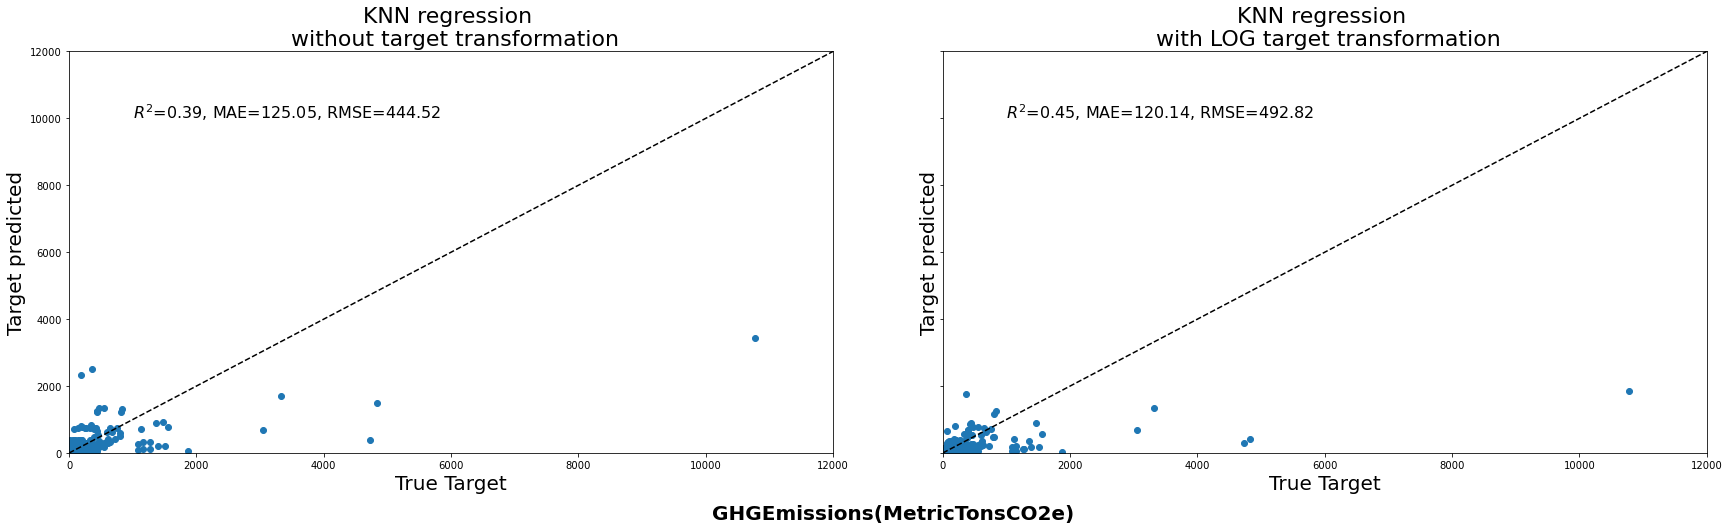

In [1180]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use KNN model
start_time55b = time.time()

knn_GHG = knn_grid_cv.fit(X_train, Y_train['GHGEmissions(MetricTonsCO2e)'])

Y_pred = knn_GHG.predict(X_test)
tm55b = time.time() - start_time55b

# Plot results
ax0.scatter(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
ax0.plot([0, 12e3], [0, 12e3], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('KNN regression \n without target transformation', size = 22)
r2_test55b = r2_score(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
MAE_test55b = mean_absolute_error(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
RMSE_test55b = np.sqrt(mean_squared_error(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred))
ax0.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test55b, MAE_test55b, RMSE_test55b), size = 16)
ax0.set_xlim([0, 12e3])
ax0.set_ylim([0, 12e3])

# #################################################################################
# Transform targets in Log and use same KNN model
start_time_55b = time.time()

knn_GHG_log = knn_grid_cvlog.fit(X_train, Y_train['LogGHG'])
Y_pred = knn_GHG_log.predict(X_test)
tm_55b = time.time() - start_time_55b

ax1.scatter(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred))
ax1.plot([0, 12e3], [0, 12e3], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('KNN regression \n with LOG target transformation', size = 22)
r2_test_55b = r2_score(Y_test['LogGHG'], Y_pred)
MAE_test_55b = mean_absolute_error(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred))
RMSE_test_55b = np.sqrt(mean_squared_error(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred)))
ax1.text(1e3, 1e4, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test_55b, MAE_test_55b, RMSE_test_55b), size = 16)
ax1.set_xlim([0, 12e3])
ax1.set_ylim([0, 12e3])

f.suptitle("GHGEmissions(MetricTonsCO2e)", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', knn_GHG.best_params_)
print('Best parameters log scale:', knn_GHG_log.best_params_)


### 2-6) SVM REGRESSION 

Support Vector Regression is a supervised learning algorithm that is used to predict discrete values. Support Vector Regression uses the same principle as the SVMs. The basic idea behind SVR is to find the best fit line. In SVR, the best fit line is the hyperplane that has the maximum number of points.

#### SITE ENERGY USE - SVM REGRESSION ON TRAINING DATA

Best parameters lin scale: {'regressor__C': 0.1, 'regressor__epsilon': 0.1, 'regressor__loss': 'squared_epsilon_insensitive', 'regressor__max_iter': 100}
Best parameters log scale: {'regressor__C': 1, 'regressor__epsilon': 0.1, 'regressor__loss': 'epsilon_insensitive', 'regressor__max_iter': 1000}


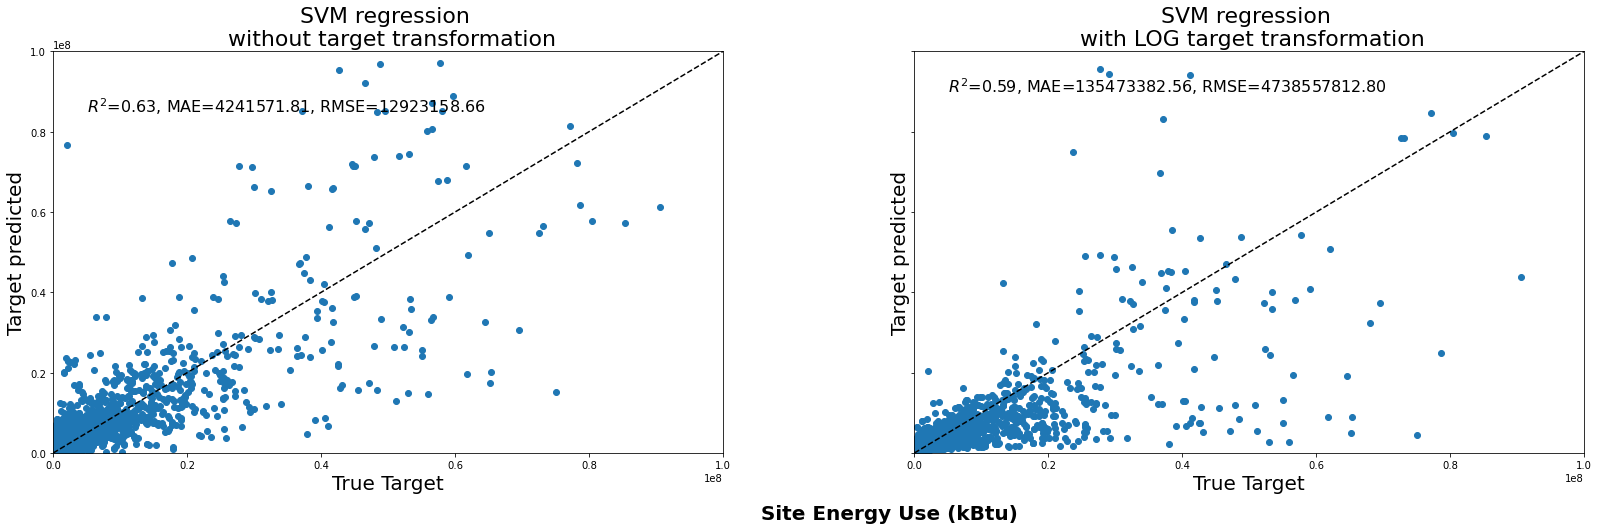

In [1181]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use SVM model
start_time6 = time.time()
pipe_svr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', LinearSVR())])

params_svr = {'regressor__epsilon' : [0.1, 1, 0.01 ], # Epsilon parameter in the epsilon-insensitive loss function (default=0)
             'regressor__C' : [0.1, 1, 0.01], # Regularization parameter. The strength of the regularization is inversely proportional to C.
             'regressor__loss' : ["epsilon_insensitive","squared_epsilon_insensitive"], # Specifies the loss function 
             'regressor__max_iter': [10, 100, 1000, 2000]} # The maximum number of iterations to be run (default=1000)

grid_cvsvr = GridSearchCV(pipe_svr, 
                          param_grid=params_svr,
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)

svr_SEU = grid_cvsvr.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])

Y_pred = svr_SEU.predict(X_train)
tm6 = time.time() - start_time6

# Plot results
ax0.scatter(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('SVM regression \n without target transformation', size = 22)
r2_train6 = r2_score(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
MAE_train6 = mean_absolute_error(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
RMSE_train6 = np.sqrt(mean_squared_error(Y_train['SiteEnergyUse(kBtu)'], Y_pred))
ax0.text(5e6, 85e6, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train6, MAE_train6, RMSE_train6), size = 16)
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# #########################################################################################
# Transform targets and use same SVM model
start_time_6 = time.time()

grid_cvsvr_log = GridSearchCV(pipe_svr, 
                          param_grid=params_svr,
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)

svr_SEU_log = grid_cvsvr_log.fit(X_train, Y_train['LogSEU'])
Y_pred = svr_SEU_log.predict(X_train)
tm_6 = time.time() - start_time_6

ax1.scatter(np.expm1(Y_train['LogSEU']), np.expm1(Y_pred))
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('SVM regression \n with LOG target transformation', size = 22)
r2_train_6 = r2_score(Y_train['LogSEU'], Y_pred)
MAE_train_6 = mean_absolute_error(np.expm1(Y_train['LogSEU']), np.expm1(Y_pred))
RMSE_train_6 = np.sqrt(mean_squared_error(np.expm1(Y_train['LogSEU']), np.expm1(Y_pred)))
ax1.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train_6, MAE_train_6, RMSE_train_6), size = 16)
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])


f.suptitle("Site Energy Use (kBtu) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', svr_SEU.best_params_)
print('Best parameters log scale:', svr_SEU_log.best_params_)


#### SITE ENERGY USE - SVM REGRESSION ON TEST DATA

Best parameters lin scale: {'regressor__C': 0.1, 'regressor__epsilon': 0.01, 'regressor__loss': 'squared_epsilon_insensitive', 'regressor__max_iter': 100}
Best parameters log scale: {'regressor__C': 1, 'regressor__epsilon': 0.1, 'regressor__loss': 'epsilon_insensitive', 'regressor__max_iter': 1000}


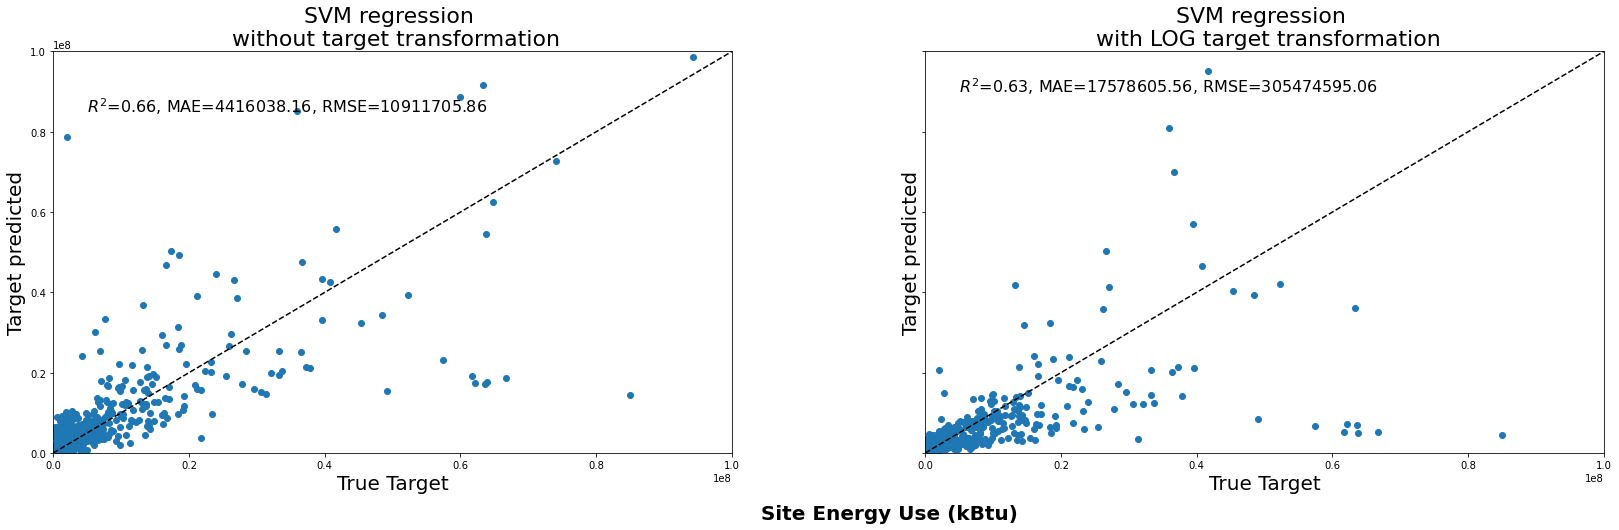

In [1182]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use SVM model
start_time66 = time.time()
pipe_svr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', LinearSVR())])

svr_SEU = grid_cvsvr.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])

Y_pred = svr_SEU.predict(X_test)
tm66 = time.time() - start_time66

# Plot results
ax0.scatter(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('SVM regression \n without target transformation', size = 22)
r2_test66 = r2_score(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
MAE_test66 = mean_absolute_error(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
RMSE_test66 = np.sqrt(mean_squared_error(Y_test['SiteEnergyUse(kBtu)'], Y_pred))
ax0.text(5e6, 85e6, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test66, MAE_test66, RMSE_test66), size = 16)
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# ############################################################################
# Transform targets and use same SVM model
start_time_66 = time.time()

svr_SEU_log = grid_cvsvr_log.fit(X_train, Y_train['LogSEU'])
Y_pred = svr_SEU_log.predict(X_test)
tm_66 = time.time() - start_time_66

ax1.scatter(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred))
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('SVM regression \n with LOG target transformation', size = 22)
r2_test_66 = r2_score(Y_test['LogSEU'], Y_pred)
MAE_test_66 = mean_absolute_error(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred))
RMSE_test_66 = np.sqrt(mean_squared_error(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred)))
ax1.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test_66, MAE_test_66, RMSE_test_66), size = 16)
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])


f.suptitle("Site Energy Use (kBtu) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', svr_SEU.best_params_)
print('Best parameters log scale:', svr_SEU_log.best_params_)


#### GHG EMISSIONS - SVM REGRESSION ON TRAINING DATA

Best parameters lin scale: {'regressor__C': 1, 'regressor__epsilon': 0.1, 'regressor__loss': 'epsilon_insensitive', 'regressor__max_iter': 10}
Best parameters log scale: {'regressor__C': 1, 'regressor__epsilon': 0.01, 'regressor__loss': 'epsilon_insensitive', 'regressor__max_iter': 2000}


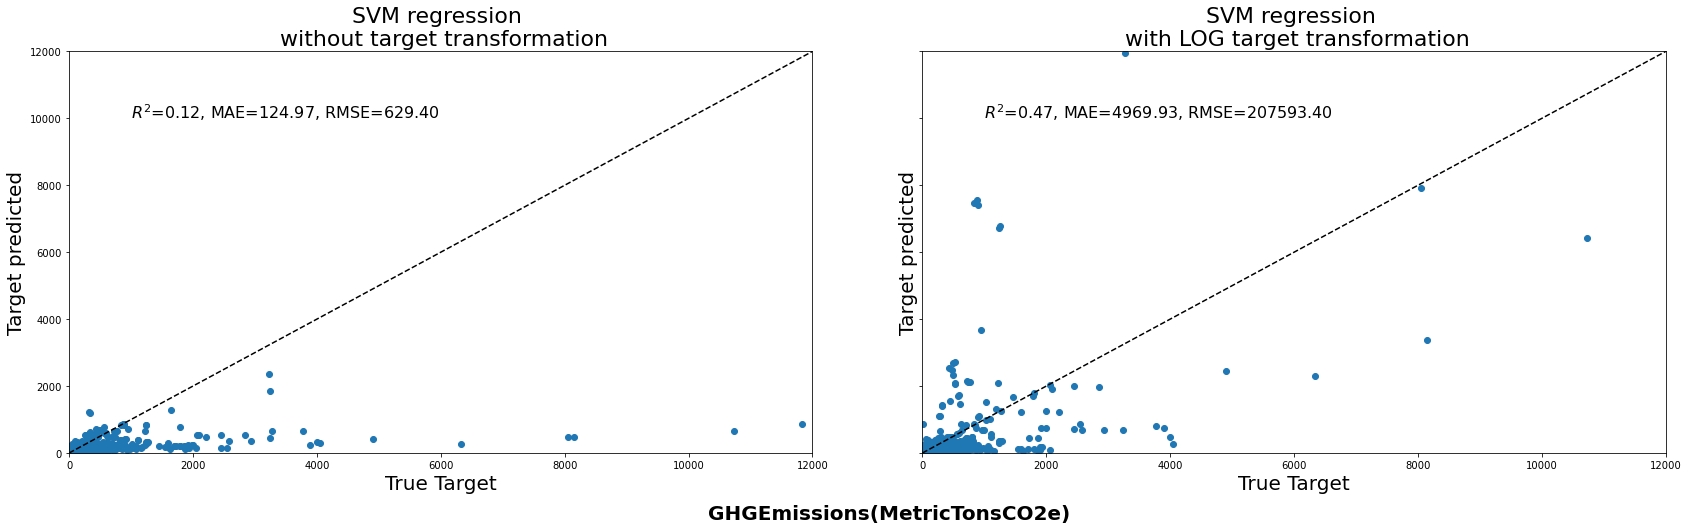

In [1183]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use SVM model
start_time6b = time.time()

svr_GHG = grid_cvsvr.fit(X_train, Y_train['GHGEmissions(MetricTonsCO2e)'])

Y_pred = svr_GHG.predict(X_train)
tm6b = time.time() - start_time6b

# Plot results
ax0.scatter(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
ax0.plot([0, 12e3], [0, 12e3], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('SVM regression \n without target transformation', size = 22)
r2_train6b = r2_score(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
MAE_train6b = mean_absolute_error(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
RMSE_train6b = np.sqrt(mean_squared_error(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred))
ax0.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train6b, MAE_train6b, RMSE_train6b), size = 16)
ax0.set_xlim([0, 12e3])
ax0.set_ylim([0, 12e3])

# ######################################################################################
# Transform targets and use same SVM model
start_time_6b = time.time()

svr_GHG_log = grid_cvsvr_log.fit(X_train, Y_train['LogGHG'])
Y_pred = svr_GHG_log.predict(X_train)
tm_6b = time.time() - start_time_6b

ax1.scatter(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred))
ax1.plot([0, 12e3], [0, 12e3], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('SVM regression \n with LOG target transformation', size = 22)
r2_train_6b = r2_score(Y_train['LogGHG'], Y_pred)
MAE_train_6b = mean_absolute_error(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred))
RMSE_train_6b = np.sqrt(mean_squared_error(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred)))
ax1.text(1e3, 1e4, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train_6b, MAE_train_6b, RMSE_train_6b), size = 16)
ax1.set_xlim([0, 12e3])
ax1.set_ylim([0, 12e3])

f.suptitle("GHGEmissions(MetricTonsCO2e) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', svr_GHG.best_params_)
print('Best parameters log scale:', svr_GHG_log.best_params_)

#### GHG EMISSIONS - SVM REGRESSION ON TEST DATA

Best parameters lin scale: {'regressor__C': 1, 'regressor__epsilon': 0.01, 'regressor__loss': 'epsilon_insensitive', 'regressor__max_iter': 100}
Best parameters log scale: {'regressor__C': 1, 'regressor__epsilon': 0.01, 'regressor__loss': 'epsilon_insensitive', 'regressor__max_iter': 2000}


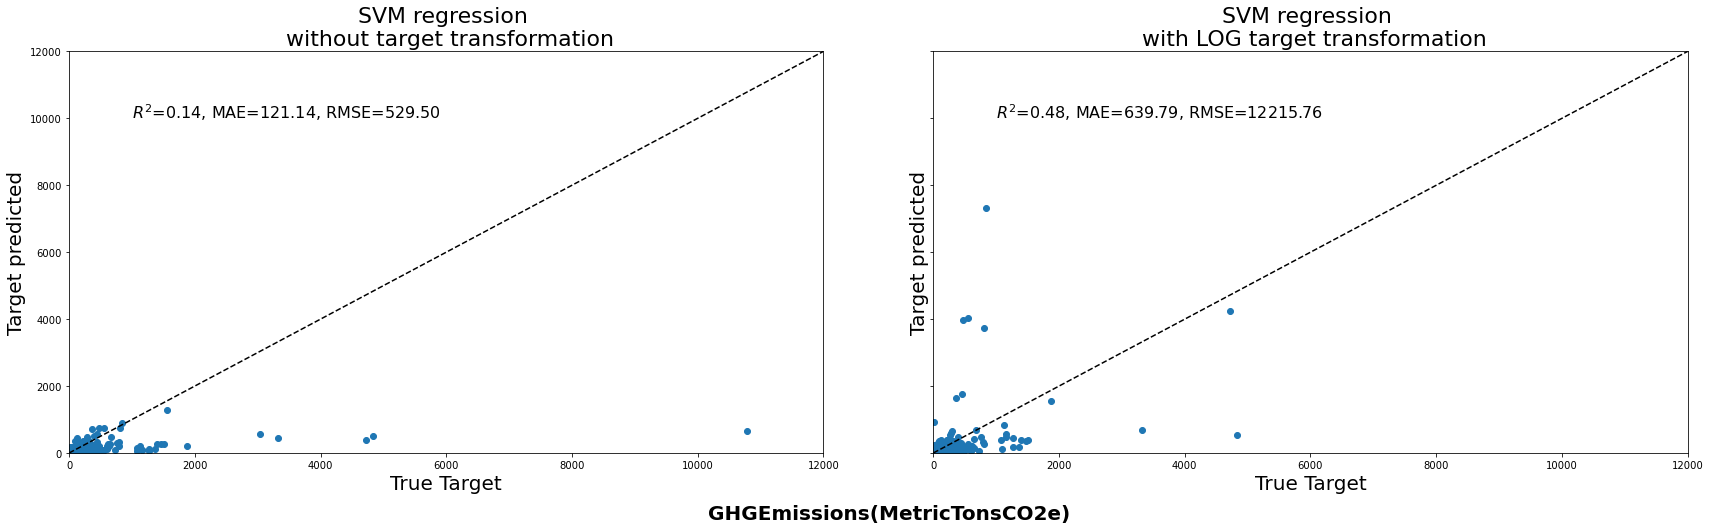

In [1184]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use SVM model
start_time66b = time.time()

svr_GHG = grid_cvsvr.fit(X_train, Y_train['GHGEmissions(MetricTonsCO2e)'])

Y_pred = svr_GHG.predict(X_test)
tm66b = time.time() - start_time66b

# Plot results
ax0.scatter(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
ax0.plot([0, 12e3], [0, 12e3], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('SVM regression \n without target transformation', size = 22)
r2_test66b = r2_score(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
MAE_test66b = mean_absolute_error(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
RMSE_test66b = np.sqrt(mean_squared_error(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred))
ax0.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test66b, MAE_test66b, RMSE_test66b), size = 16)
ax0.set_xlim([0, 12e3])
ax0.set_ylim([0, 12e3])

# ######################################################################################
# Transform targets and use same SVM model
start_time_66b = time.time()

svr_GHG_log = grid_cvsvr_log.fit(X_train, Y_train['LogGHG'])
Y_pred = svr_GHG_log.predict(X_test)
tm_66b = time.time() - start_time_66b

ax1.scatter(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred))
ax1.plot([0, 12e3], [0, 12e3], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('SVM regression \n with LOG target transformation', size = 22)
r2_test_66b = r2_score(Y_test['LogGHG'], Y_pred)
MAE_test_66b = mean_absolute_error(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred))
RMSE_test_66b = np.sqrt(mean_squared_error(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred)))
ax1.text(1e3, 1e4, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test_66b, MAE_test_66b, RMSE_test_66b), size = 16)
ax1.set_xlim([0, 12e3])
ax1.set_ylim([0, 12e3])

f.suptitle("GHGEmissions(MetricTonsCO2e) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', svr_GHG.best_params_)
print('Best parameters log scale:', svr_GHG_log.best_params_)

### 2-7) RANDOMFOREST REGRESSION

Random Forest Regression is a supervised learning algorithm that uses ensemble learning method for regression. Ensemble learning method is a technique that combines predictions from multiple machine learning algorithms to make a more accurate prediction than a single model.<br> A Random Forest operates by constructing several decision trees during training time and outputting the mean of the classes as the prediction of all the trees.<br>
The hyperparameters we considered here include the number of features, number of trees, maximum depth of trees, whether to bootstrap samples, the minimum number of samples left in a node before a split and the minimum number of samples left in the final leaf node.
https://www.researchgate.net/publication/268509189_Sentiment_Mining_of_Movie_Reviews_using_Random_Forest_with_Tuned_Hyperparameters
https://arxiv.org/pdf/1706.09865.pdf<br>
https://arxiv.org/pdf/1710.04725.pdf

#### SITE ENERGY USE - RANDOMFOREST REGRESSION ON TRAINING DATA

Best parameters lin scale: {'regressor__bootstrap': False, 'regressor__max_depth': 100, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Best parameters log scale: {'regressor__bootstrap': False, 'regressor__max_depth': 100, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}


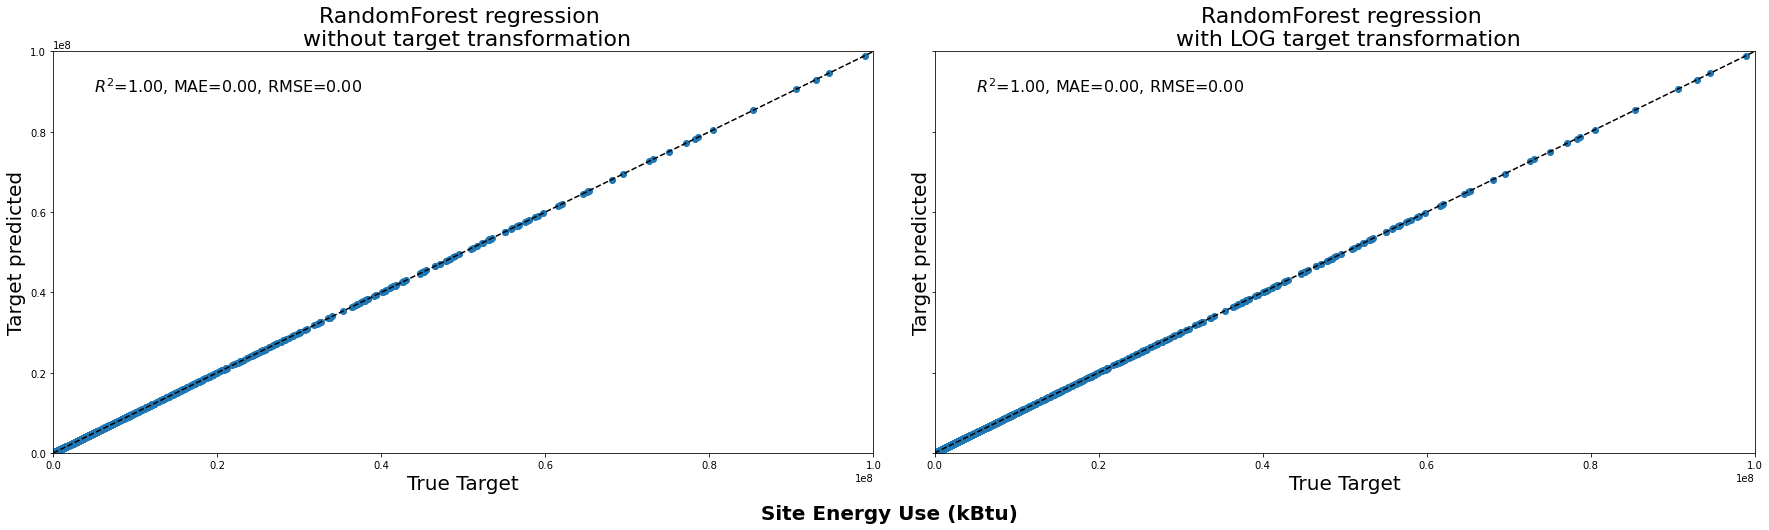

In [1185]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use RandomForest model
start_time7 = time.time()
pipe_rfr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', RandomForestRegressor())])

params_rfr = {'regressor__max_features' : ['auto', 'sqrt', 'log2'], # The number of features to consider when looking for the best split
             'regressor__max_depth': [5, 15, 25, 50, 100], # The maximum depth of the tree
             'regressor__min_samples_split': [2, 5, 10], # The minimum number of samples required to split an internal node (default=2)
             'regressor__bootstrap' : [True, False], # Whether bootstrap samples are used when building trees
             'regressor__min_samples_leaf': [1,2,5,10]} # The minimum number of samples required to be at a leaf node (default=1)


grid_cvrfr = GridSearchCV(pipe_rfr,
                          param_grid=params_rfr,
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)

rfr_SEU = grid_cvrfr.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])

Y_pred = rfr_SEU.predict(X_train)
tm7 = time.time() - start_time7

# Plot results
ax0.scatter(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('RandomForest regression \n without target transformation', size = 22)
r2_train7 = r2_score(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
MAE_train7 = mean_absolute_error(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
RMSE_train7 = np.sqrt(mean_squared_error(Y_train['SiteEnergyUse(kBtu)'], Y_pred))
ax0.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train7, MAE_train7, RMSE_train7), size = 16)
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# ##################################################################################
# Transform targets and use same RandomForest model
start_time_7 = time.time()
pipe_rfr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', RandomForestRegressor())])

grid_cvrfr_log = GridSearchCV(pipe_rfr,
                          param_grid=params_rfr,
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)

rfr_SEU_log = grid_cvrfr_log.fit(X_train, Y_train['LogSEU'])
Y_pred = rfr_SEU_log.predict(X_train)
tm_7 = time.time() - start_time_7

ax1.scatter(np.expm1(Y_train['LogSEU']), np.expm1(Y_pred))
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('RandomForest regression \n with LOG target transformation', size = 22)
r2_train_7 = r2_score(Y_train['LogSEU'], Y_pred)
MAE_train_7 = mean_absolute_error(np.expm1(Y_train['LogSEU']), np.expm1(Y_pred))
RMSE_train_7 = np.sqrt(mean_squared_error(np.expm1(Y_train['LogSEU']), np.expm1(Y_pred)))
ax1.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train_7, MAE_train_7, RMSE_train_7), size = 16)
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])

f.suptitle("Site Energy Use (kBtu) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', rfr_SEU.best_params_)
print('Best parameters log scale:', rfr_SEU_log.best_params_)

#### SITE ENERGY USE - RANDOMFOREST REGRESSION ON TEST DATA

Best parameters lin scale: {'regressor__bootstrap': False, 'regressor__max_depth': 50, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Best parameters log scale: {'regressor__bootstrap': False, 'regressor__max_depth': 50, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}


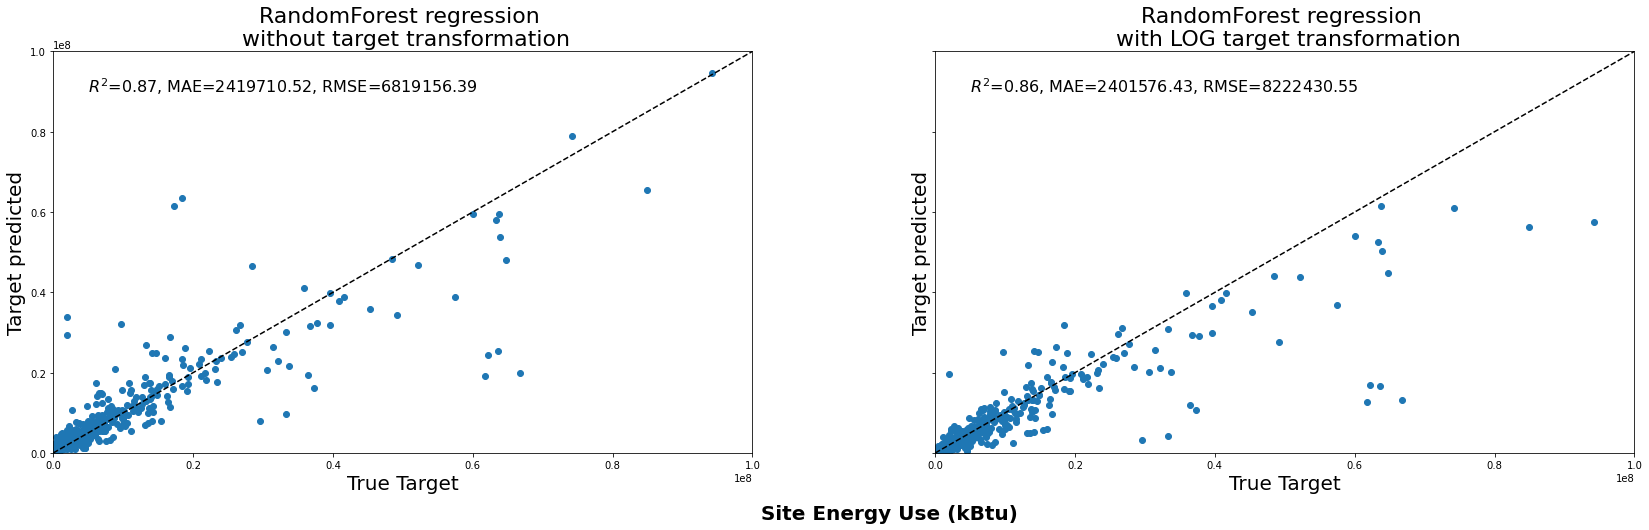

In [1186]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use RandomForest model
start_time77 = time.time()
pipe_rfr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', RandomForestRegressor())])

params_rfr = {'regressor__max_features' : ['auto', 'sqrt', 'log2'], # The number of features to consider when looking for the best split
             'regressor__max_depth': [5, 15, 25, 50, 100], # The maximum depth of the tree
             'regressor__min_samples_split': [2, 5, 10], # The minimum number of samples required to split an internal node (default=2)
             'regressor__bootstrap' : [True, False], # Whether bootstrap samples are used when building trees
             'regressor__min_samples_leaf': [1,2,5,10]} # The minimum number of samples required to be at a leaf node (default=1)


grid_cvrfr = GridSearchCV(pipe_rfr,
                          param_grid=params_rfr,
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)

rfr_SEU = grid_cvrfr.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])

Y_pred = rfr_SEU.predict(X_test)
tm77 = time.time() - start_time77

# Plot results
ax0.scatter(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('RandomForest regression \n without target transformation', size = 22)
r2_test77 = r2_score(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
MAE_test77 = mean_absolute_error(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
RMSE_test77 = np.sqrt(mean_squared_error(Y_test['SiteEnergyUse(kBtu)'], Y_pred))
ax0.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test77, MAE_test77, RMSE_test77), size = 16)
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# #######################################################################################
# Transform targets and use same RandomForest model
start_time_77 = time.time()
pipe_rfr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', RandomForestRegressor())])

rfr_SEU_log = grid_cvrfr_log.fit(X_train, Y_train['LogSEU'])
Y_pred = rfr_SEU_log.predict(X_test)
tm_77 = time.time() - start_time_77

ax1.scatter(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred))
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('RandomForest regression \n with LOG target transformation', size = 22)
r2_test_77 = r2_score(Y_test['LogSEU'], Y_pred)
MAE_test_77 = mean_absolute_error(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred))
RMSE_test_77 = np.sqrt(mean_squared_error(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred)))
ax1.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test_77, MAE_test_77, RMSE_test_77), size = 16)
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])

f.suptitle("Site Energy Use (kBtu) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', rfr_SEU.best_params_)
print('Best parameters log scale:', rfr_SEU_log.best_params_)


#### GHG EMISSIONS - RANDOMFOREST REGRESSION ON TRAINING DATA

Best parameters lin scale: {'regressor__bootstrap': False, 'regressor__max_depth': 100, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Best parameters log scale: {'regressor__bootstrap': False, 'regressor__max_depth': 100, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}


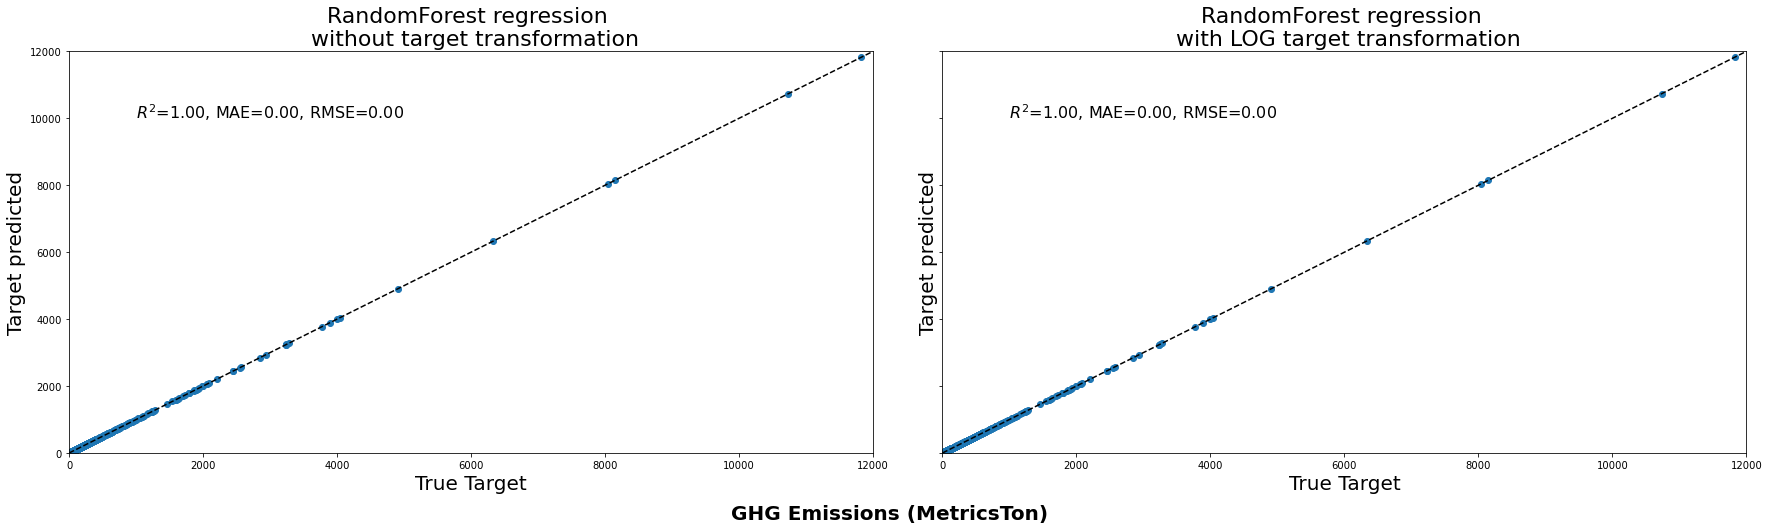

In [1187]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use RandomForest model
start_time7b = time.time()

rfr_GHG = grid_cvrfr.fit(X_train, Y_train['GHGEmissions(MetricTonsCO2e)'])

Y_pred = rfr_GHG.predict(X_train)
tm7b = time.time() - start_time7b

# Plot results
ax0.scatter(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
ax0.plot([0, 12e3], [0, 12e3], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('RandomForest regression \n without target transformation', size = 22)
r2_train7b = r2_score(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
MAE_train7b = mean_absolute_error(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
RMSE_train7b = np.sqrt(mean_squared_error(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred))
ax0.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train7b, MAE_train7b, RMSE_train7b), size = 16)
ax0.set_xlim([0, 12e3])
ax0.set_ylim([0, 12e3])

# ####################################################################################
# Transform targets and use same RandomForest model
start_time_7b = time.time()

rfr_GHG_log = grid_cvrfr_log.fit(X_train, Y_train['LogGHG'])
Y_pred = rfr_GHG_log.predict(X_train)
tm_7b = time.time() - start_time_7b

ax1.scatter(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred))
ax1.plot([0, 12e3], [0, 12e3], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('RandomForest regression \n with LOG target transformation', size = 22)
r2_train_7b = r2_score(Y_train['LogGHG'], Y_pred)
MAE_train_7b = mean_absolute_error(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred))
RMSE_train_7b = np.sqrt(mean_squared_error(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred)))
ax1.text(1e3, 1e4, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train_7b, MAE_train_7b, RMSE_train_7b), size = 16)
ax1.set_xlim([0, 12e3])
ax1.set_ylim([0, 12e3])

f.suptitle("GHG Emissions (MetricsTon) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', rfr_GHG.best_params_)
print('Best parameters log scale:', rfr_GHG_log.best_params_)

#### GHG EMISSIONS - RANDOMFOREST REGRESSION ON TEST DATA

Best parameters lin scale: {'regressor__bootstrap': False, 'regressor__max_depth': 50, 'regressor__max_features': 'auto', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Best parameters log scale: {'regressor__bootstrap': False, 'regressor__max_depth': 100, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}


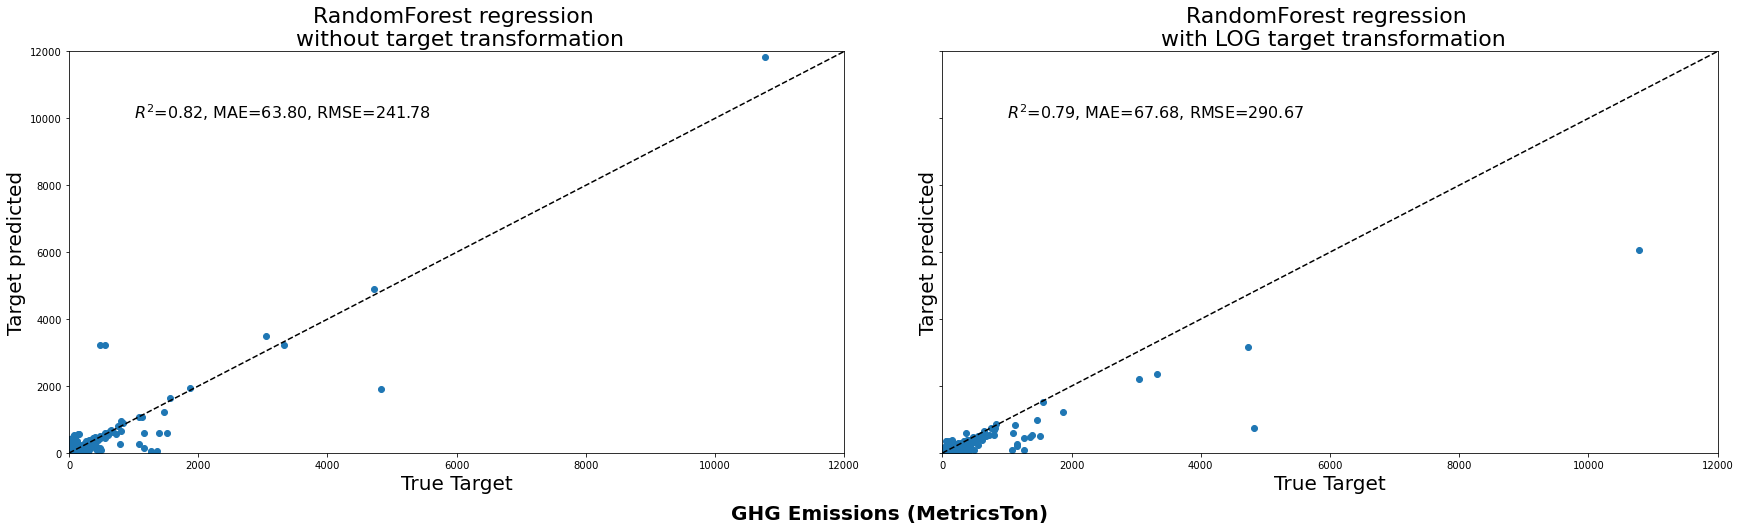

In [1188]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use RandomForest model
start_time77b = time.time()

rfr_GHG = grid_cvrfr.fit(X_train, Y_train['GHGEmissions(MetricTonsCO2e)'])

Y_pred = rfr_GHG.predict(X_test)
tm77b = time.time() - start_time77b

# Plot results
ax0.scatter(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
ax0.plot([0, 12e3], [0, 12e3], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('RandomForest regression \n without target transformation', size = 22)
r2_test77b = r2_score(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
MAE_test77b = mean_absolute_error(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
RMSE_test77b = np.sqrt(mean_squared_error(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred))
ax0.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test77b, MAE_test77b, RMSE_test77b), size = 16)
ax0.set_xlim([0, 12e3])
ax0.set_ylim([0, 12e3])

# ##################################################################################
# Transform targets and use same RandomForest model
start_time_77b = time.time()

rfr_GHG_log = grid_cvrfr_log.fit(X_train, Y_train['LogGHG'])
Y_pred = rfr_GHG_log.predict(X_test)
tm_77b = time.time() - start_time_77b

ax1.scatter(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred))
ax1.plot([0, 12e3], [0, 12e3], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('RandomForest regression \n with LOG target transformation', size = 22)
r2_test_77b = r2_score(Y_test['LogGHG'], Y_pred)
MAE_test_77b = mean_absolute_error(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred))
RMSE_test_77b = np.sqrt(mean_squared_error(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred)))
ax1.text(1e3, 1e4, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test_77b, MAE_test_77b, RMSE_test_77b), size = 16)
ax1.set_xlim([0, 12e3])
ax1.set_ylim([0, 12e3])

f.suptitle("GHG Emissions (MetricsTon) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', rfr_GHG.best_params_)
print('Best parameters log scale:', rfr_GHG_log.best_params_)

### 2-8) XGBOOST REGRESSION

XGBoost was developed to increase speed and performance, while introducing regularization parameters to reduce overfitting. Gradient boosted trees use regression trees in a sequential learning process as weak learners. These regression trees are similar to decision trees, however, they use a continuous score assigned to each leaf (i.e. the last node once the tree has finished growing) which is summed up and provides the final prediction.<br>
The hyperparameters we consider here are the learning rate, maximum depth of trees, minimum weights in child notes for splitting and number of estimators (trees). While higher values for the number of estimators and weights in child notes are associated with decreased overfitting, the learning rate and maximum depth need to have lower values to achieve reduced overfitting. Yet, extreme values will lead to underfitting of the model.


#### SITE ENERGY USE - XGBOOST ON TRAINING DATA

Best parameters lin scale: {'regressor__gamma': 0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 6, 'regressor__min_child_weight': 1.0, 'regressor__n_estimators': 1000}
Best parameters log scale: {'regressor__gamma': 0, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 20, 'regressor__min_child_weight': 1.0, 'regressor__n_estimators': 1000}


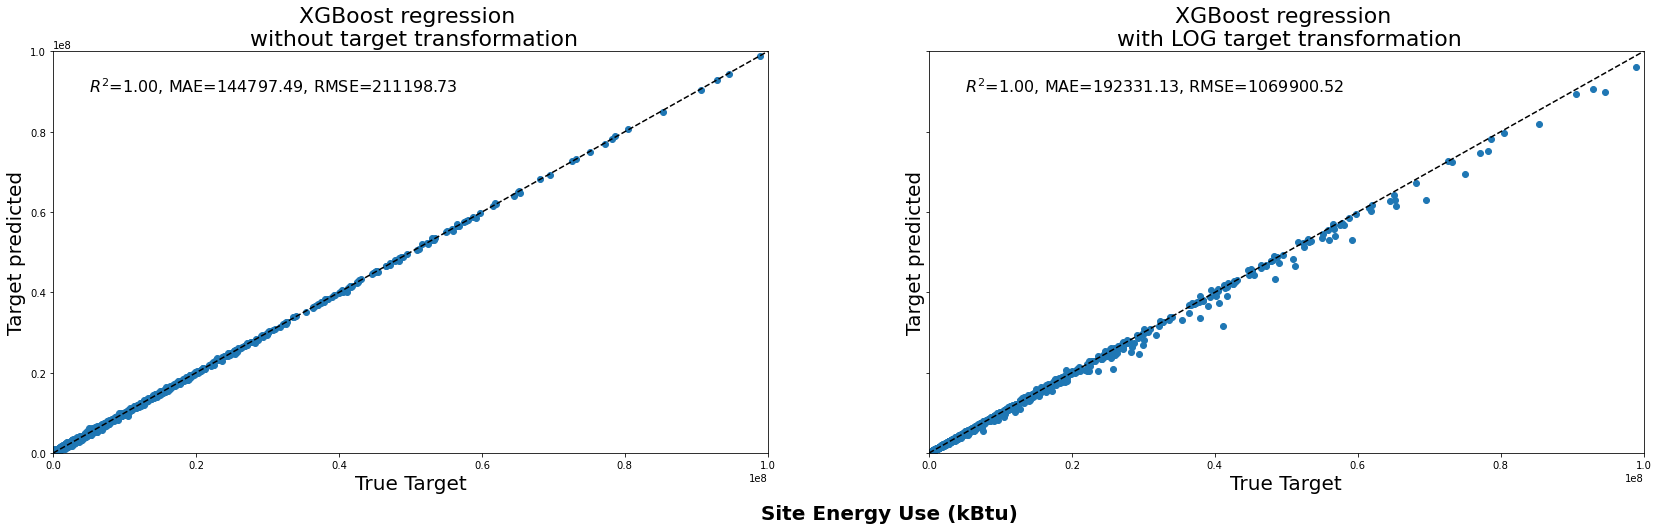

In [1189]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use XGBoost model
start_time8 = time.time()
pipe_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', xgb.XGBRegressor())])

params_xgb = {'regressor__n_estimators': [0, 1000, 100], # Number of trees in XGBoost (default=100)
             'regressor__min_child_weight' : [1.0, 10.0, 1.0], # Minimum sum of instance weight needed in a child (default=1)
             'regressor__max_depth': [6, 20, 1], # Maximum depth of a tree (default=6). Increasing this value will make
                                                 # the model more complex and more likely to overfit.
             'regressor__learning_rate' : [0.001, 0.01, 0.1, 0.2, 0.3], # Weight factor for the corrections by new trees
                                                                        # to slow down the learning
             'regressor__gamma': [0, 10, 0.1]} # Minimum loss reduction required to make a further partition 
                                               # on a leaf node of the tree (default=0)
                     
grid_cvxgb = GridSearchCV(pipe_xgb,
                          param_grid = params_xgb,
                          cv = 5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit = 'neg_mean_absolute_error',
                          n_jobs = -1)

xgb_SEU = grid_cvxgb.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])

Y_pred = xgb_SEU.predict(X_train)
tm8 = time.time() - start_time8

# Plot results
ax0.scatter(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('XGBoost regression \n without target transformation', size = 22)
r2_train8 = r2_score(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
MAE_train8 = mean_absolute_error(Y_train['SiteEnergyUse(kBtu)'], Y_pred)
RMSE_train8 = np.sqrt(mean_squared_error(Y_train['SiteEnergyUse(kBtu)'], Y_pred))
ax0.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train8, MAE_train8, RMSE_train8), size = 16)
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# #################################################################################
# Transform targets and use same XGBoost model
start_time_8 = time.time()

grid_cvxgb_log = GridSearchCV(pipe_xgb,
                          param_grid = params_xgb,
                          cv = 5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit = 'neg_mean_absolute_error',
                          n_jobs = -1)

xgb_SEU_log = grid_cvxgb_log.fit(X_train, Y_train['LogSEU'])
Y_pred = xgb_SEU_log.predict(X_train)
tm_8 = time.time() - start_time_8

ax1.scatter(np.expm1(Y_train['LogSEU']), np.expm1(Y_pred))
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('XGBoost regression \n with LOG target transformation', size = 22)
r2_train_8 = r2_score(Y_train['LogSEU'], Y_pred)
MAE_train_8 = mean_absolute_error(np.expm1(Y_train['LogSEU']), np.expm1(Y_pred))
RMSE_train_8 = np.sqrt(mean_squared_error(np.expm1(Y_train['LogSEU']), np.expm1(Y_pred)))
ax1.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train_8, MAE_train_8, RMSE_train_8), size = 16)
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])


f.suptitle("Site Energy Use (kBtu) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', xgb_SEU.best_params_)
print('Best parameters log scale:', xgb_SEU_log.best_params_)

#### SITE ENERGY USE - XGBOOST ON TEST DATA

Best parameters lin scale: {'regressor__gamma': 0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 6, 'regressor__min_child_weight': 1.0, 'regressor__n_estimators': 1000}
Best parameters log scale: {'regressor__gamma': 0, 'regressor__learning_rate': 0.01, 'regressor__max_depth': 20, 'regressor__min_child_weight': 1.0, 'regressor__n_estimators': 1000}


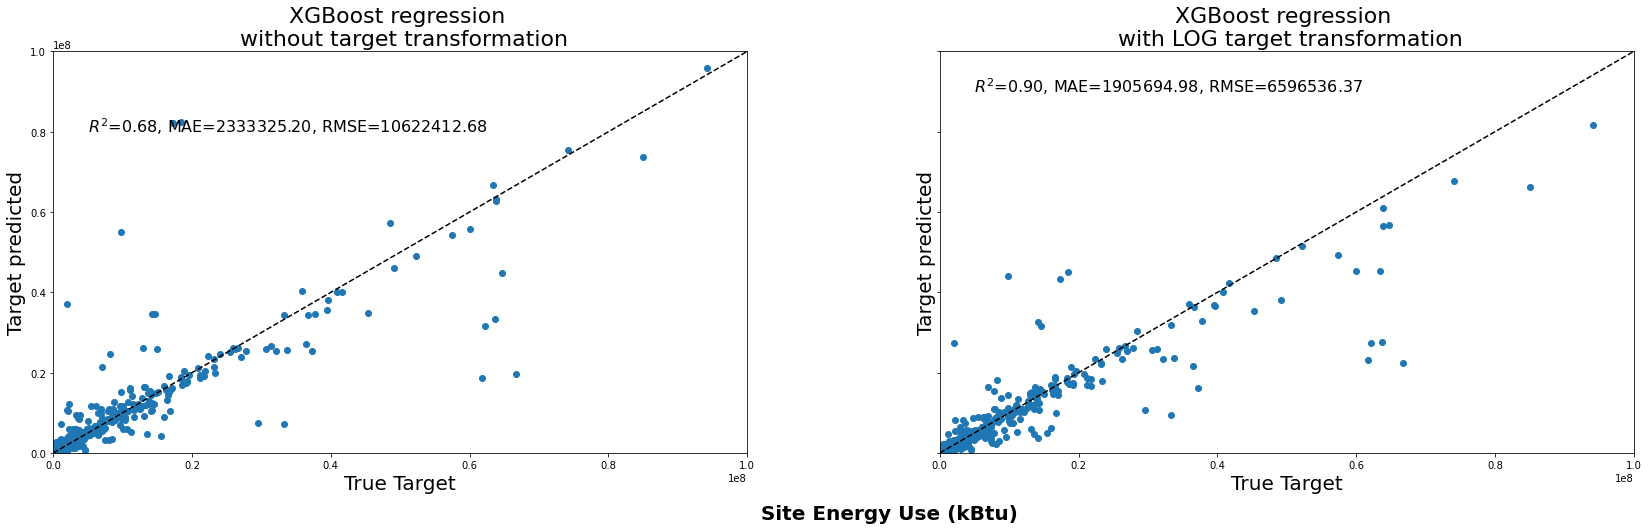

In [1190]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use XGBoost model
start_time88 = time.time()
pipe_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', xgb.XGBRegressor())])

params_xgb = {'regressor__n_estimators': [0, 1000, 100], # Number of trees in XGBoost (default=100)
             'regressor__min_child_weight' : [1.0, 10.0, 1.0], # Minimum sum of instance weight needed in a child (default=1)
             'regressor__max_depth': [6, 20, 1], # Maximum depth of a tree (default=6). Increasing this value will make
                                                 # the model more complex and more likely to overfit.
             'regressor__learning_rate' : [0.001, 0.01, 0.1, 0.2, 0.3], # Weight factor for the corrections by new trees
                                                                        # to slow down the learning
             'regressor__gamma': [0, 10, 0.1]} # Minimum loss reduction required to make a further partition 
                                               # on a leaf node of the tree (default=0)
                     
grid_cvxgb = GridSearchCV(pipe_xgb,
                          param_grid = params_xgb,
                          cv = 5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit = 'neg_mean_absolute_error',
                          n_jobs = -1)

xgb_SEU = grid_cvxgb.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])

Y_pred = xgb_SEU.predict(X_test)
tm88 = time.time() - start_time88

# Plot results
ax0.scatter(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
ax0.plot([0, 1e8], [0, 1e8], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('XGBoost regression \n without target transformation', size = 22)
r2_test88 = r2_score(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
MAE_test88 = mean_absolute_error(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
RMSE_test88 = np.sqrt(mean_squared_error(Y_test['SiteEnergyUse(kBtu)'], Y_pred))
ax0.text(5e6, 8e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test88, MAE_test88, RMSE_test88), size = 16)
ax0.set_xlim([0, 1e8])
ax0.set_ylim([0, 1e8])

# ############################################################################
# Transform targets and use same XGBoost model
start_time_88 = time.time()

grid_cvxgb_log = GridSearchCV(pipe_xgb,
                          param_grid = params_xgb,
                          cv = 5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit = 'neg_mean_absolute_error',
                          n_jobs = -1)

xgb_SEU_log = grid_cvxgb_log.fit(X_train, Y_train['LogSEU'])
Y_pred = xgb_SEU_log.predict(X_test)
tm_88 = time.time() - start_time_88

ax1.scatter(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred))
ax1.plot([0, 1e8], [0, 1e8], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('XGBoost regression \n with LOG target transformation', size = 22)
r2_test_88 = r2_score(Y_test['LogSEU'], Y_pred)
MAE_test_88 = mean_absolute_error(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred))
RMSE_test_88 = np.sqrt(mean_squared_error(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred)))
ax1.text(5e6, 9e7, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test_88, MAE_test_88, RMSE_test_88), size = 16)
ax1.set_xlim([0, 1e8])
ax1.set_ylim([0, 1e8])

f.suptitle("Site Energy Use (kBtu) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', xgb_SEU.best_params_)
print('Best parameters log scale:', xgb_SEU_log.best_params_)

#### GHG EMISSIONS - XGBOOST ON TRAINING DATA

Best parameters lin scale: {'regressor__gamma': 0.1, 'regressor__learning_rate': 0.2, 'regressor__max_depth': 6, 'regressor__min_child_weight': 1.0, 'regressor__n_estimators': 1000}
Best parameters log scale: {'regressor__gamma': 0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 20, 'regressor__min_child_weight': 1.0, 'regressor__n_estimators': 1000}


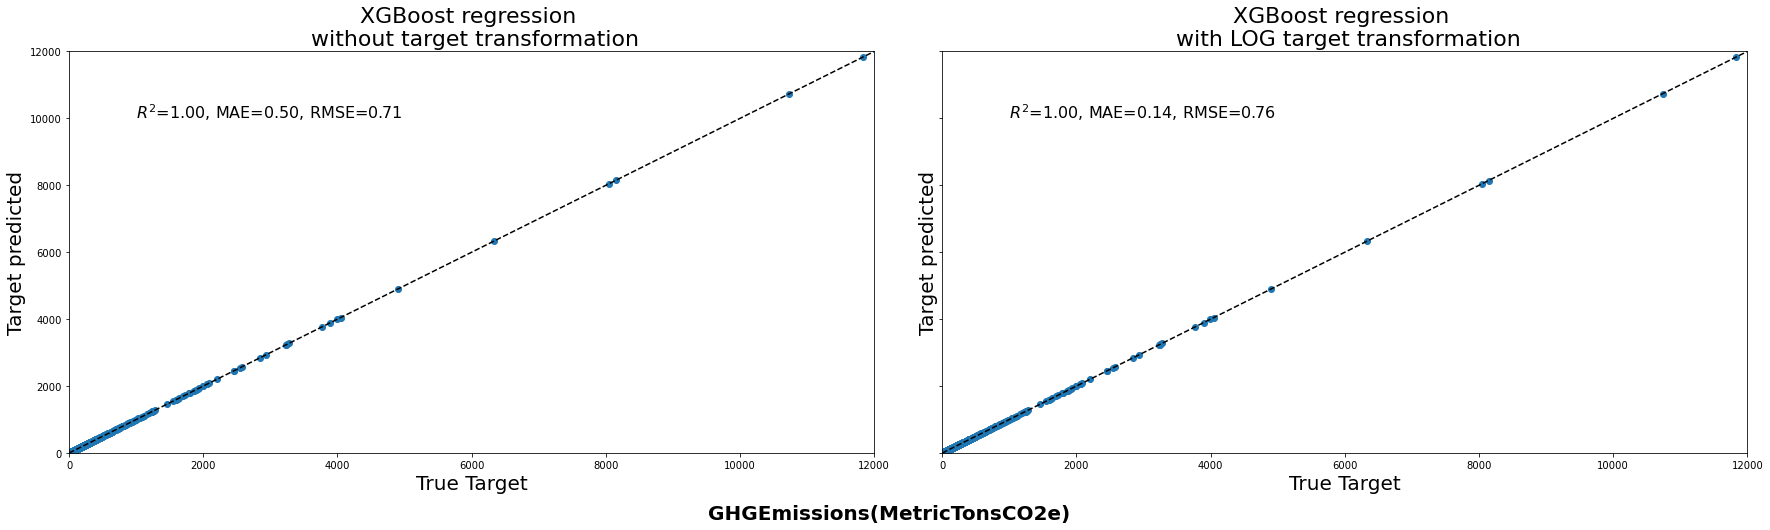

In [1191]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use XGBoost model
start_time8b = time.time()
                    
xgb_GHG = grid_cvxgb.fit(X_train, Y_train['GHGEmissions(MetricTonsCO2e)'])

Y_pred = xgb_GHG.predict(X_train)
tm8b = time.time() - start_time8b

# Plot results
ax0.scatter(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
ax0.plot([0, 12e3], [0, 12e3], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('XGBoost regression \n without target transformation', size = 22)
r2_train8b = r2_score(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
MAE_train8b = mean_absolute_error(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred)
RMSE_train8b = np.sqrt(mean_squared_error(Y_train['GHGEmissions(MetricTonsCO2e)'], Y_pred))
ax0.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train8b, MAE_train8b, RMSE_train8b), size = 16)
ax0.set_xlim([0, 12e3])
ax0.set_ylim([0, 12e3])

# ##############################################################################
# Transform targets and use same XGBoost model
start_time_8b = time.time()

xgb_GHG_log = grid_cvxgb_log.fit(X_train, Y_train['LogGHG'])
Y_pred = xgb_GHG_log.predict(X_train)
tm_8b = time.time() - start_time_8b

ax1.scatter(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred))
ax1.plot([0, 12e3], [0, 12e3], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('XGBoost regression \n with LOG target transformation', size = 22)
r2_train_8b = r2_score(Y_train['LogGHG'], Y_pred)
MAE_train_8b = mean_absolute_error(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred))
RMSE_train_8b = np.sqrt(mean_squared_error(np.expm1(Y_train['LogGHG']), np.expm1(Y_pred)))
ax1.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_train_8b, MAE_train_8b, RMSE_train_8b), size = 16)
ax1.set_xlim([0, 12e3])
ax1.set_ylim([0, 12e3])

f.suptitle("GHGEmissions(MetricTonsCO2e) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', xgb_GHG.best_params_)
print('Best parameters log scale:', xgb_GHG_log.best_params_)

#### GHG EMISSIONS - XGBOOST ON TEST DATA

Best parameters lin scale: {'regressor__gamma': 0.1, 'regressor__learning_rate': 0.2, 'regressor__max_depth': 6, 'regressor__min_child_weight': 1.0, 'regressor__n_estimators': 1000}
Best parameters log scale: {'regressor__gamma': 0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 20, 'regressor__min_child_weight': 1.0, 'regressor__n_estimators': 1000}


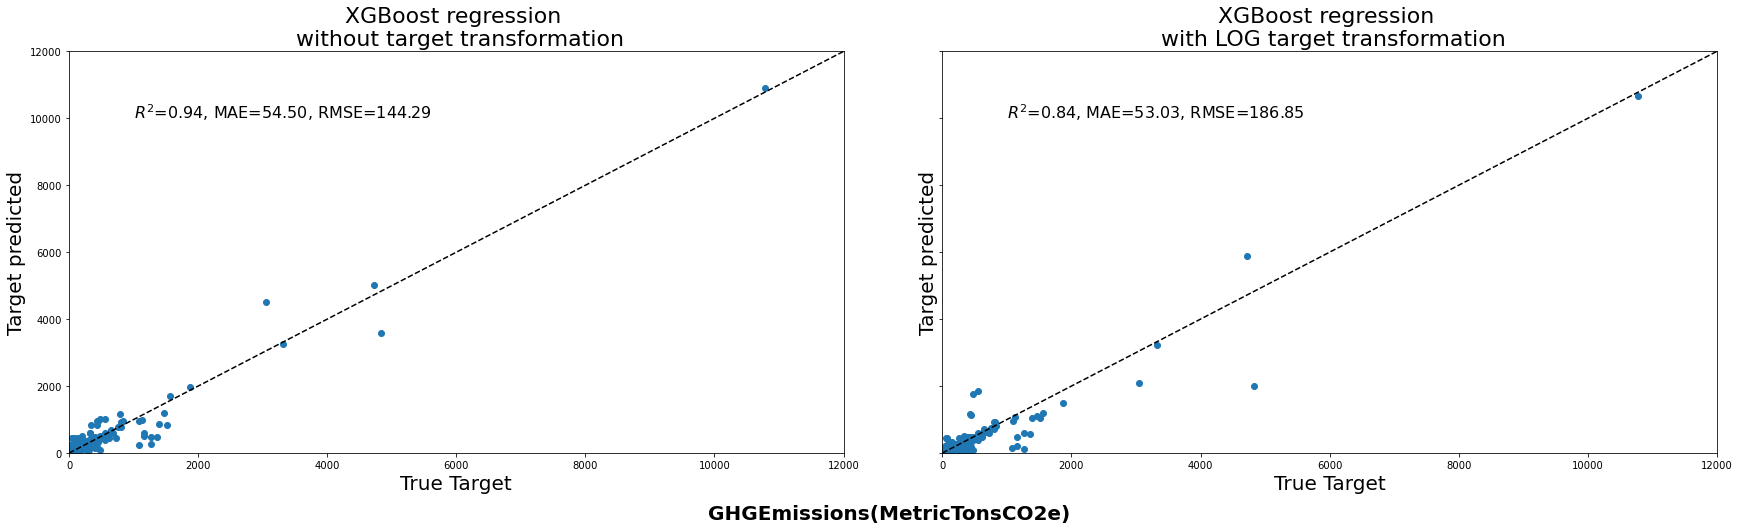

In [1192]:
f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use XGBoost model
start_time88b = time.time()
                    
xgb_GHG = grid_cvxgb.fit(X_train, Y_train['GHGEmissions(MetricTonsCO2e)'])

Y_pred = xgb_GHG.predict(X_test)
tm88b = time.time() - start_time88b

# Plot results
ax0.scatter(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
ax0.plot([0, 12e3], [0, 12e3], '--k')
ax0.set_ylabel('Target predicted', size = 20)
ax0.set_xlabel('True Target', size = 20)
ax0.set_title('XGBoost regression \n without target transformation', size = 22)
r2_test88b = r2_score(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
MAE_test88b = mean_absolute_error(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred)
RMSE_test88b = np.sqrt(mean_squared_error(Y_test['GHGEmissions(MetricTonsCO2e)'], Y_pred))
ax0.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test88b, MAE_test88b, RMSE_test88b), size = 16)
ax0.set_xlim([0, 12e3])
ax0.set_ylim([0, 12e3])

# #########################################################################################
# Transform targets and use same XGBoost model
start_time_88b = time.time()

xgb_GHG_log = grid_cvxgb_log.fit(X_train, Y_train['LogGHG'])
Y_pred = xgb_GHG_log.predict(X_test)
tm_88b = time.time() - start_time_88b

ax1.scatter(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred))
ax1.plot([0, 12e3], [0, 12e3], '--k')
ax1.set_ylabel('Target predicted', size = 20)
ax1.set_xlabel('True Target', size = 20)
ax1.set_title('XGBoost regression \n with LOG target transformation', size = 22)
r2_test_88b = r2_score(Y_test['LogGHG'], Y_pred)
MAE_test_88b = mean_absolute_error(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred))
RMSE_test_88b = np.sqrt(mean_squared_error(np.expm1(Y_test['LogGHG']), np.expm1(Y_pred)))
ax1.text(1e3, 1e4, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test_88b, MAE_test_88b, RMSE_test_88b), size = 16)
ax1.set_xlim([0, 12e3])
ax1.set_ylim([0, 12e3])

f.suptitle("GHGEmissions(MetricTonsCO2e) ", x = 1.25, y=0.005, weight = 'bold', size = 20)
f.tight_layout(rect=[0.005, 0.005, 2.5, 1.5])
print('Best parameters lin scale:', xgb_GHG.best_params_)
print('Best parameters log scale:', xgb_GHG_log.best_params_)

### 2-9) RESULTS DATAFRAME 


#### 2-9-1) SITE ENERGY USE

In [1193]:
results = ['R2 Train', 'R2 Test', 'MAE Train', "MAE Test", "RMSE Train", "RMSE Test", 'Running time(s) Train', 'Running time(s) Test']
reg_met_SEU = {'dummy' : pd.Series([r2_train0a, r2_test0a, MAE_train0a, MAE_test0a, RMSE_train0a, RMSE_test0a, np.nan, tm0a],
                        index = results),    
           'Linear lin' : pd.Series([r2_train1, r2_test11, MAE_train1, MAE_test11, RMSE_train1, RMSE_test11, tm1, tm11],
                        index = results),
           'Linear Log' : pd.Series([r2_train_1, r2_test_11, MAE_train_1, MAE_test_11, RMSE_train_1, RMSE_test_11, tm_1, tm_11],
                        index = results),    
           'Lasso lin' : pd.Series([r2_train2, r2_test22, MAE_train2, MAE_test22, RMSE_train2, RMSE_test22, tm2, tm22],
                        index = results),
           'Lasso Log' : pd.Series([r2_train_2, r2_test_22, MAE_train_2, MAE_test_22, RMSE_train_2, RMSE_test_22, tm_2, tm_22],
                        index = results),
           'Ridge lin' : pd.Series([r2_train3, r2_test33, MAE_train3, MAE_test33, RMSE_train3, RMSE_test33, tm3, tm33],
                        index = results),
           'Ridge Log' : pd.Series([r2_train_3, r2_test_33, MAE_train_3, MAE_test_33, RMSE_train_3, RMSE_test_33, tm_3, tm_33],
                        index = results),
           'ElasticNet lin' : pd.Series([r2_train4, r2_test44, MAE_train4, MAE_test44, RMSE_train4, RMSE_test44, tm4, tm44],
                        index = results),
           'ElasticNet Log' : pd.Series([r2_train_4, r2_test_44, MAE_train_4, MAE_test_44, RMSE_train_4, RMSE_test_44, tm_4, tm_44],
                        index = results),
           'KNN lin' : pd.Series([r2_train5, r2_test55, MAE_train5, MAE_test55, RMSE_train5, RMSE_test55, tm5, tm55],
                        index = results),
           'KNN Log' : pd.Series([r2_train_5, r2_test_55, MAE_train_5, MAE_test_55, RMSE_train_5, RMSE_test_55, tm_5, tm_55],
                        index = results),
#           'SVM lin' : pd.Series([r2_train6, r2_test66, MAE_train6, MAE_test66, RMSE_train6, RMSE_test66 ,tm6, tm66],
#                        index = results),
#           'SVM Log' : pd.Series([r2_train_6, r2_test_66, MAE_train_6, MAE_test_66, RMSE_train_6, RMSE_test_66 ,tm_6, tm_66],
#                        index = results),
           'RandomForest lin' : pd.Series([r2_train7, r2_test77, MAE_train7, MAE_test77, RMSE_train7, RMSE_test77, tm7, tm77],
                        index = results),
           'RandomForest Log' : pd.Series([r2_train_7, r2_test_77, MAE_train_7, MAE_test_77, RMSE_train_7, RMSE_test_77, tm_7, tm_77],
                        index = results),
           'XGBoost lin' : pd.Series([r2_train8, r2_test88, MAE_train8, MAE_test88, RMSE_train8, RMSE_test88, tm8, tm88],
                        index = results),
           'XGBoost Log' : pd.Series([r2_train_8, r2_test_88, MAE_train_8, MAE_test_88, RMSE_train_8, RMSE_test_88, tm_8, tm_88],
                        index = results)}

# Creates Dataframe df_results_SEU for Site Energy Use

df_results_SEU = pd.DataFrame(reg_met_SEU)
index = df_results_SEU.index
index. name = "Metrics"
df_results_SEU.round(2)

,dummy,Linear lin,Linear Log,Lasso lin,Lasso Log,Ridge lin,Ridge Log,ElasticNet lin,ElasticNet Log,KNN lin,KNN Log,RandomForest lin,RandomForest Log,XGBoost lin,XGBoost Log
Metrics,,,,,,,,,,,,,,,
R2 Train,0.00,0.65,6.300000e-01,0.64,6.300000e-01,0.61,6.200000e-01,0.59,6.300000e-01,0.82,0.82,1.00,1.00,1.00,1.00
R2 Test,-0.00,0.66,6.500000e-01,0.65,6.500000e-01,0.66,6.500000e-01,0.65,6.500000e-01,0.56,0.62,0.87,0.86,0.68,0.90
MAE Train,8556637.98,4325960.21,1.554374e+07,4258636.76,1.329830e+07,4276961.08,1.357950e+07,4257539.99,1.329830e+07,2463235.46,2686437.19,0.00,0.00,144797.49,192331.13
MAE Test,8592903.43,4495190.99,5.383057e+06,4415381.19,5.406773e+06,4435630.43,5.383655e+06,4373391.92,5.406773e+06,4211900.38,4195587.55,2419710.52,2401576.43,2333325.20,1905694.98
RMSE Train,21109220.36,12518439.79,3.540590e+08,12675826.35,3.473249e+08,13190182.33,3.539295e+08,13464821.96,3.473249e+08,9009692.60,12080700.16,0.00,0.00,211198.73,1069900.52
RMSE Test,18720512.46,10835465.06,2.767312e+07,11023768.14,2.799754e+07,10950609.18,2.785002e+07,11037332.71,2.799754e+07,12387785.71,13756364.84,6819156.39,8222430.55,10622412.68,6596536.37
Running time(s) Train,NaN,0.06,5.000000e-02,8.20,1.350000e+00,1.00,1.030000e+00,123.38,2.112000e+01,5.12,5.00,256.85,255.59,823.45,574.63
Running time(s) Test,0.00,0.05,5.000000e-02,3.85,1.360000e+00,0.98,1.020000e+00,124.52,2.090000e+01,4.75,4.69,263.50,264.17,826.32,576.20


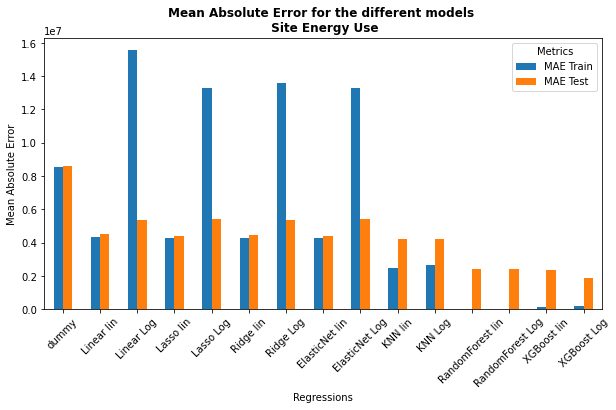

In [1194]:
df_SEU = df_results_SEU.T
plt.rcParams["figure.figsize"] = (10, 5)
df_SEU1 = df_SEU[["MAE Train", "MAE Test"]].plot( y=["MAE Train", "MAE Test"], kind="bar", rot = 45)
plt.xlabel("Regressions")
plt.ylabel("Mean Absolute Error")
plt.title("Mean Absolute Error for the different models \n Site Energy Use", weight = 'bold')

plt.show()

From the above chart, we can clearly see that the Mean Absolute Error differ quite significantly from the linear models to the non linear models. Transforming our targets to log scale also have an impact on the errors.<br>

1) On a general basis and on a linear scale, the MAE remains quite constant between the train & the test. MAE on the test is slightly higher than on the train - the model has already seen the training set during training. So its easier to score high accuracy on training set. Test set on the other hand is unseen so we generally expect Test MAE to be higher as it more difficult to perform well on unseen data.<br>

2) However, for the linear models, transforming our targets to log scale increases the MAE on the training set. Test MAE is lower

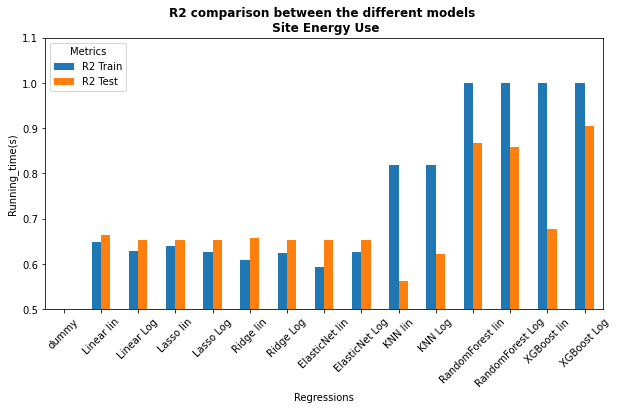

In [1195]:
plt.rcParams["figure.figsize"] = (10, 5)
df_SEU22 = df_SEU.plot( y=["R2 Train", "R2 Test"], kind="bar", rot = 45)
plt.xlabel("Regressions")
plt.ylabel("Running_time(s)")
plt.ylim([0.5, 1.1])
plt.title('R2 comparison between the different models \n Site Energy Use', weight = "bold")
plt.show()

As seen from the results and graph above

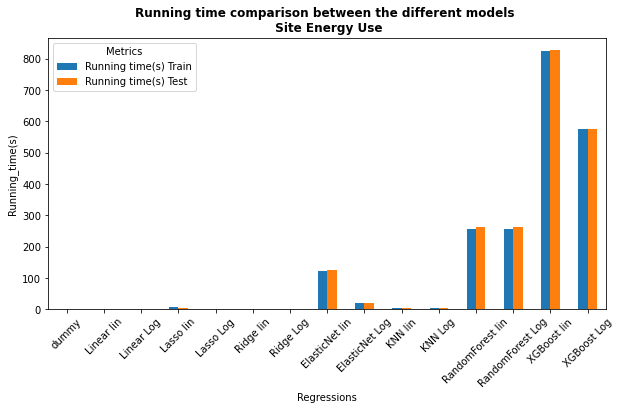

In [1196]:
plt.rcParams["figure.figsize"] = (10, 5)
df_SEU22 = df_SEU.plot( y=["Running time(s) Train", "Running time(s) Test"], kind="bar", rot = 45)
plt.xlabel("Regressions")
plt.ylabel("Running_time(s)")
plt.title('Running time comparison between the different models \n Site Energy Use', weight = "bold")
plt.show()

#### 2-9-2) GHG EMISSIONS

In [1197]:
results = ['R2 Train', 'R2 Test', 'MAE Train', "MAE Test", "RMSE Train", "RMSE Test", 'Running time(s) Train', 'Running time(s) Test']
reg_met_GHG = {'dummy' : pd.Series([np.nan, r2_test_00, np.nan, MAE_test_00, np.nan, RMSE_test_00, np.nan, tm_0b],
                        index = results),    
           'Linear lin' : pd.Series([r2_train1b, r2_test11b, MAE_train1b, MAE_test11b, RMSE_train1b, RMSE_test11b, tm1b, tm11b],
                        index = results),
           'Linear Log' : pd.Series([r2_train_1b, r2_test_11b, MAE_train_1b, MAE_test_11b, RMSE_train_1b, RMSE_test_11b, tm_1b, tm_11b],
                        index = results),    
           'Lasso lin' : pd.Series([r2_train2b, r2_test22b, MAE_train2b, MAE_test22b, RMSE_train2b, RMSE_test22b, tm2b, tm22b],
                        index = results),
           'Lasso Log' : pd.Series([r2_train_2b, r2_test_22b, MAE_train_2b, MAE_test_22b, RMSE_train_2b, RMSE_test_22b, tm_2b, tm_22b],
                        index = results),
           'Ridge lin' : pd.Series([r2_train3b, r2_test33b, MAE_train3b, MAE_test33b, RMSE_train3b, RMSE_test33b, tm3b, tm33b],
                        index = results),
           'Ridge Log' : pd.Series([r2_train_3b, r2_test_33b, MAE_train_3b, MAE_test_33b, RMSE_train_3b, RMSE_test_33b, tm_3b, tm_33b],
                        index = results),
           'ElasticNet lin' : pd.Series([r2_train4b, r2_test44b, MAE_train4b, MAE_test44b, RMSE_train4b, RMSE_test44b, tm4b, tm44b],
                        index = results),
           'ElasticNet Log' : pd.Series([r2_train_4b, r2_test_44b, MAE_train_4b, MAE_test_44b, RMSE_train_4b, RMSE_test_44b, tm_4b, tm_44b],
                        index = results),
           'KNN lin' : pd.Series([r2_train5b, r2_test55b, MAE_train5b, MAE_test55b, RMSE_train5b, RMSE_test55b, tm5b, tm55b],
                        index = results),
           'KNN Log' : pd.Series([r2_train_5b, r2_test_55b, MAE_train_5b, MAE_test_55b, RMSE_train_5b, RMSE_test_55b, tm_5b, tm_55b],
                        index = results),
#           'SVM lin' : pd.Series([r2_train_6b, r2_test_66b, MAE_train_6b, MAE_test_66b, RMSE_train_6b, RMSE_test_66b, tm_6b, tm_66b],
#                        index = results),
#           'SVM Log' : pd.Series([r2_train_6b, r2_test_66b, MAE_train_6b, MAE_test_66b, RMSE_train_6b, RMSE_test_66b, tm_6b, tm_66b],
#                        index = results),  
           'RandomForest lin' : pd.Series([r2_train7b, r2_test77b, MAE_train7b, MAE_test77b, RMSE_train7b, RMSE_test77b, tm7b, tm77b],
                        index = results),
           'RandomForest Log' : pd.Series([r2_train_7b, r2_test_77b, MAE_train_7b, MAE_test_77b, RMSE_train_7b, RMSE_test_77b, tm_7b, tm_77b],
                        index = results),
           'XGBoost lin' : pd.Series([r2_train8b, r2_test88b, MAE_train8b, MAE_test88b, RMSE_train8b, RMSE_test88b, tm8b, tm88b],
                        index = results),
           'XGBoost Log' : pd.Series([r2_train_8b, r2_test_88b, MAE_train_8b, MAE_test_88b, RMSE_train_8b, RMSE_test_88b, tm_8b, tm_88b],
                        index = results)}

# Creates Dataframe df_results_GHG for GHG Emissions

df_results_GHG = pd.DataFrame(reg_met_GHG)
index = df_results_GHG.index
index. name = "Metrics"
df_results_GHG.round(2)


,dummy,Linear lin,Linear Log,Lasso lin,Lasso Log,Ridge lin,Ridge Log,ElasticNet lin,ElasticNet Log,KNN lin,KNN Log,RandomForest lin,RandomForest Log,XGBoost lin,XGBoost Log
Metrics,,,,,,,,,,,,,,,
R2 Train,NaN,0.56,0.51,0.53,0.51,0.54,0.50,0.53,0.51,0.75,0.75,1.00,1.00,1.00,1.00
R2 Test,-0.00,0.57,0.52,0.57,0.51,0.57,0.51,0.57,0.51,0.39,0.45,0.82,0.79,0.94,0.84
MAE Train,NaN,148.54,436.54,139.69,431.06,147.25,437.29,139.69,431.06,73.75,81.91,0.00,0.00,0.50,0.14
MAE Test,199.17,147.55,146.61,137.77,147.28,144.45,146.21,137.77,147.28,125.05,120.14,63.80,67.68,54.50,53.03
RMSE Train,NaN,445.82,13942.19,459.91,13586.43,455.55,13694.78,459.91,13586.43,334.30,452.97,0.00,0.00,0.71,0.76
RMSE Test,570.21,372.78,898.20,375.05,904.61,373.26,904.84,375.05,904.61,444.52,492.82,241.78,290.67,144.29,186.85
Running time(s) Train,NaN,0.06,0.06,2.49,1.63,1.13,1.00,72.86,22.63,5.05,4.85,266.45,253.64,734.02,713.06
Running time(s) Test,0.06,0.05,0.05,2.38,1.56,1.03,1.00,73.17,23.36,4.74,4.70,266.13,251.15,737.70,709.90


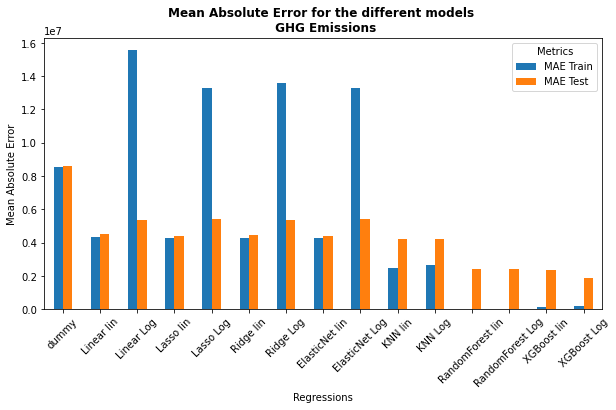

In [1198]:
df_GHG = df_results_GHG.T
plt.rcParams["figure.figsize"] = (10, 5)
df_SEU1 = df_SEU[["MAE Train", "MAE Test"]].plot( y=["MAE Train", "MAE Test"], kind="bar", rot = 45)
plt.xlabel("Regressions")
plt.ylabel("Mean Absolute Error")
plt.title("Mean Absolute Error for the different models \n GHG Emissions", weight = 'bold')

plt.show()

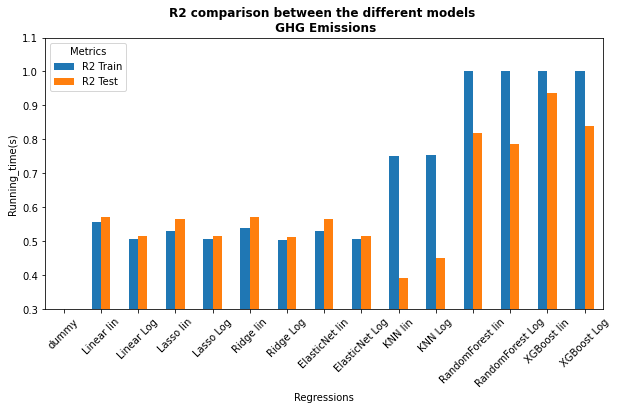

In [1199]:
plt.rcParams["figure.figsize"] = (10, 5)
df_GHG22 = df_GHG.plot( y=["R2 Train", "R2 Test"], kind="bar", rot = 45)
plt.xlabel("Regressions")
plt.ylabel("Running_time(s)")
plt.ylim([0.3, 1.1])
plt.title('R2 comparison between the different models \n GHG Emissions', weight = "bold")
plt.show()

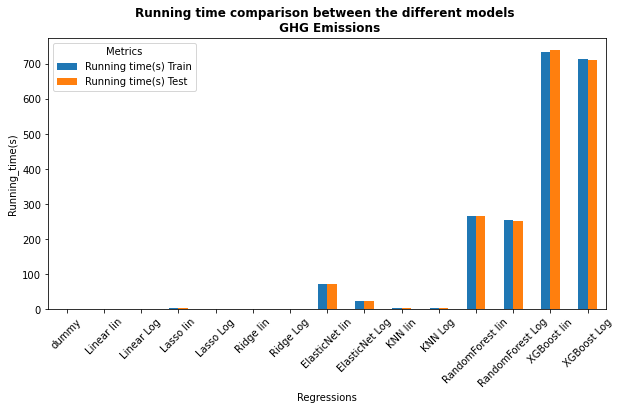

In [1200]:
plt.rcParams["figure.figsize"] = (10, 5)
df_GHG22 = df_GHG.plot( y=["Running time(s) Train", "Running time(s) Test"], kind="bar", rot = 45)
plt.xlabel("Regressions")
plt.ylabel("Running_time(s)")
plt.title('Running time comparison between the different models \n GHG Emissions', weight = "bold")
plt.show()

Based on these results, ensemble methods proved to be more efficient than linear regressions. The lowest MAE was generated by XGBoost regression after transforming our targets to log. RandomForest regression comes closed second.

Like random forests, XGBoost is a set of decision trees. The two main differences are:

__How trees are built:__ random forests builds each tree independently while gradient boosting builds one tree at a time. This additive model (ensemble) works in a forward stage-wise manner, introducing a weak learner to improve the shortcomings of existing weak learners.<br> 
__Combining results:__ random forests combine results at the end of the process (by averaging or "majority rules") while gradient boosting combines results along the way.<br>

One of the striking difference between our Random Forest and XGBoost regressions is the computational time which is almost 4 times higher for the XGBoost. <br>
This can be partly explained by the number of trees in the hyperparameters.<br>
In our RandomForest regression, we decided not to tune the number of trees as few studies have shown that (sic) "although we claim that increasing the number of trees cannot harm noticeably as far as measures based on average loss are considered, our empirical results show that for most of the examined datasets, the biggest performance gain is achieved when training the first 100 trees".(ref: https://www.jmlr.org/papers/volume18/17-269/17-269.pdf)<br>

Based on this paper, we decided to keep a default value of 100 for the number of trees in the Random Forest regression as opposed to a range of [0-1000] for XGBoost parameters.<br>

A quick sensitivity study was performed to check the impact of integrating the number of trees as an hyperparameter in the Random Forest regression. Running time and scoring parameter (MAE) were then compared.

__SENSITIVITY ON THE HYPERPARAMETER: NUMBER OF TREES IN RANDOMFOREST REGRESSION__

In [1201]:
# Use RandomForest model
start_time07 = time.time()

params_rfr = {'regressor__n_estimators': [0, 1000, 100], # We allow the creation of 1000 trees
             'regressor__max_features' : ['auto', 'sqrt', 'log2'], 
             'regressor__max_depth': [5, 15, 25, 50, 100], 
             'regressor__min_samples_split': [2, 5, 10], 
             'regressor__bootstrap' : [True, False], 
             'regressor__min_samples_leaf': [1,2,5,10]} 


grid_cvrfr = GridSearchCV(pipe_rfr,
                          param_grid=params_rfr,
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)

rfr_SEU = grid_cvrfr.fit(X_train, Y_train['SiteEnergyUse(kBtu)'])

Y_pred = rfr_SEU.predict(X_test)
tm07 = time.time() - start_time07

r2_test07 = r2_score(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
MAE_test07 = mean_absolute_error(Y_test['SiteEnergyUse(kBtu)'], Y_pred)
RMSE_test07 = np.sqrt(mean_squared_error(Y_test['SiteEnergyUse(kBtu)'], Y_pred))

# #################################################################################
# Transform targets and use same RandomForest model
start_time071 = time.time()

grid_cvrfr_log = GridSearchCV(pipe_rfr,
                          param_grid=params_rfr,
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)


rfr_SEU_log = grid_cvrfr_log.fit(X_train, Y_train['LogSEU'])
Y_pred = rfr_SEU_log.predict(X_test)
tm071 = time.time() - start_time071

r2_test071 = r2_score(Y_test['LogSEU'], Y_pred)
MAE_test071 = mean_absolute_error(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred))
RMSE_test071 = np.sqrt(mean_squared_error(np.expm1(Y_test['LogSEU']), np.expm1(Y_pred)))

print('Best parameters lin scale:', rfr_SEU.best_params_)
print('Best parameters log scale:', rfr_SEU_log.best_params_)


Best parameters lin scale: {'regressor__bootstrap': False, 'regressor__max_depth': 100, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 1000}
Best parameters log scale: {'regressor__bootstrap': False, 'regressor__max_depth': 50, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 1000}


In [1202]:
results = ['R2 Test', "MAE Test", "RMSE Test", 'Running time(s) Test']
sens_rf = {'RandomForest nb trees no tuning (Linear)' : pd.Series([r2_test77, MAE_test77, RMSE_test77, tm77],
                        index = results),
           'RandomForest nb trees tuning (Linear)' : pd.Series([r2_test07, MAE_test07, RMSE_test07, tm07],
                        index = results),
           'RandomForest nb trees no tuning (Log)' : pd.Series([r2_test_77, MAE_test_77, RMSE_test_77, tm_77],
                        index = results),
           'RandomForest nb trees tuning (Log)' : pd.Series([r2_test071, MAE_test071, RMSE_test071,tm071],
                        index = results)}

# Creates Dataframe df_results_SEU for Site Energy Use

df_results_sens_rf = pd.DataFrame(sens_rf)
index = df_results_sens_rf.index
index. name = "Metrics"
df_results_sens_rf.round(2)

,RandomForest nb trees no tuning (Linear),RandomForest nb trees tuning (Linear),RandomForest nb trees no tuning (Log),RandomForest nb trees tuning (Log)
Metrics,,,,
R2 Test,0.87,0.86,0.86,0.86
MAE Test,2419710.52,2414480.56,2401576.43,2428836.49
RMSE Test,6819156.39,6915369.12,8222430.55,8388191.17
Running time(s) Test,263.50,2795.05,264.17,2742.54


As seen on the results above, a RandomForest regression with no tuning on the number of trees (default=100) almost returns the same score as if we incorporated the possibility to create 1000 trees.  By looking at the running time of both algorithms, a factor x10 can be observed. The linear & log scaled model created 1000 trees (instead of 100) for almost the same error.

__FEATURES IMPORTANCE__

In [1203]:
#feature_importance = rfr_GHG_log.best_estimator_.feature_importances_
#feature_importances = rfr_GHG_log.best_estimator_._final_estimator.feature_importances_
#features_names = rfr_GHG_log.vocabulary_
#rfr_GHG_log.feature_names = list(X_train.columns)
#std = np.std([
#    tree.feature_importances_ for tree in rfr_GHG_log.named_steps['grid_search_rfr'].best_estimator_.regressor_], axis=0)
#df_feature_importance = pd.Series(feature_importance, index=features_names)



feature_names = list(X.columns)
importances = rfr_GHG_log.best_estimator_._final_estimator.feature_importances_
#rfr_GHG_log.best_estimator_._final_estimator.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rfr_GHG_log.best_estimator_._final_estimator], axis=0)
importances
#forest_importances = pd.Series(importances, index=feature_names)

# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=std, ax=ax)
# ax.set_title("Feature importances")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()


array([8.23453545e-03, 6.22816844e-02, 1.57338641e-01, 6.21914783e-02,
       5.46286126e-02, 5.70639130e-02, 1.43192653e-01, 1.05507098e-01,
       1.42168310e-02, 1.51722015e-02, 2.57028756e-03, 2.48141334e-03,
       6.79392723e-03, 6.43596469e-03, 4.10896922e-03, 6.00760629e-05,
       9.17219064e-04, 2.98849071e-03, 1.07318235e-02, 1.09583783e-02,
       2.24799879e-03, 1.08446872e-03, 1.53908318e-02, 2.85983613e-04,
       1.68063056e-03, 5.50178228e-03, 5.98115193e-03, 9.41077285e-03,
       1.54224036e-03, 8.45313328e-04, 2.10315703e-03, 3.25637904e-03,
       2.63529973e-05, 6.86338462e-03, 3.92531617e-03, 1.32720986e-02,
       1.01096397e-02, 1.50559603e-03, 5.18660253e-03, 2.51253616e-03,
       2.09340117e-03, 2.16041361e-03, 1.91916653e-03, 7.20124993e-05,
       8.33959505e-03, 6.07153825e-03, 1.14640057e-02, 3.59447863e-03,
       4.52983566e-03, 2.22054116e-03, 3.49281975e-03, 2.62176125e-03,
       2.06990973e-03, 2.59767883e-03, 1.16217816e-04, 8.29242207e-04,
      

### 2-10) LINEAR REGRESSION FROM SITE ENERGY USE TO GHG EMISSIONS

GHG Emissions are somehow related to to Site Energy Use

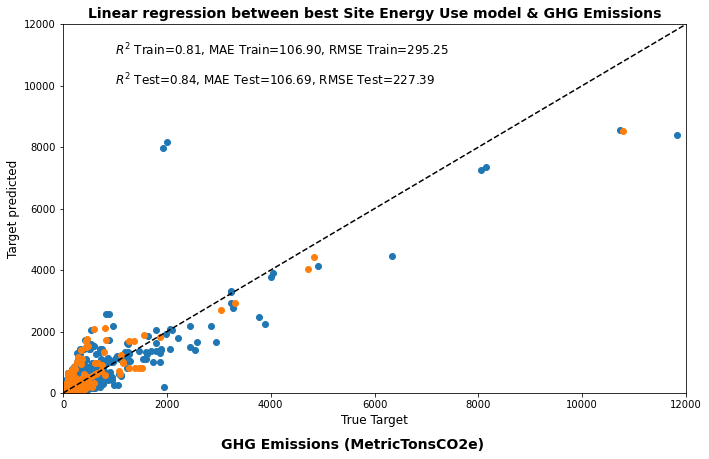

In [1204]:
f, ax0 = plt.subplots()

start_time_best = time.time()
regr = LinearRegression()

# Test fitting best model (XGBoost) on Site Energy Use to GHG Emissions through a simple linear model
xgb_SEU_new = grid_cvxgb_log.fit(X, y['SiteEnergyUse(kBtu)'])

X_new = xgb_SEU_new.predict(X)
Y_new = y['GHGEmissions(MetricTonsCO2e)']

X_new_df = pd.DataFrame(X_new)
Y_new_df = pd.DataFrame(Y_new)

X_new_df_train, X_new_df_test, Y_new_df_train, Y_new_df_test = train_test_split(X_new_df, Y_new_df, test_size=0.2, random_state=42)

GHG_forecast = regr.fit(X_new_df_train, Y_new_df_train)
Y_pred_new = GHG_forecast.predict(X_new_df_train)

tm_best = time.time() - start_time_best

# Plot results
ax0.scatter(Y_new_df_train, Y_pred_new)
ax0.plot([0, 12e3], [0, 12e3], '--k')
ax0.set_ylabel('Target predicted', size = 12)
ax0.set_xlabel('True Target', size = 12)
r2_test = r2_score(Y_new_df_train, Y_pred_new)
MAE_test = mean_absolute_error(Y_new_df_train, Y_pred_new)
RMSE_test = np.sqrt(mean_squared_error(Y_new_df_train, Y_pred_new))
ax0.text(1000, 11000, r'$R^2$ Train=%.2f, MAE Train=%.2f, RMSE Train=%.2f' % (r2_test, MAE_test, RMSE_test), size = 12)
ax0.set_xlim([0, 12e3])
ax0.set_ylim([0, 12e3])

# # Transform targets and use same linear model
# start_timeb = time.time()

Y_pred_new_test = GHG_forecast.predict(X_new_df_test)

# Plot results
ax0.scatter(Y_new_df_test, Y_pred_new_test)
#ax0.set_xlabel('True Target', size = 12)
ax0.set_title('Linear regression between best Site Energy Use model & GHG Emissions', weight = 'bold', size = 14)
r2_test = r2_score(Y_new_df_test, Y_pred_new_test)
MAE_test = mean_absolute_error(Y_new_df_test, Y_pred_new_test)
RMSE_test = np.sqrt(mean_squared_error(Y_new_df_test, Y_pred_new_test))
ax0.text(1000, 10000, r'$R^2$ Test=%.2f, MAE Test=%.2f, RMSE Test=%.2f' % (r2_test, MAE_test, RMSE_test), size = 12)
#ax0.set_xlim([0, 12e3])
#ax0.set_ylim([0, 12e3])

f.suptitle("GHG Emissions (MetricTonsCO2e)", x = 0.5, y=0.005, weight = 'bold', size = 14)
f.tight_layout(rect=[0.005, 0.005, 1, 1.3])

### 3) IMPACT OF ENERGYSTARScore

The Energy Star score of a building is a way to asses the energy usage performance of a building by comparing it with similar buildings. It assigns a number to the building in between 0-100 based on its performance. A score of 0 would mean that the building performs the worst among the similar buildings registered to the program and a score of 100 would mean that the building is the best performer. Similarly, a score of 75 or higher means the building is a top performer and may be eligible for ENERGY STAR certification.

In [1205]:
# Data Selection 

df_data['LogSEU'] = np.log1p(df_data['SiteEnergyUse(kBtu)'])
df_data['LogGHG'] = np.log1p(df_data['GHGEmissions(MetricTonsCO2e)'])
df_energystar = df_data.dropna(subset = ["ENERGYSTARScore"])
Xstar = df_energystar.drop(['SiteEnergyUse(kBtu)', 'GHGEmissions(MetricTonsCO2e)', 'LogSEU', 'LogGHG'], axis=1)
Ystar = df_energystar[['SiteEnergyUse(kBtu)','GHGEmissions(MetricTonsCO2e)', 'LogSEU', 'LogGHG']]


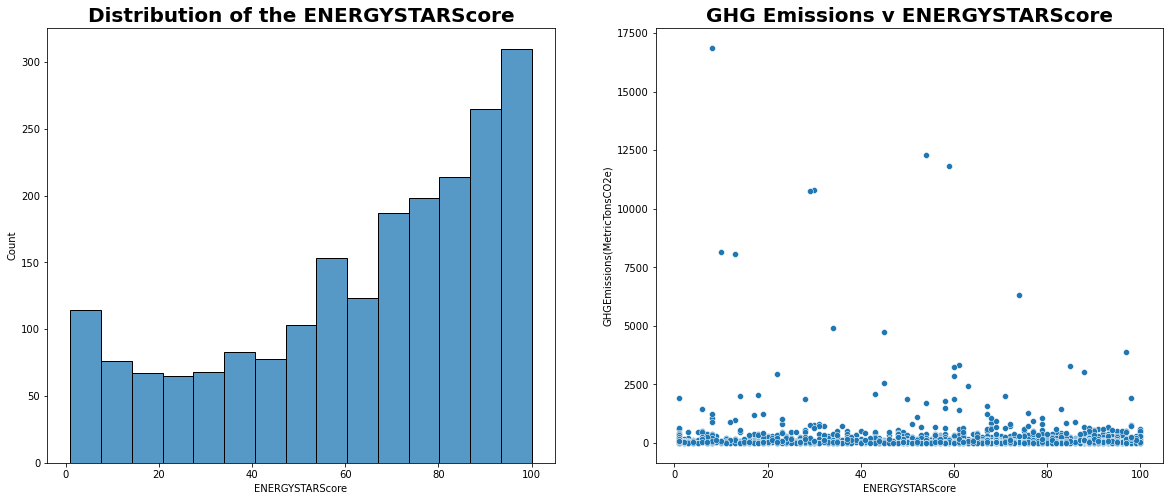

In [1206]:
fig, axes = plt.subplots(1, 2, figsize=(20,8))
sns.histplot(data=Xstar, x='ENERGYSTARScore', ax=axes[0])
axes[0].set_title("Distribution of the ENERGYSTARScore", weight = 'bold', size = 20)

sns.scatterplot(data=df_energystar, y='GHGEmissions(MetricTonsCO2e)', x='ENERGYSTARScore', ax=axes[1])
axes[1].set_title("GHG Emissions v ENERGYSTARScore", weight = 'bold', size = 20)
plt.show()

#### GHG EMISSIONS with ENERGYSTARScore - RANDOMFOREST REGRESSION

In [1207]:
#f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

Xstar_train, Xstar_test, Ystar_train, Ystar_test = train_test_split(Xstar, Ystar, test_size=0.2, random_state=42)
# Use RandomForest model
start_time12 = time.time()
pipe_rfr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', RandomForestRegressor())])

params_rfr = {'regressor__max_features' : ['auto', 'sqrt', 'log2'], # The number of features to consider when looking for the best split
             'regressor__max_depth': [5, 15, 25, 50, 100], # The maximum depth of the tree
             'regressor__min_samples_split': [2, 5, 10], # The minimum number of samples required to split an internal node (default=2)
             'regressor__bootstrap' : [True, False], # Whether bootstrap samples are used when building trees
             'regressor__min_samples_leaf': [1,2,5,10]} # The minimum number of samples required to be at a leaf node (default=1)

grid_cvrfr = GridSearchCV(pipe_rfr,
                          param_grid=params_rfr,
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)

stars_rfr = grid_cvrfr.fit(Xstar_train, Ystar_train['GHGEmissions(MetricTonsCO2e)'])

Ystar_pred = stars_rfr.predict(Xstar_test)
tm12 = time.time() - start_time12

# Plot results
# ax0.scatter(ystar_test['GHGEmissions(MetricTonsCO2e)'], ystar_pred)
# ax0.plot([0, 12e3], [0, 12e3], '--k')
# ax0.set_ylabel('Target predicted', size = 20)
# ax0.set_xlabel('True Target', size = 20)
# ax0.set_title('RandomForest regression \n without target transformation but with ENERGYSTARScore')
r2_test12 = r2_score(Ystar_test['GHGEmissions(MetricTonsCO2e)'], Ystar_pred)
MAE_test12 = mean_absolute_error(Ystar_test['GHGEmissions(MetricTonsCO2e)'], Ystar_pred)

# ax0.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test12, MAE_test12, RMSE_test12))
# ax0.set_xlim([0, 12e3])
# ax0.set_ylim([0, 12e3])

# ######################################################################################
# Transform targets and use same RandomForest model
start_time121 = time.time()


stars_rfr_log = grid_cvrfr.fit(Xstar_train, Ystar_train['LogGHG'])
Ystar_pred = stars_rfr_log.predict(Xstar_test)
tm121 = time.time() - start_time121

# ax1.scatter(ystar_test['GHGEmissions(MetricTonsCO2e)'], ystar_pred)
# ax1.plot([0, 12e3], [0, 12e3], '--k')
# ax1.set_ylabel('Target predicted', size = 20)
# ax1.set_xlabel('True Target', size = 20)
# ax1.set_title('RandomForest regression \n with LOG target transformation & ENERGYSTARScore')
r2_test121 = r2_score(Ystar_test['LogGHG'], Ystar_pred)
MAE_test121 = mean_absolute_error(np.expm1(Ystar_test['LogGHG']), np.expm1(Ystar_pred))

# ax1.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test121, MAE_test121, RMSE_test121))
# ax1.set_xlim([0, 12e3])
# ax1.set_ylim([0, 12e3])

# f.suptitle('GHGEmissions(MetricTonsCO2e)', x = 1, y=0.005, weight = 'bold', size = 20)
# f.tight_layout(rect=[0.005, 0.005, 2, 1.5])
# print('Best parameters lin scale:', stars_rfr.best_params_)
# print('Best parameters log scale : {}'.format(stars_rfr_log.named_steps['grid_rfrE'].best_params_))

__XGBoost on GHG with ENERGYSTARScore__

In [1208]:
# f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

# Use XGBoost model
start_time13 = time.time()
pipe_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', xgb.XGBRegressor())])

params_xgb = {'regressor__n_estimators': [0, 1000, 100], # Number of trees in RandomForest (default=100)
              'regressor__min_child_weight' : [1.0, 10.0, 1.0], # Minimum sum of instance weight needed in a child (default=1)
             'regressor__max_depth': [6, 20, 1], # Maximum depth of a tree (default=6). Increasing this value will make
                                                 # the model more complex and more likely to overfit.
             'regressor__learning_rate' : [0.001, 0.01, 0.1, 0.2, 0.3], # Weight factor for the corrections by new trees
                                                                        # to slow down the learning
             'regressor__gamma': [0, 10, 0.1]} # Minimum loss reduction required to make a further partition 
                                               # on a leaf node of the tree (default=0)
                     
grid_cvxgb = GridSearchCV(pipe_xgb,
                          param_grid = params_xgb,
                          cv = 5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit = 'neg_mean_absolute_error',
                          n_jobs = -1)

stars_xgb = grid_cvxgb.fit(Xstar_train, Ystar_train['GHGEmissions(MetricTonsCO2e)'])

Ystar_pred = stars_xgb.predict(Xstar_test)
tm13 = time.time() - start_time13

# Plot results
# ax0.scatter(ystar_test['GHGEmissions(MetricTonsCO2e)'], ystar_pred)
# ax0.plot([0, 12e3], [0, 12e3], '--k')
# ax0.set_ylabel('Target predicted', size = 20)
# ax0.set_xlabel('True Target', size = 20)
# ax0.set_title('XGBoost regression \n without target transformation but with ENERGYSTARScore')
r2_test13 = r2_score(Ystar_test['GHGEmissions(MetricTonsCO2e)'], Ystar_pred)
MAE_test13 = mean_absolute_error(Ystar_test['GHGEmissions(MetricTonsCO2e)'], Ystar_pred)

# ax0.text(1000, 10000, r'$R^2$=%.2f, MAE=%.2f, RMSE=%.2f' % (r2_test13, MAE_test13, RMSE_test13))
# ax0.set_xlim([0, 12e3])
# ax0.set_ylim([0, 12e3])

# ################################################################################
# Transform targets and use same XGBoost model
start_time131 = time.time()

xgb_grid_cv = GridSearchCV(pipe_xgb,
                          param_grid = params_xgb,
                          cv = 5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit = 'neg_mean_absolute_error',
                          n_jobs = -1)

stars_xgb_log = xgb_grid_cv.fit(Xstar_train, Ystar_train['LogGHG'])
Ystar_pred = stars_xgb_log.predict(Xstar_test)
tm131 = time.time() - start_time131

# ax1.scatter(ystar_test['LogGHG'], ystar_pred)
# ax1.plot([0, 12e3], [0, 12e3], '--k')
# ax1.set_ylabel('Target predicted', size = 20)
# ax1.set_xlabel('True Target', size = 20)
# ax1.set_title('XGBoost regression \n with LOG target transformation & ENERGYSTARScore')
r2_test131 = r2_score(Ystar_test['LogGHG'], Ystar_pred)
MAE_test131 = mean_absolute_error(np.expm1(Ystar_test['LogGHG']), np.expm1(Ystar_pred))
RMSE_test131 = np.sqrt(mean_squared_error(Ystar_test['LogGHG'], Ystar_pred))


__RESULTS FOR GHG EMISSIONS WITH ENERGYSTARScore ADDED__

In [1209]:
# GHG Emissions
metrics_GHG = ['R2 lin', 'R2 log', 'MAE lin', "MAE log", 'Running time(s) lin', 'Running time(s) log']
GHG_data = {'RandomForest' : pd.Series([r2_test77, r2_test_77, MAE_test77, MAE_test_77, tm77, tm_77],
                        index = metrics_GHG),
            'RandomForest ENERGYSTAR' : pd.Series([r2_test12, r2_test121, MAE_test12, MAE_test121, tm12, tm121],
                        index = metrics_GHG),
            'XGBoost' : pd.Series([r2_test88, r2_test_88, MAE_test88, MAE_test_88, tm88, tm_88],
                        index = metrics_GHG),
            'XGBoost ENERGYSTAR' : pd.Series([r2_test13, r2_test131, MAE_test13, MAE_test131, tm13, tm131],
                        index = metrics_GHG)}

# Creates Dataframe df_GHG Stars for GHG Emissions

df_GHG_stars = pd.DataFrame(GHG_data)
index = df_GHG_stars.index
index. name = "Metrics"
df_GHG_stars.round(2)

,RandomForest,RandomForest ENERGYSTAR,XGBoost,XGBoost ENERGYSTAR
Metrics,,,,
R2 lin,0.87,0.89,0.68,0.95
R2 log,0.86,0.79,0.90,0.83
MAE lin,2419710.52,64.11,2333325.20,43.89
MAE log,2401576.43,50.73,1905694.98,51.30
Running time(s) lin,263.50,166.14,826.32,543.33
Running time(s) log,264.17,157.18,576.20,516.75


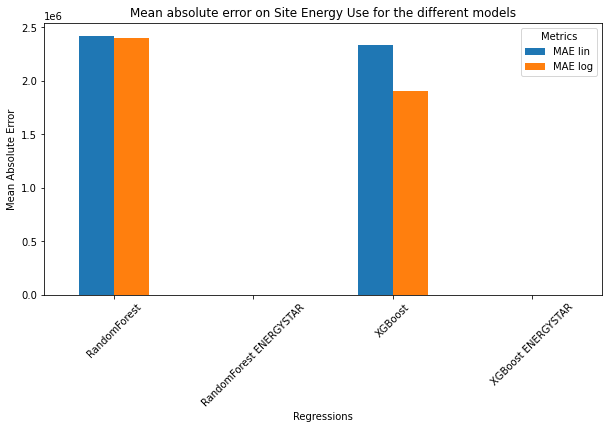

In [1212]:
df_stars = df_GHG_stars.T
plt.rcParams["figure.figsize"] = (10, 5)
df_stars1 = df_stars[["MAE lin", "MAE log"]].plot( y=["MAE lin", "MAE log"], kind="bar", rot = 45)
plt.xlabel("Regressions")
plt.ylabel("Mean Absolute Error")
plt.title("Mean absolute error on Site Energy Use for the different models")

plt.show()

In [1211]:
np.expm1(1.2)

2.3201169227365472